# Práctica 2: Análisis de extremos, análisis espectral y filtros

In [473]:
### IMPORTS ###
# Módulos básicos y otros
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

# Estadística
from scipy import stats 
from scipy import special

# Cartografía 
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from cartopy.util import add_cyclic_point
import cartopy.io.shapereader as shpreader

# Lectura de datos
from netCDF4 import Dataset
import xarray as xr

# Índices Climáticos
from xclim.core.calendar import percentile_doy
from xclim.indices import tn10p, tx10p

from scipy.fft import fft 
from statsmodels.tsa import stattools 
from scipy import signal


Vamos a calcular los siguientes indices de extremos:

![title](./img/index.png)

Lectura de datos (necesitaremos tanto Tmax como Tmin):

In [474]:
path = '../Practica 2/Datos/'
file_max = 'tmax_pen.nc'
data_max = xr.open_dataset(path+file_max)
file_min = 'tmin_pen.nc'
data_min = xr.open_dataset(path+file_min)
display(data_max)
data_min

<xarray.Dataset>
Dimensions:  (lon: 230, lat: 190, Time: 41638)
Coordinates:
  * lon      (lon) float64 -9.673 -9.614 -9.556 -9.497 ... 3.607 3.665 3.724
  * lat      (lat) float64 44.17 44.12 44.08 44.03 ... 35.8 35.75 35.71 35.66
  * Time     (Time) datetime64[ns] 1901-01-02 1901-01-03 ... 2015-01-01
Data variables:
    tx       (Time, lat, lon) float32 ...
Attributes: (12/13)
    title:             Daily maximum temperature of peninsular Spain
    history:           version 1.0
    keywords:          daily, maximum temperature, peninsular Spain, Spain
    creator_name:      Roberto Serrano-Notivoli; Martin de Luis; Santiago Beg...
    maintainer_name:   Roberto Serrano-Notivoli
    maintainer_email:  rs@unizar.es
    ...                ...
    processing_level:  Quality-controlled. Final values.
    acknowledgment:    This study was supported by research projects financed...
    units:             Celsius degrees
    id:                STEAD
    sources:           AEMET and MAGRAMA
    naming_authority:  Spanish TEmperature At Daily scale

<xarray.Dataset>
Dimensions:  (lon: 230, lat: 190, Time: 41638)
Coordinates:
  * lon      (lon) float64 -9.673 -9.614 -9.556 -9.497 ... 3.607 3.665 3.724
  * lat      (lat) float64 44.17 44.12 44.08 44.03 ... 35.8 35.75 35.71 35.66
  * Time     (Time) datetime64[ns] 1901-01-02 1901-01-03 ... 2015-01-01
Data variables:
    tn       (Time, lat, lon) float32 ...
Attributes: (12/13)
    title:             Daily minimum temperature of peninsular Spain
    history:           version 1.0
    keywords:          daily, minimum temperature, peninsular Spain, Spain
    creator_name:      Roberto Serrano-Notivoli; Martin de Luis; Santiago Beg...
    maintainer_name:   Roberto Serrano-Notivoli
    maintainer_email:  rs@unizar.es
    ...                ...
    processing_level:  Quality-controlled. Final values.
    acknowledgment:    This study was supported by research projects financed...
    units:             Celsius degrees
    id:                STEAD
    sources:           AEMET and MAGRAMA
    naming_authority:  Spanish TEmperature At Daily scale

In [475]:
# Separamos las variables (las lat y lon son las mismas al ser la misma base de datos)
lon = data_min.lon
lat = data_min.lat
tmin = data_min.tn
tmax = data_max.tx
display(tmax)
display(tmin)

<xarray.DataArray 'tx' (Time: 41638, lat: 190, lon: 230)>
[1819580600 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -9.673 -9.614 -9.556 -9.497 ... 3.607 3.665 3.724
  * lat      (lat) float64 44.17 44.12 44.08 44.03 ... 35.8 35.75 35.71 35.66
  * Time     (Time) datetime64[ns] 1901-01-02 1901-01-03 ... 2015-01-01
Attributes:
    units:      Celsius degrees
    long_name:  Maximum temperature

<xarray.DataArray 'tn' (Time: 41638, lat: 190, lon: 230)>
[1819580600 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -9.673 -9.614 -9.556 -9.497 ... 3.607 3.665 3.724
  * lat      (lat) float64 44.17 44.12 44.08 44.03 ... 35.8 35.75 35.71 35.66
  * Time     (Time) datetime64[ns] 1901-01-02 1901-01-03 ... 2015-01-01
Attributes:
    units:      Celsius degrees
    long_name:  Minimum temperature

---

Calculamos las cold_nights:

In [476]:
# Defino funciones para calcular el índice y los percentiles mediante el módulo xclim
def cold_nights_xclim(tmin:xr.DataArray, period:list, ref_period=['1961','1990']):
    try:
        tmin.time
        print('Funciono bien :)')
    except: 
        tmin = tmin.rename({'Time': 'time'})
        print('Te he cambiado el tiempo')
    #tmin = tmin.convert_calendar('noleap',dim='time')
    print('>> Calculando percentiles')
    tmin.attrs['units'] = 'degC'
    base = tmin.sel(time=slice('1961','1990'))
    tmin_per = percentile_doy(base, per=10).sel(percentiles=10)
    print('>> Percentiles calculados')
    print('>> Calculando indice')
    num_cold = tn10p(tmin.sel(time=slice(period[0],period[1])), tmin_per)
    percent_cold_nights = num_cold/365*100
    print('>> Índice calculado')
    return tmin_per, percent_cold_nights

def cold_days_xclim(tmax:xr.DataArray, period:list, ref_period=['1961','1990']):
    try: tmax.time
    except: tmax = tmax.rename({'Time': 'time'})
    #tmax = tmax.convert_calendar('noleap',dim='time')
    print('>> Calculando percentiles')
    tmax.attrs['units'] = 'degC'
    base = tmax.sel(time=slice('1961','1990'))
    tmax_per = percentile_doy(base, per=10).sel(percentiles=10)
    print('>> Percentiles calculados')
    print('>> Calculando indice')
    num_cold = tn10p(tmax.sel(time=slice(period[0],period[1])), tmax_per)
    percent_cold_days = num_cold/365*100
    print('>> Índice calculado')
    return tmax_per, percent_cold_days


In [477]:
lat_oeste = [42,43.8]
lon_oeste = [-9,-6]
tminO = tmin.sel(lon=slice(lon_oeste[0],lon_oeste[1]),lat=slice(lat_oeste[1],lat_oeste[0]))
try:
    tmin_p10_O = xr.open_dataarray('./Codigos/Diego/outs/tmin_p10_O.nc')
    percent_cold_nights_O = xr.open_dataarray('./Codigos/Diego/outs/percent_cold_nights_O.nc')
except: 
    tmin_p10_O, percent_cold_nights_O = cold_nights_xclim(tminO,['1901','2014'])
    tmin_p10_O.to_netcdf('./Codigos/Diego/outs/tmin_p10_O.nc')
    percent_cold_nights_O.to_netcdf('./Codigos/Diego/outs/percent_cold_nights_O.nc')
display(tmin_p10_O)
display(percent_cold_nights_O)

<xarray.DataArray 'per' (lat: 40, lon: 51, dayofyear: 366)>
[746640 values with dtype=float64]
Coordinates:
  * lon          (lon) float64 -8.971 -8.912 -8.854 ... -6.163 -6.104 -6.046
  * lat          (lat) float64 43.76 43.72 43.67 43.63 ... 42.1 42.05 42.01
    percentiles  int32 ...
  * dayofyear    (dayofyear) int32 1 2 3 4 5 6 7 ... 360 361 362 363 364 365 366
Attributes:
    units:               °C
    long_name:           Minimum temperature
    climatology_bounds:  ['1961-01-01', '1990-12-31']
    window:              5
    alpha:               0.3333333333333333
    beta:                0.3333333333333333
    history:             [2022-11-17 00:30:33] per: percentile_doy(arr=tn, wi...

<xarray.DataArray (time: 114, lat: 40, lon: 51)>
[232560 values with dtype=float64]
Coordinates:
  * lon          (lon) float64 -8.971 -8.912 -8.854 ... -6.163 -6.104 -6.046
  * lat          (lat) float64 43.76 43.72 43.67 43.63 ... 42.1 42.05 42.01
    percentiles  int32 ...
  * time         (time) datetime64[ns] 1901-01-01 1902-01-01 ... 2014-01-01

In [478]:
tminC = tmin.sel(lat=slice(42,38),lon=slice(-7, -1))

try: 
    tmin_p10_C = xr.open_dataarray('./Codigos/Diego/outs/tmin_p10_C.nc')
    percent_cold_nights_C = xr.open_dataarray('./Codigos/Diego/outs/percent_cold_nights_C.nc')
    print('Leido de outs')
except:
    tmin_p10_C, percent_cold_nights_C = cold_nights_xclim(tmin.sel(lat=slice(42,38),lon=slice(-7, -1)),['1901','2014'])
    tmin_p10_C.to_netcdf('./Codigos/Diego/outs/tmin_p10_C.nc')
    percent_cold_nights_C.to_netcdf('./Codigos/Diego/outs/percent_cold_nights_C.nc')

Leido de outs


In [479]:
tmaxC = tmax.sel(lat=slice(42,38),lon=slice(-7, -1))
try: 
    tmax_p10_C = xr.open_dataarray('./Codigos/Diego/outs/tmax_p10_C.nc')
    percent_cold_days_C = xr.open_dataarray('./Codigos/Diego/outs/percent_cold_days_C.nc')
    print('Leido de outs')
except:
    tmax_p10_C, percent_cold_days_C = cold_nights_xclim(tmax.sel(lat=slice(42,38),lon=slice(-7, -1)),['1901','2014'])
    tmax_p10_C.to_netcdf('./Codigos/Diego/outs/tmax_p10_C.nc')
    percent_cold_days_C.to_netcdf('./Codigos/Diego/outs/percent_cold_days_C.nc')

Leido de outs


/Users/cova/opt/anaconda3/envs/covaconda/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/cova/opt/anaconda3/envs/covaconda/lib/python3.7/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/cova/opt/anaconda3/envs/covaconda/lib/python3.7/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


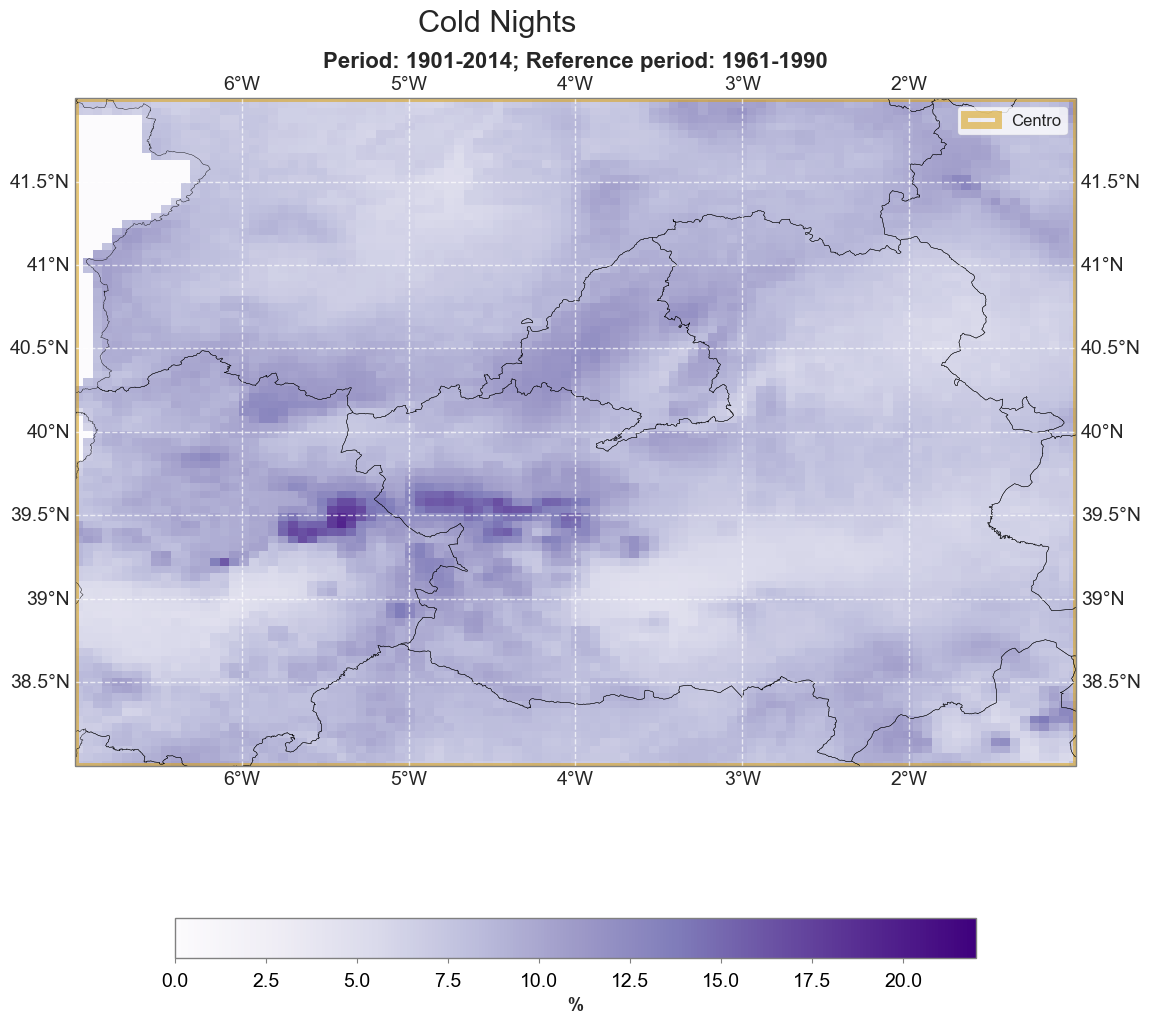

In [480]:
# Downloaded from http://biogeo.ucdavis.edu/data/gadm2/shp/DEU_adm.zip
fname = './Codigos/Diego/mapas/gadm41_ESP_1.shp'

adm1_shapes = list(shpreader.Reader(fname).geometries())
def pinta_region(lats,lons,color,ax=ax,label=None):
    lat_corners = np.array([lats[0], lats[0],lats[1], lats[1]])
    lon_corners = np.array([ lons[0], lons[1], lons[1], lons[0]])
    poly_corners = np.zeros((len(lat_corners), 2), np.float64)
    poly_corners[:,0] = lon_corners
    poly_corners[:,1] = lat_corners
    poly = mpatches.Polygon(poly_corners, closed=True, ec=color, fill=False, lw=5, fc=color,label=label,alpha=0.6, transform=ccrs.Geodetic()) # geodetic para que transforme los rectángulos a la proyección correcta
    ax.add_patch(poly)

fig, ax = plt.subplots(figsize=(12,12), ncols=1)
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
plt.suptitle('Cold Nights',size=22)
plt.title('Period: 1901-2014; Reference period: 1961-1990',size=16)
ax.set_global() # added following an answer to my question
#ax.gridlines()
ax.gridlines(draw_labels = True,linestyle='--',alpha=0.7,zorder=1)
ax.set_extent([-9.8,5,35.5,44], ccrs.PlateCarree())
cmap = 'Purples'
var = percent_cold_nights_C.mean(dim='time')
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree()) 
cbar = fig.colorbar(im,ax=ax,orientation = 'horizontal',shrink=0.8)
cbar.set_label(label='%',size=13)
cbar.ax.set_xlim(0, 22)
pinta_region([38, 42],[-7, -1],'goldenrod',ax,label='Centro')
ax.coastlines(resolution='10m')#, linewidth=2)
ax.add_geometries(adm1_shapes, ccrs.PlateCarree(), # Cuidado con los sistemas de coordenadas, esto esta definido solo para este sistema
                  edgecolor='black', facecolor='None', alpha=1)
ax.set_ylim(38,42)
ax.set_xlim(-7,-1)
ax.legend(prop={'size':12})
plt.tight_layout()

/Users/cova/opt/anaconda3/envs/covaconda/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/cova/opt/anaconda3/envs/covaconda/lib/python3.7/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/cova/opt/anaconda3/envs/covaconda/lib/python3.7/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


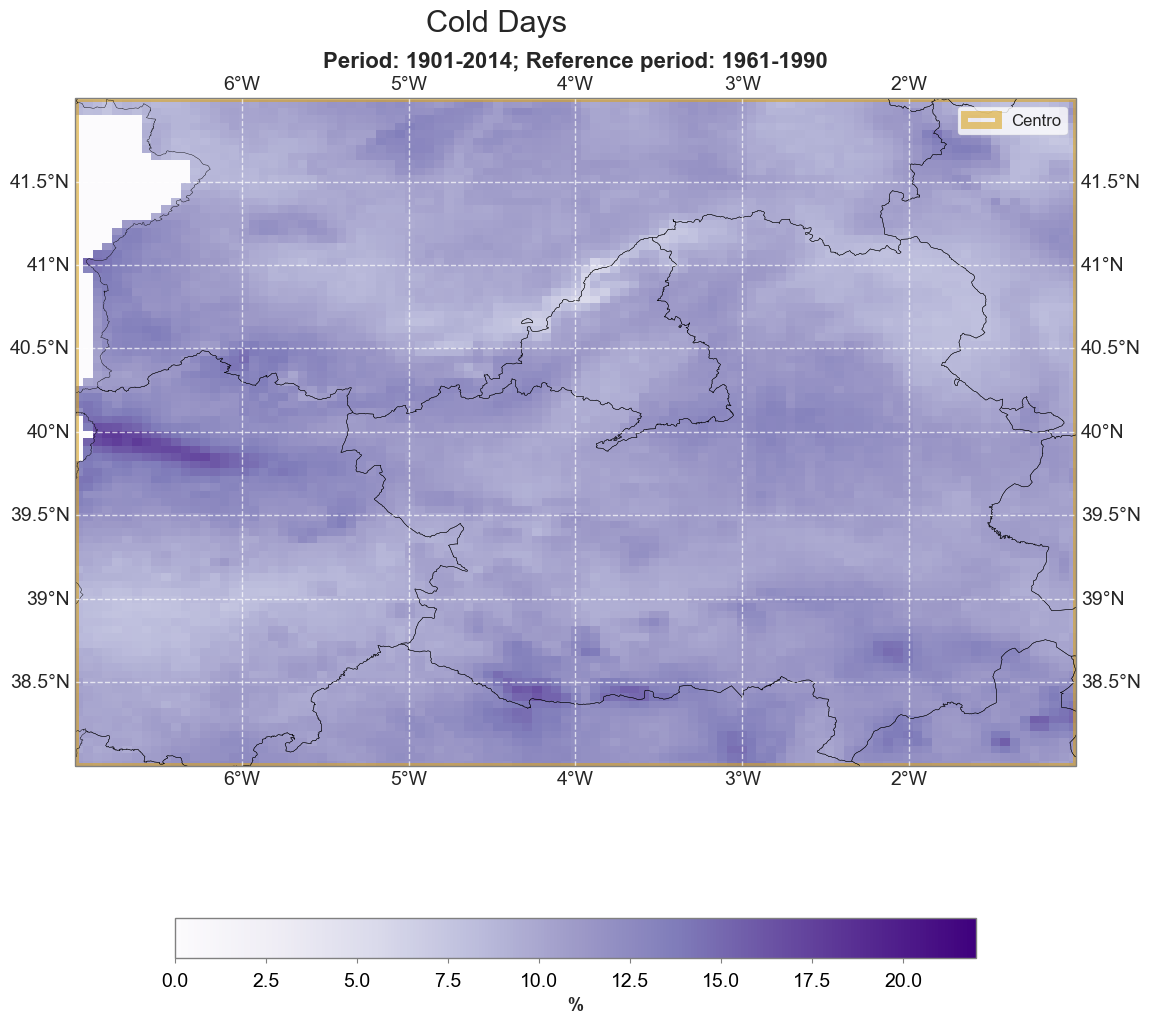

In [481]:
# Downloaded from http://biogeo.ucdavis.edu/data/gadm2/shp/DEU_adm.zip
fname = './Codigos/Diego/mapas/gadm41_ESP_1.shp'

adm1_shapes = list(shpreader.Reader(fname).geometries())


fig, ax = plt.subplots(figsize=(12,12), ncols=1)
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
plt.suptitle('Cold Days',size=22)
plt.title('Period: 1901-2014; Reference period: 1961-1990',size=16)
ax.set_global() # added following an answer to my question
#ax.gridlines()
ax.gridlines(draw_labels = True,linestyle='--',alpha=0.7,zorder=1)
ax.set_extent([-9.8,5,35.5,44], ccrs.PlateCarree())
cmap = 'Purples'
var = percent_cold_days_C.mean(dim='time')
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree()) 
cbar = fig.colorbar(im,ax=ax,orientation = 'horizontal',shrink=0.8)
cbar.set_label(label='%',size=13)
cbar.ax.set_xlim(0, 22)
pinta_region([38, 42],[-7, -1],'goldenrod',ax,label='Centro')
ax.coastlines(resolution='10m')#, linewidth=2)
ax.add_geometries(adm1_shapes, ccrs.PlateCarree(), # Cuidado con los sistemas de coordenadas, esto esta definido solo para este sistema
                  edgecolor='black', facecolor='None', alpha=1)
ax.set_ylim(38,42)
ax.set_xlim(-7,-1)
ax.legend(prop={'size':12})
plt.tight_layout()

/Users/cova/opt/anaconda3/envs/covaconda/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/cova/opt/anaconda3/envs/covaconda/lib/python3.7/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/cova/opt/anaconda3/envs/covaconda/lib/python3.7/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


(38.0, 42.0)

/Users/cova/opt/anaconda3/envs/covaconda/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/cova/opt/anaconda3/envs/covaconda/lib/python3.7/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/cova/opt/anaconda3/envs/covaconda/lib/python3.7/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


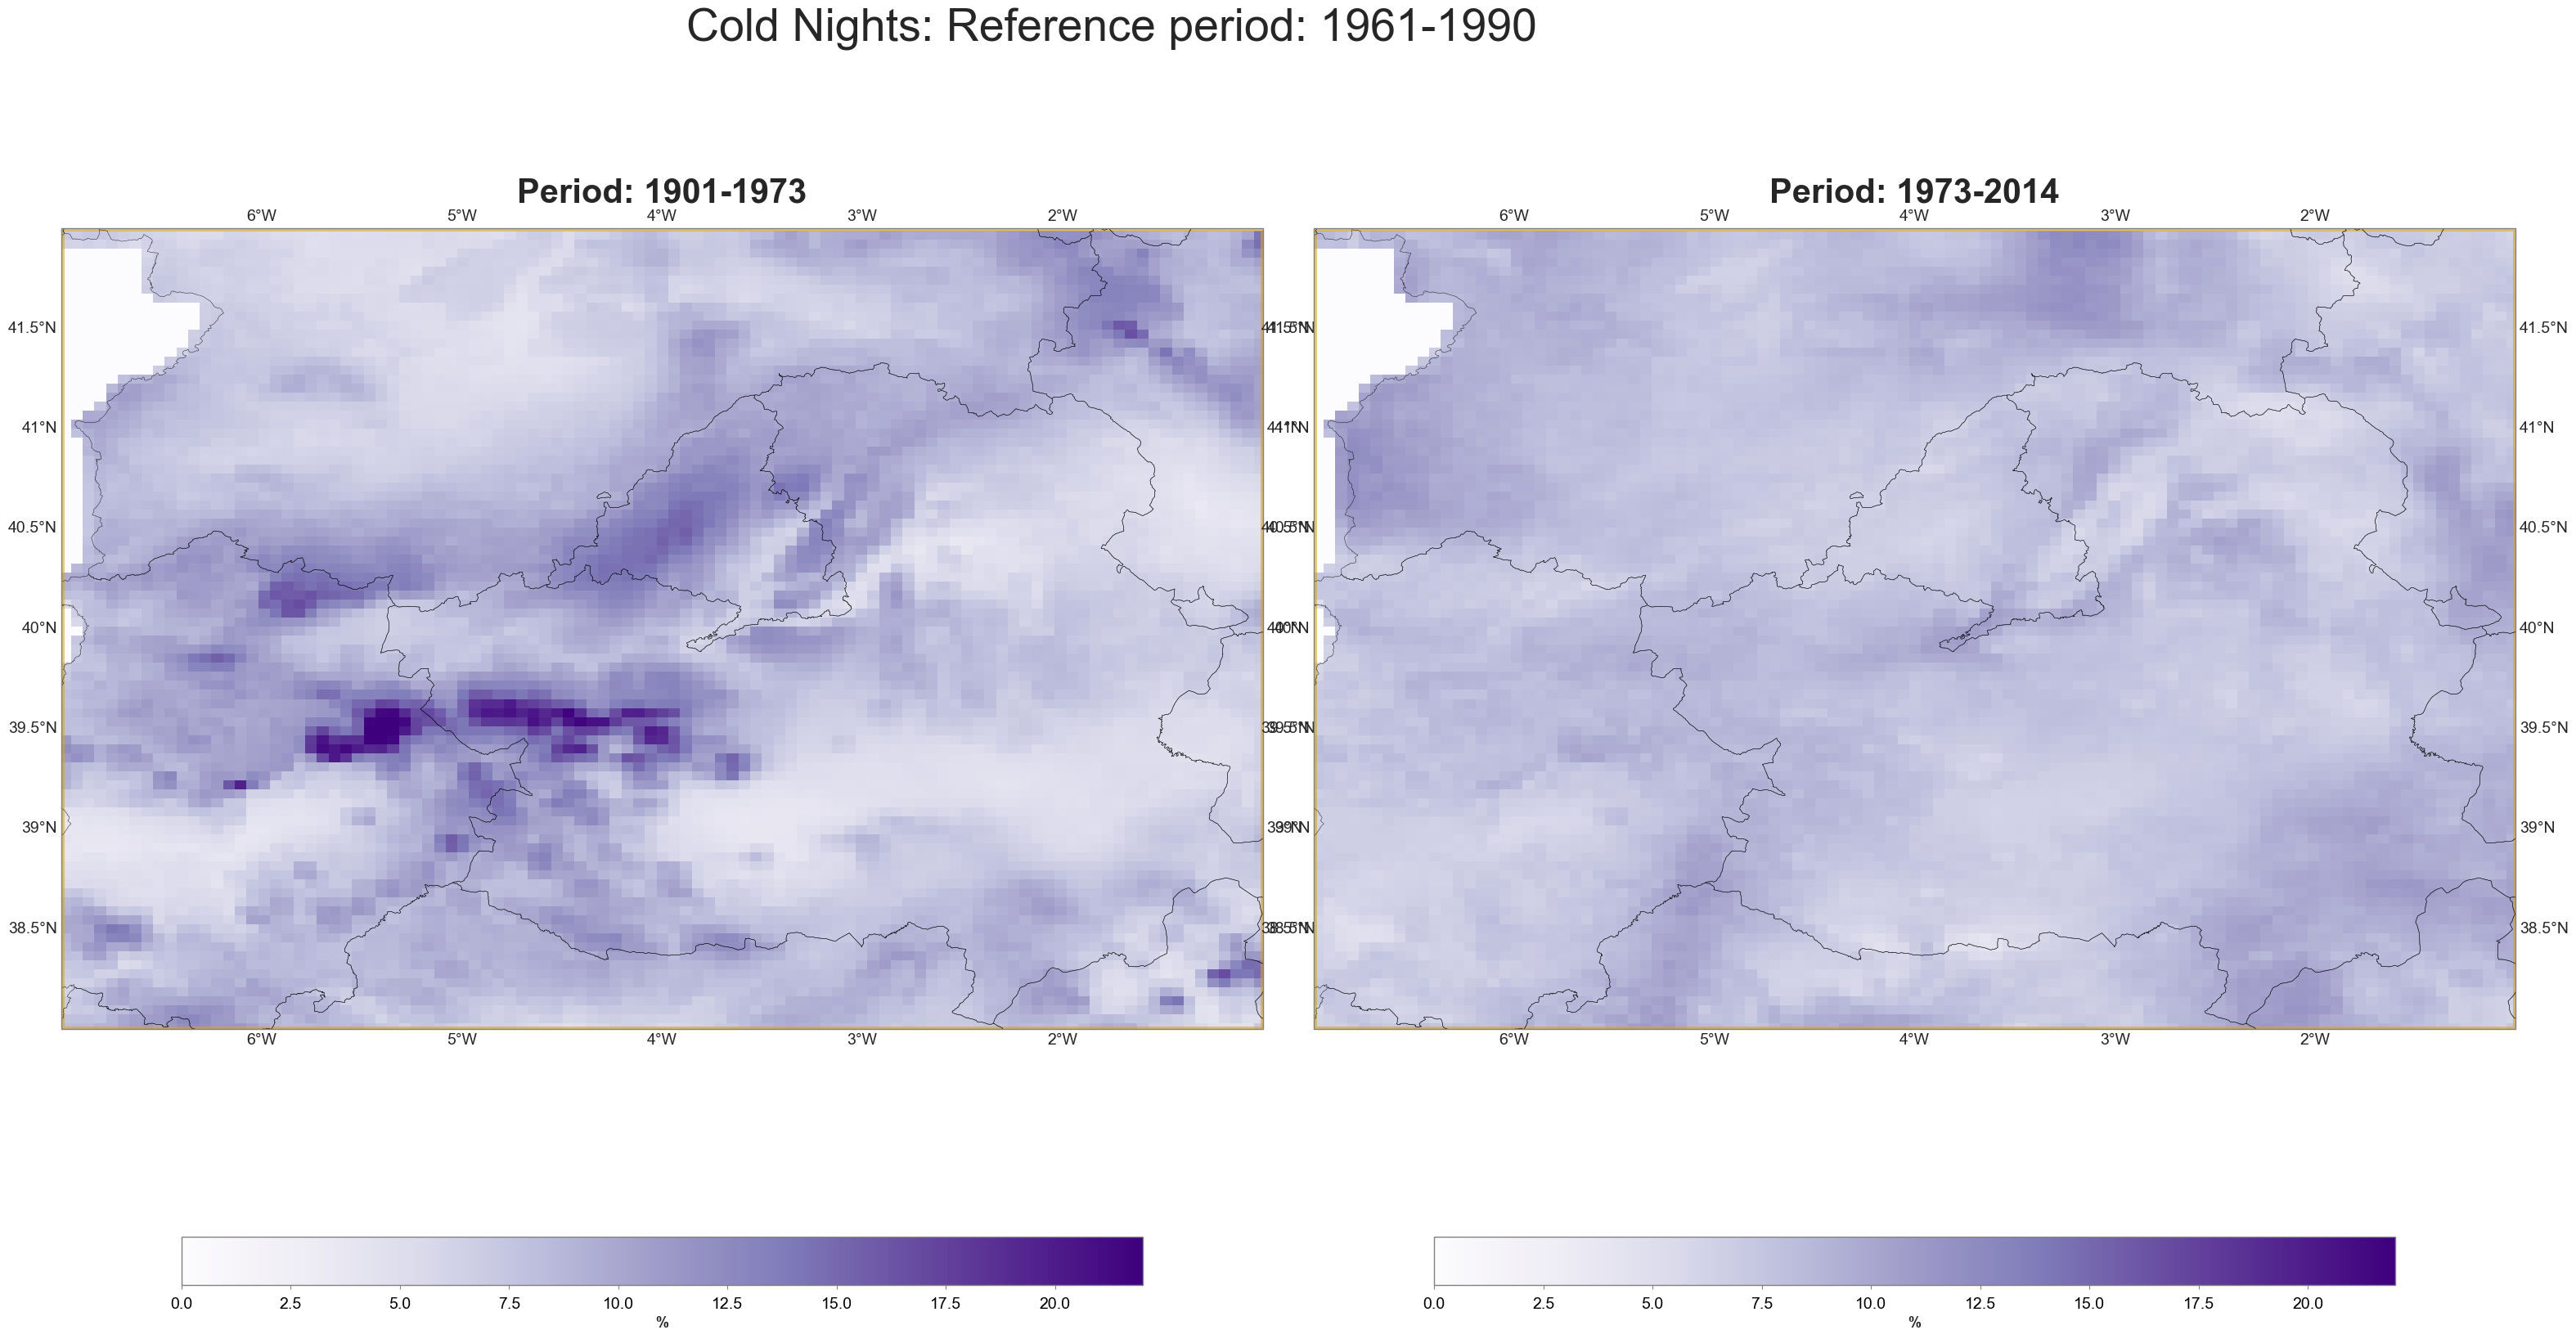

In [482]:
# Downloaded from http://biogeo.ucdavis.edu/data/gadm2/shp/DEU_adm.zip
fname = './Codigos/Diego/mapas/gadm41_ESP_1.shp'

adm1_shapes = list(shpreader.Reader(fname).geometries())

fig, ax = plt.subplots(1,2,figsize=(35, 20))
ax[0]=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
plt.suptitle('Cold Nights: Reference period: 1961-1990',size=40)
plt.title('Period: 1901-1973',size=30)
ax[0].set_global() # added following an answer to my question
ax[0].gridlines(draw_labels = True,linestyle='--',alpha=0.,zorder=1)
ax[0].set_extent([-9.8,5,35.5,44], ccrs.PlateCarree())
cmap = 'Purples'
var1 = percent_cold_nights_C[:73,:,:].mean(dim='time')
#var1 = percent_cold_nights_C[:73,:,:].mean(dim='time')
im = ax[0].pcolormesh(var1.lon,var1.lat,var1.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree()) 
cbar = fig.colorbar(im,ax=ax[0],orientation = 'horizontal',shrink=0.8)
cbar.set_label(label=f'%',size=13)
cbar.ax.set_xlim(0, 22)
pinta_region([38, 42],[-7, -1],'goldenrod',ax[0],label='Centro')
ax[0].add_geometries(adm1_shapes, ccrs.PlateCarree(), # Cuidado con los sistemas de coordenadas, esto esta definido solo para este sistema
                  edgecolor='black', facecolor='None', alpha=1)                 
ax[0].set_xlim(-7,-1)
ax[0].set_ylim(38,42)
plt.tight_layout()

ax[1]=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
ax[1].set_global() # added following an answer to my question
ax[1].gridlines(draw_labels = True,linestyle='--',alpha=0.,zorder=1)
ax[1].set_extent([-9.8,5,35.5,44], ccrs.PlateCarree())
cmap = 'Purples'
var2 = percent_cold_nights_C[73:].mean(dim='time')
#var2 = percent_cold_nights_C[73:,:,:].mean(dim='time')
im = ax[1].pcolormesh(var2.lon,var2.lat,var2.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree()) 
cbar = fig.colorbar(im,ax=ax[1],orientation = 'horizontal',shrink=0.8)
cbar.set_label(label=f'%',size=13)
cbar.ax.set_xlim(0, 22)
pinta_region([38, 42],[-7, -1],'goldenrod',ax[1],label='Centro')
ax[1].add_geometries(adm1_shapes, ccrs.PlateCarree(), # Cuidado con los sistemas de coordenadas, esto esta definido solo para este sistema
                  edgecolor='black', facecolor='None', alpha=1)
plt.title('Period: 1973-2014',size=30)
ax[1].set_xlim(-7,-1)
ax[1].set_ylim(38,42)

/Users/cova/opt/anaconda3/envs/covaconda/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/cova/opt/anaconda3/envs/covaconda/lib/python3.7/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/cova/opt/anaconda3/envs/covaconda/lib/python3.7/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


(38.0, 42.0)

/Users/cova/opt/anaconda3/envs/covaconda/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/cova/opt/anaconda3/envs/covaconda/lib/python3.7/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/cova/opt/anaconda3/envs/covaconda/lib/python3.7/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


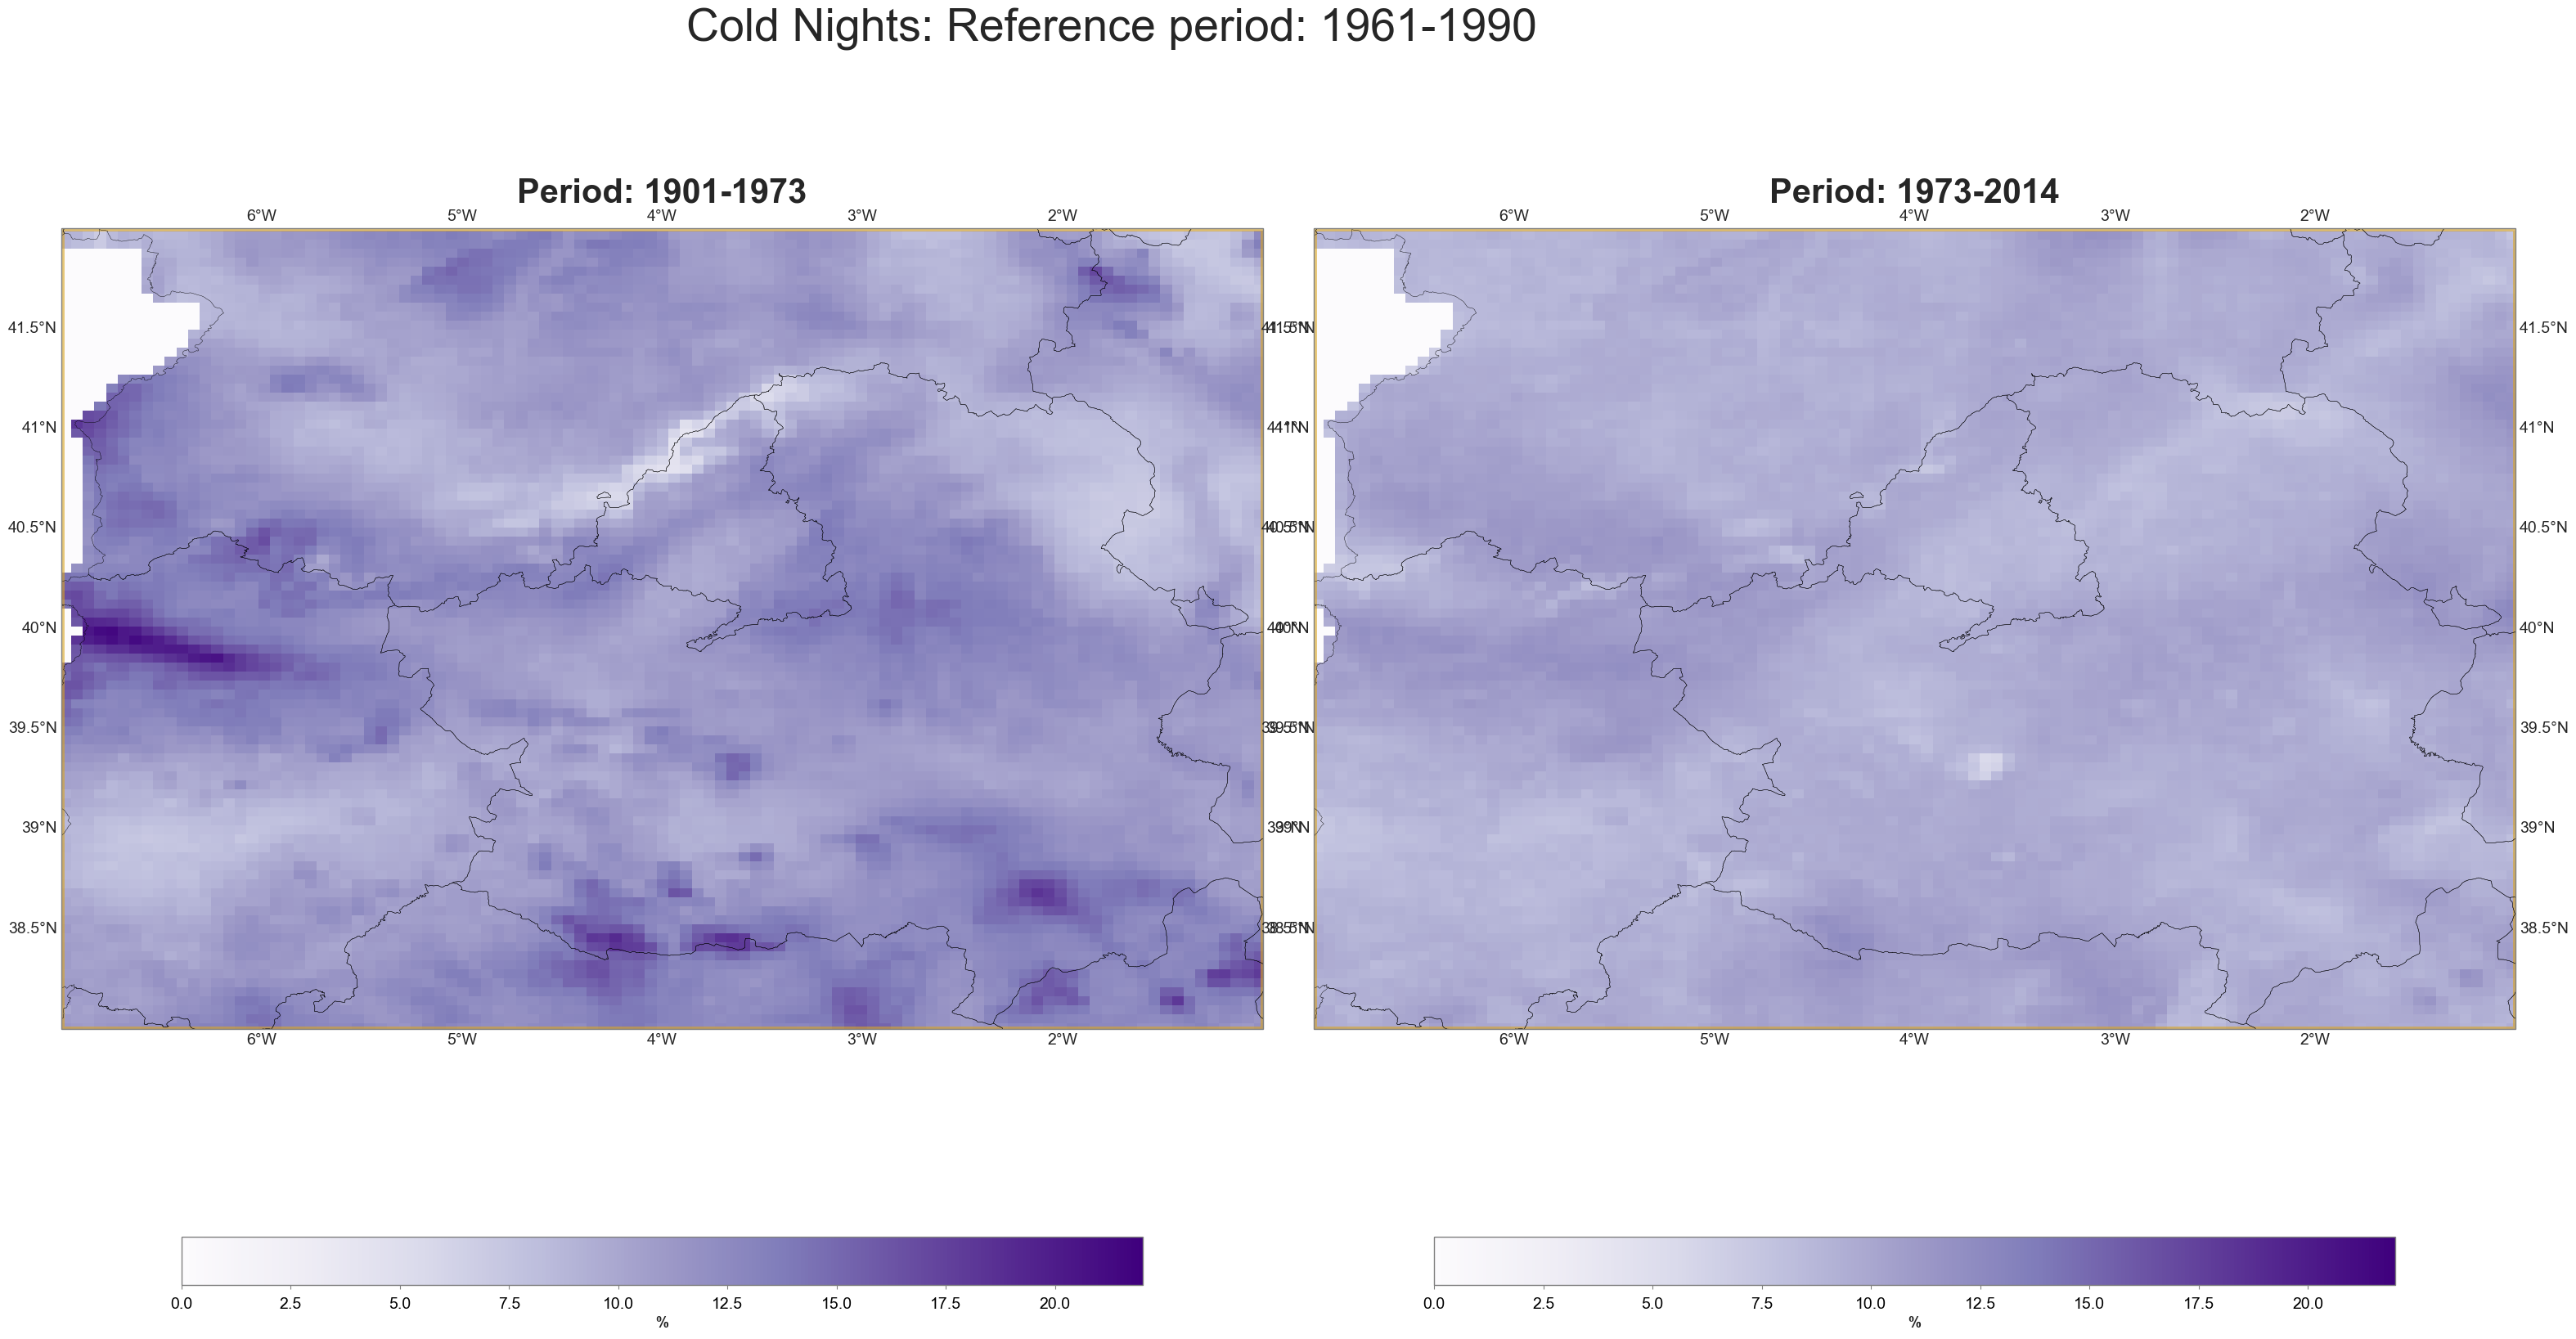

In [483]:
# Downloaded from http://biogeo.ucdavis.edu/data/gadm2/shp/DEU_adm.zip
fname = './Codigos/Diego/mapas/gadm41_ESP_1.shp'

adm1_shapes = list(shpreader.Reader(fname).geometries())

fig, ax = plt.subplots(1,2,figsize=(35, 20))
ax[0]=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
plt.suptitle('Cold Nights: Reference period: 1961-1990',size=40)
plt.title('Period: 1901-1973',size=30)
ax[0].set_global() # added following an answer to my question
ax[0].gridlines(draw_labels = True,linestyle='--',alpha=0.,zorder=1)
ax[0].set_extent([-9.8,5,35.5,44], ccrs.PlateCarree())
cmap = 'Purples'
var1 = percent_cold_days_C[:73,:,:].mean(dim='time')
#var1 = percent_cold_days_C[:73,:,:].mean(dim='time')
im = ax[0].pcolormesh(var1.lon,var1.lat,var1.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree()) 
cbar = fig.colorbar(im,ax=ax[0],orientation = 'horizontal',shrink=0.8)
cbar.set_label(label=f'%',size=13)
cbar.ax.set_xlim(0, 22)
pinta_region([38, 42],[-7, -1],'goldenrod',ax[0],label='Centro')
ax[0].add_geometries(adm1_shapes, ccrs.PlateCarree(), # Cuidado con los sistemas de coordenadas, esto esta definido solo para este sistema
                  edgecolor='black', facecolor='None', alpha=1)                 
ax[0].set_xlim(-7,-1)
ax[0].set_ylim(38,42)
plt.tight_layout()

ax[1]=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
ax[1].set_global() # added following an answer to my question
ax[1].gridlines(draw_labels = True,linestyle='--',alpha=0.,zorder=1)
ax[1].set_extent([-9.8,5,35.5,44], ccrs.PlateCarree())
cmap = 'Purples'
var2 = percent_cold_days_C[73:].mean(dim='time')
#var2 = percent_cold_days_C[73:,:,:].mean(dim='time')
im = ax[1].pcolormesh(var2.lon,var2.lat,var2.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree()) 
cbar = fig.colorbar(im,ax=ax[1],orientation = 'horizontal',shrink=0.8)
cbar.set_label(label=f'%',size=13)
cbar.ax.set_xlim(0, 22)
pinta_region([38, 42],[-7, -1],'goldenrod',ax[1],label='Centro')
ax[1].add_geometries(adm1_shapes, ccrs.PlateCarree(), # Cuidado con los sistemas de coordenadas, esto esta definido solo para este sistema
                  edgecolor='black', facecolor='None', alpha=1)
plt.title('Period: 1973-2014',size=30)
ax[1].set_xlim(-7,-1)
ax[1].set_ylim(38,42)

/Users/cova/opt/anaconda3/envs/covaconda/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/cova/opt/anaconda3/envs/covaconda/lib/python3.7/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/cova/opt/anaconda3/envs/covaconda/lib/python3.7/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


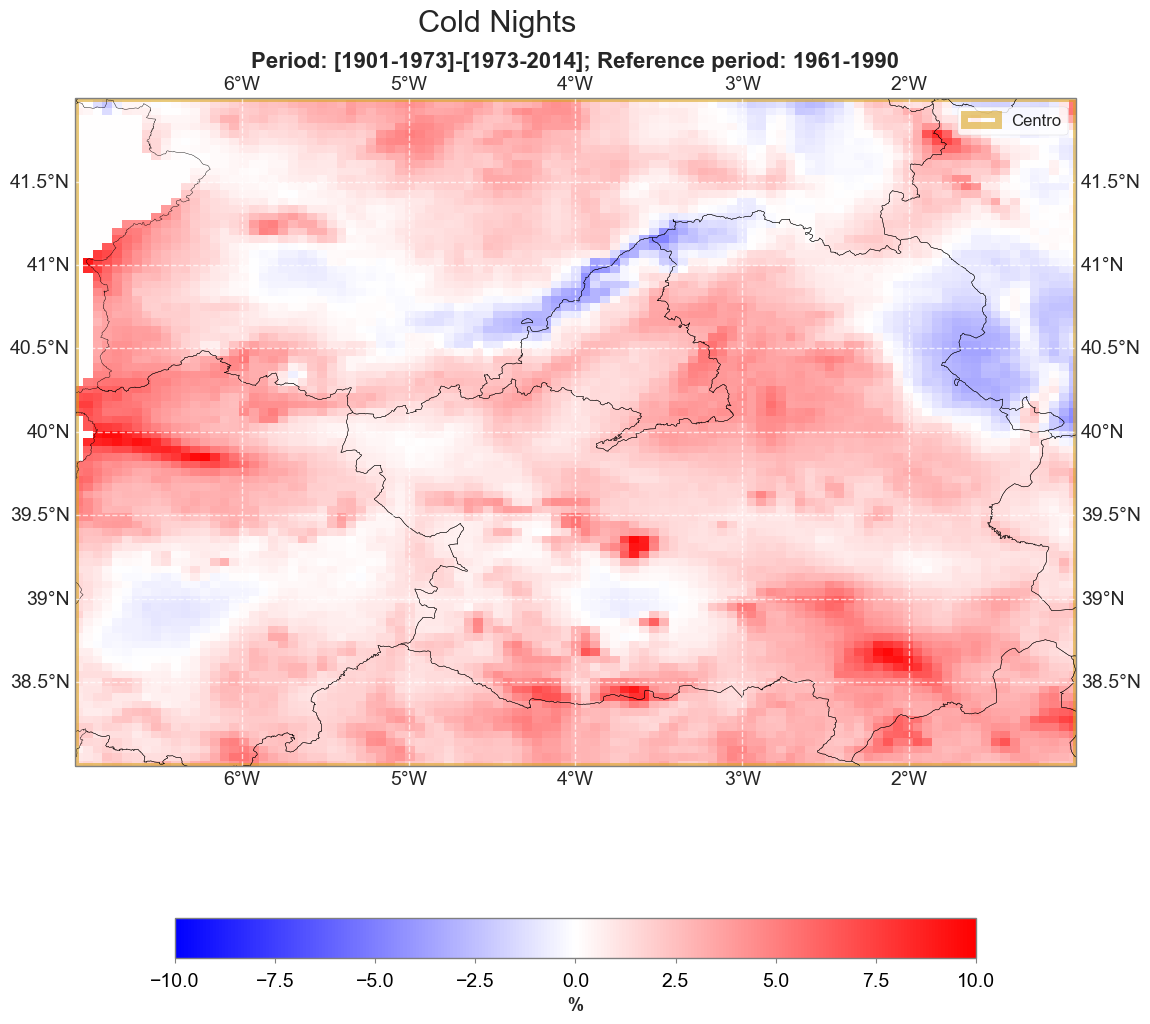

In [484]:
# Downloaded from http://biogeo.ucdavis.edu/data/gadm2/shp/DEU_adm.zip
fname = './Codigos/Diego/mapas/gadm41_ESP_1.shp'

adm1_shapes = list(shpreader.Reader(fname).geometries())

fig, ax = plt.subplots(figsize=(12,12), ncols=1)
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
plt.suptitle('Cold Nights',size=22)
plt.title('Period: [1901-1973]-[1973-2014]; Reference period: 1961-1990',size=16)
ax.set_global() # added following an answer to my question
#ax.gridlines()
ax.gridlines(draw_labels = True,linestyle='--',alpha=0.7,zorder=1)
ax.set_extent([-9.8,5,35.5,44], ccrs.PlateCarree())
cmap = 'bwr'
var3 = var1-var2
im = ax.pcolormesh(var3.lon,var3.lat,var3.squeeze(),cmap=cmap,vmin=-10, vmax=10, transform =ccrs.PlateCarree()) 
cbar = fig.colorbar(im,ax=ax,orientation = 'horizontal',shrink=0.8)
cbar.set_label(label=f'%',size=13)
cbar.ax.set_xlim(-10, 10)
pinta_region([38, 42],[-7, -1],'goldenrod',ax,label='Centro')
ax.coastlines(resolution='10m')#, linewidth=2)
ax.add_geometries(adm1_shapes, ccrs.PlateCarree(), # Cuidado con los sistemas de coordenadas, esto esta definido solo para este sistema
                  edgecolor='black', facecolor='None', alpha=1)
ax.set_ylim(38,42)
ax.set_xlim(-7,-1)
ax.legend(prop={'size':12})
plt.tight_layout()

/Users/cova/opt/anaconda3/envs/covaconda/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/cova/opt/anaconda3/envs/covaconda/lib/python3.7/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/cova/opt/anaconda3/envs/covaconda/lib/python3.7/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


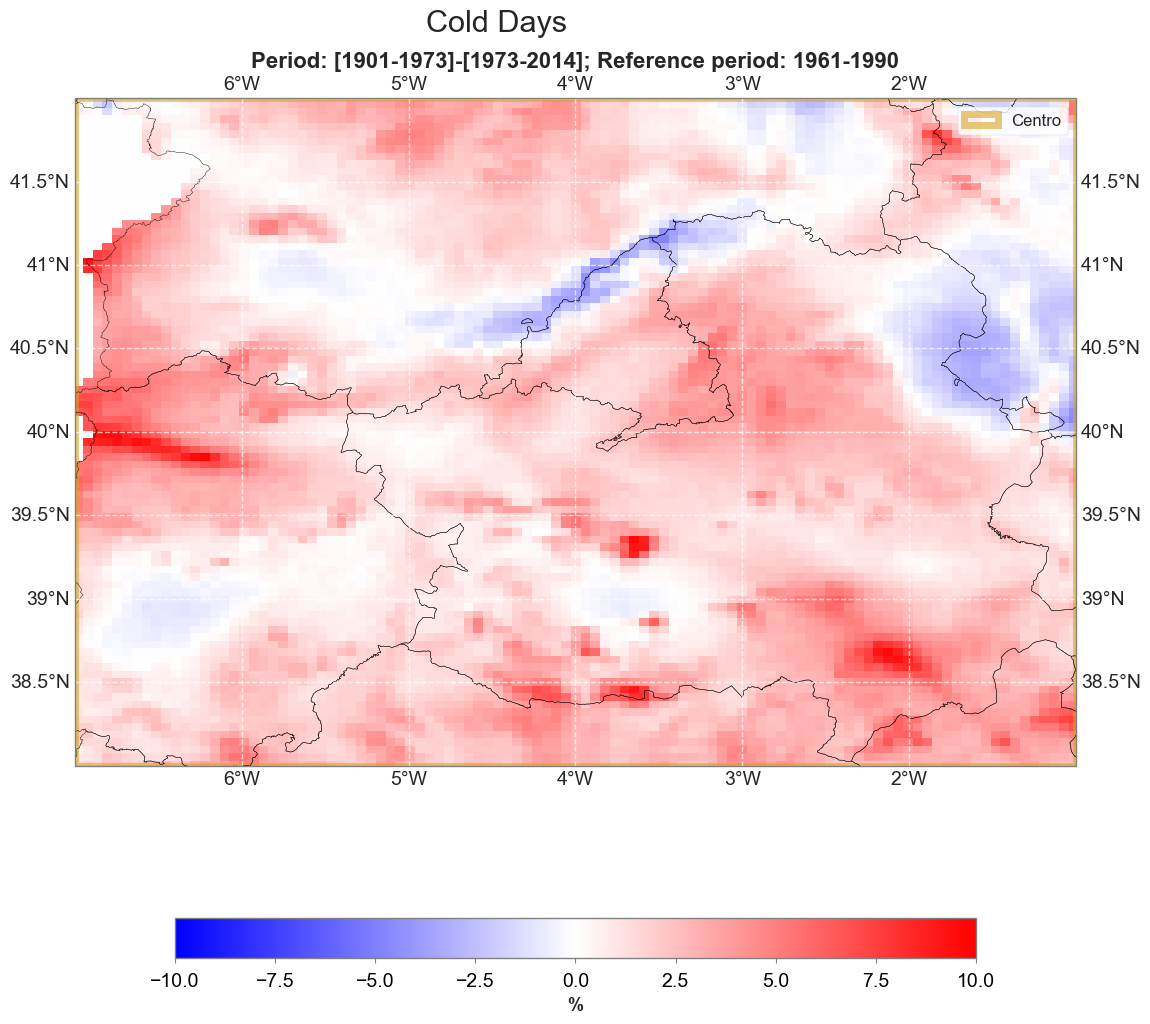

In [485]:
# Downloaded from http://biogeo.ucdavis.edu/data/gadm2/shp/DEU_adm.zip
fname = './Codigos/Diego/mapas/gadm41_ESP_1.shp'

adm1_shapes = list(shpreader.Reader(fname).geometries())
var1 = percent_cold_days_C[:73,:,:].mean(dim='time')
var2 = percent_cold_days_C[73:].mean(dim='time')
fig, ax = plt.subplots(figsize=(12,12), ncols=1)
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
plt.suptitle('Cold Days',size=22)
plt.title('Period: [1901-1973]-[1973-2014]; Reference period: 1961-1990',size=16)
ax.set_global() # added following an answer to my question
#ax.gridlines()
ax.gridlines(draw_labels = True,linestyle='--',alpha=0.7,zorder=1)
ax.set_extent([-9.8,5,35.5,44], ccrs.PlateCarree())
cmap = 'bwr'
var3 = var1-var2
im = ax.pcolormesh(var3.lon,var3.lat,var3.squeeze(),cmap=cmap,vmin=-10, vmax=10, transform =ccrs.PlateCarree()) 
cbar = fig.colorbar(im,ax=ax,orientation = 'horizontal',shrink=0.8)
cbar.set_label(label=f'%',size=13)
cbar.ax.set_xlim(-10, 10)
pinta_region([38, 42],[-7, -1],'goldenrod',ax,label='Centro')
ax.coastlines(resolution='10m')#, linewidth=2)
ax.add_geometries(adm1_shapes, ccrs.PlateCarree(), # Cuidado con los sistemas de coordenadas, esto esta definido solo para este sistema
                  edgecolor='black', facecolor='None', alpha=1)
ax.set_ylim(38,42)
ax.set_xlim(-7,-1)
ax.legend(prop={'size':12})
plt.tight_layout()

In [486]:
#fig.savefig('cold_nights.png',dpi=600,facecolor='w')

---

----

---

# <CENTER> NOCHE FRÍAS Y DÍAS FRÍOS <CENTER>

---

---

---

Ahora las series temporales:

In [487]:
from matplotlib import style

def series_style():
    plt.style.use('seaborn') # Estilo general

    font = {'size'   : 14}
    plt.rc('font', **font) # Tamaño generico de fuentes
    parameters = {'xtick.labelsize':14,
                'ytick.labelsize':14,
                'axes.labelsize':14,
                'axes.labelweight':'bold',
                'axes.titleweight':'bold',
                'axes.titlesize':18,
                'legend.fontsize':15,
                'legend.frameon':True,
                'legend.facecolor':'w',
                'legend.title_fontsize':16,
                'ytick.major.size': 3.5,
                'ytick.major.width': 0.8,
                'xtick.major.size': 3.5,
                'xtick.major.width': 0.8,  
                'axes.linewidth':1,
                'axes.edgecolor':'grey',
                'xtick.color':'grey',
                'xtick.labelcolor':'k',
                'ytick.color':'grey',
                'ytick.labelcolor':'k'}
    plt.rcParams.update(parameters)

Hay que corregirlas, volver a poner los nan en las zonas de océano (si no se infravalora el porcentaje):

In [488]:
def correct_series(percent,tmin=tmin,freq='YS'):
    '''El objetivo de esta función es volver a colocar los np.nan en las posiciones del cuadrado de lat y lon donde 
    no tenemos datos. Al calcular el índice de extremos esos puntos han quedado con 0. Esto hace que al promediar esas
    dimensiones infraestimemos la media'''
    tmin = tmin.rename({'Time': 'time'})
    if freq=='YS':
        tminR = tmin.sel(lat=slice(float(np.nanmax(percent.lat)),float(np.min(percent.lat))),lon=slice(float(np.min(percent.lon)),float(np.max(percent.lon))),time=slice(str(int(np.min(percent.time.dt.year))),str(int(np.max(percent.time.dt.year)))))
        tminR_year = tminR.sel(time=((tminR.time.dt.month == 6) & (tminR.time.dt.day == 1)))
        corr_R = np.where(np.isnan(tminR_year),np.nan,percent)
        corr_R_x = xr.DataArray(corr_R,coords={'time': percent.time, 'y': percent.lat,'x': percent.lon},dims=['time','lat','lon'])
        result = corr_R_x.mean(dim=['lon','lat'])


    if freq=='MS':
        tminR = tmin.sel(lat=slice(float(np.nanmax(percent.lat)),float(np.min(percent.lat))),lon=slice(float(np.min(percent.lon)),float(np.max(percent.lon))),time=slice(str(int(np.min(percent.time.dt.year))),str(int(np.max(percent.time.dt.year)))))
        tminR_year = tminR.sel(time=(tminR.time.dt.day == 10))
        corr_R = np.where(np.isnan(tminR_year),np.nan,percent)
        corr_R_x = xr.DataArray(corr_R,coords={'time': percent.time, 'y': percent.lat,'x': percent.lon},dims=['time','lat','lon'])

        result = corr_R_x.mean(dim=['lon','lat'])

    return result

In [489]:
corr_C = correct_series(percent_cold_nights_C)
corr_C_d = correct_series(percent_cold_days_C)

In [490]:
#fig.savefig('series_reg.png',dpi=600,facecolor='w')

---

# CENTRO

---

In [491]:
tminCm = tminC.mean(dim=['lon','lat'],keep_attrs=True)
tminCm = tminCm.rename({'Time': 'time'})
tminCm.attrs['units'] = 'degC'
baseC = tminCm.sel(time=slice('1961','1990'))
tas_perm = percentile_doy(baseC, per=10).sel(percentiles=10)
cold_daysm = tn10p(tminCm.sel(time=slice('1901','2014')), tas_perm)
perm = cold_daysm/365*100


---

# AJUSTE GEV Y GPD Y VALORES DE RETORNO

---

In [492]:
def nor(mu,sigma,x):
    #Nota: también podrías usar la función norm.pdf(x,k) del módulo stats del paquete scipy
    N=1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2))
    return N

def GEV(x,c):
    #Función que calcula la función densidad de probabilidad de Generalized Extrem Value normalizada
    # con m = 0, s = 1
    #nota: también puedes usar g=stats.genextreme.pdf(x,-c)
    if ( abs(c) < 0.005 ) :
        g = np.exp(-np.exp(-x))*np.exp(-x)
    else:
        g = ( np.power( 1 + c * x , -1-1/c) ) * np.exp( - np.power(1 + c * x ,-1/c) )
    return g

def GEVms(x,c,m,s):
    #Función que calcula la función de densidad de probabilidad Generalizada Extreme Value sin normalizar
    y = ( x - m ) / s
    if ( abs(c) < 0.005 ) :
        g = ( np.exp(-np.exp(-y))*np.exp(-y) ) / s
    else:
        g = ( np.power( 1 + c * y , -1-1/c) ) * np.exp( - np.power(1 + c * y ,-1/c) ) / s
    return g

def GPDs(y,c,s):
    #Función que calcula la función de densidad de probabilidad de Pareto Generalizada 
    if (abs(c)<0.0001):
        h = np.exp(-y/s)*(1/s)
    else:
        h = (1/s) * ( 1 + c * y / s) ** (-1-1/c)
    h[y<=0]=0
    return h

def MLE_GEV(c,m,s,x):
    #Función que calcula la función likelihood sobre GEV con 
    #los parámetros de entrada c,m,s
    #y la muestra de datos x
    if ( (s < 0) | np.any(1 + c * (x-m)/s ) < 0):
        sal=1e7
    else:            
        if (abs(c) > 0.00001 ):
            t = (1 + c * (x-m)/s )**(-1/c)
        else :
            t = np.exp(-(x-m)/s)
        f = - np.log(s) + (c +1)*np.log(t) -t
        sal = f.sum()
    return -sal


def returnLevel(p, c,m,s):
    if (abs(c) > 0.00001 ):
        zp = m - ( s / c ) * ( 1 - ( - np.log( 1 - p ) ) ** ( - c ))
    else :
        zp = m - s * np.log( - np.log( 1 - p ) )
    return zp


def densityPlotGEV(ax,x,c,m,s):
    n, bins, dummy = ax.hist(x,density=True,label='Empirica')
    x1, x2 = 2*bins[0] - bins[1], 2* bins[-1] - bins[-2]
    ax.set_xlim(x1,x2)
    x_x = np.linspace(x1,x2,200)
    y_y = GEVms(x_x,c,m,s)
    ax.plot(x_x,y_y,'r',label='Ajuste')
    ax.legend()
    ax.grid()
    ax.set_ylabel('probabilidad f(z)')
    ax.set_xlabel('z')
    return

def probabilityPlot(ax,pExp,pTeor):
    ax.plot([0,1],[0,1])
    ax.plot(pExp,pTeor,'o')
    ax.set_ylabel('Model')
    ax.set_xlabel('Empirical')
    ax.set_title('Probability plot',fontsize=25)
    ax.grid()
    return

def quantilePlot(ax,xTeor,xSort):
    xTeor = -xTeor
    xSort = -xSort
    ax.plot([xSort[0],xSort[-1]],[xSort[0],xSort[-1]])
    ax.plot(xTeor,xSort,'o')
    ax.set_ylabel('Model')
    ax.set_xlabel('Empirical')
    ax.set_title('Quantile plot',fontsize=25)
    ax.grid()
    return

def returnPlot(ax,p,zp,pExp,xSort):
    ax.semilogx(1/p,-zp)
    ax.grid()
    ax.set_xlim(1e-1,1e3)
    ax.semilogx(1/pExp,-xSort,'o')
    ax.set_title('Return level plot',fontsize=25)
    ax.set_xlabel('Return period (years)')
    ax.set_ylabel('Return level')
    return
    
def diagnosticsGEV(x,c,m,s):
    y = (x-m)/s
    ySort = np.sort(y)
    pExp = np.arange(1,ySort.size+1,1)/(ySort.size+1)
    pTeor = stats.genextreme.cdf(ySort,-c)
    xSort = np.sort(x)
    pExp = np.arange(1,xSort.size+1,1)/(xSort.size+1)
    pExpinv = np.arange(xSort.size+1,1,-1)/(xSort.size+1)
    xTeor = returnLevel(1-pExp, c,m,s)    
    p = np.logspace(-2, -1e-2, 100)
    zp=returnLevel(p,c,m,s)
    fig, ax = plt.subplots(2, 2, figsize=(14,10))
    probabilityPlot(ax[0,0],pExp,pTeor)
    quantilePlot(ax[0,1],xTeor,xSort)
    returnPlot(ax[1,0],p,zp,pExpinv,xSort)
    densityPlotGEV(ax[1,1],x,c,m,s)
    fig.suptitle('Diagnostics',weight='bold',fontsize=25)
    
    return 

def diagnosticsGPD(x,c,m,s,numYears,invert=False):
    fig, ax = plt.subplots(2, 2, figsize=(20,15))
    fig.suptitle('Diagnostics',weight='bold',fontsize=18)
    xSort = np.sort(x)
    pExp = np.arange(1,xSort.size+1,1)/(xSort.size+1)
    pExpinv = np.arange(xSort.size+1,1,-1)/(xSort.size+1)
    rv = stats.genpareto(c,m,s)
    pTeor = rv.cdf(xSort)
    xTeor = rv.ppf(pExp)
    fac = x.size / numYears
    p = np.logspace(-4, 2 , 100)
    zp = rv.ppf(1-p)
    fac = x.size / numYears
    returnPlot(ax[1,0],p*fac,zp,pExpinv*fac,xSort)
    probabilityPlot(ax[0,0],pExp,pTeor)
    quantilePlot(ax[0,1],xTeor,xSort)
    densityPlotGPD(ax[1,1],x,c,m,s)
    fig.tight_layout
    return (fig,ax)

def densityPlotGPD(ax,x,c,m,s):
    n, bins, dummy = ax.hist(-x,density=True,label='Empirica')
    x1, x2 = 2*bins[0] - bins[1], 2* bins[-1] - bins[-2]
    ax.set_xlim(x1,x2)
    x_x = np.linspace(x1,x2,200)
    y_y = stats.genpareto.pdf(-x_x,c,m,s)
    ax.plot(x_x,y_y,'r',linewidth = 4, label='Ajuste')
    ax.legend()
    ax.grid()
    ax.set_ylabel('probabilidad h(x)')
    ax.set_xlabel('x')
    ax.set_title('Density plot',fontsize=25)
    return
  

def readDataFrame(stationName):
    url = 'isd-history.csv'
    c=pd.read_csv(url)

    #Seleccionamos los años de inicio y final de lectura
    yearInit = 1973
    yearEnd = 2020

    #Construimos el código que necesitamos para bajar los datos de la estación:
    station=str(c.loc[(c['STATION NAME']==stationName)]['USAF'].values[0]) + '-' + \
            str(c.loc[(c['STATION NAME']==stationName)]['WBAN'].values[0])
    print('Seleccionada la estacion ' + stationName + ' con código ' + station)

    #Definimos las columnas y el tipo de dato que va a tener el DataFrame donde vamos a alojar los datos de la estación
    colNames=['year','month','day','hour','temp','tempd','slp','windDir','windSpeed','cloud','pcp1h','pcp6h']
    dataType=['int','int','int','int','float','float','int','int','int','int','int','int',]

    #Definimos los límites de los caractéres donde están los datos en los archivos que vamos a leer 
    #(Esta información está en: https://www.ncei.noaa.gov/pub/data/noaa/isd-lite/isd-lite-format.txt)
    limits=[(0,4),(5,7),(8,10),(11,13),(14,19),(20,25),(26,31),(32,37),(38,43),(44,49),(50,55),(56,61)]
    
    #Lectura de los datos:
    df=pd.DataFrame(columns=colNames)
    for iyr in range(yearInit, yearEnd, 1):
        fil='https://www.ncei.noaa.gov/pub/data/noaa/isd-lite/'+str(iyr)+'/'+station +'-'+ str(iyr)+'.gz'
        data= pd.read_fwf(fil,sep=' ',compression='gzip',head=0,
                     names=colNames,colspecs=limits)
        df = df.append(data)

    #Cambio el tipo de dato (porque los lee como objetos str y queremos que sean numéricos)
    dictType={ colNames[i] : dataType[i] for i in range(12)}
    data = df.astype(dictType,copy=True)
    #Los datos missing son -9999 en la base de datos: cambiamos por NaN:
    data = data.replace(-9999,np.NaN)
    
    dataDailyMax = data.groupby(['year','month','day']).max().drop(['hour'],axis=1).reset_index()
    dataDailyMax['time'] = pd.to_datetime(dataDailyMax[['year','month','day']],yearfirst=True)
    dataDailyMax = dataDailyMax.set_index('time')
    dataDailyCum = data.groupby(['year','month','day']).sum().drop(['hour'],axis=1).reset_index()
    dataDailyCum['time'] = pd.to_datetime(dataDailyCum[['year','month','day']],yearfirst=True)
    dataDailyCum = dataDailyCum.set_index('time')
    dataDailyMean = data.groupby(['year','month','day']).mean().drop(['hour'],axis=1).reset_index()
    dataDailyMean['time'] = pd.to_datetime(dataDailyMean[['year','month','day']],yearfirst=True)
    dataDailyMean = dataDailyMean.set_index('time')
    return dataDailyMax

In [493]:
tminC_mean=tminC.mean(dim=['lat','lon'])
tminC_mean

<xarray.DataArray 'tn' (Time: 41638)>
array([-0.01575048, -0.02515711, -1.0553304 , ..., -2.0005674 ,
       -3.083975  , -2.717234  ], dtype=float32)
Coordinates:
  * Time     (Time) datetime64[ns] 1901-01-02 1901-01-03 ... 2015-01-01

In [494]:
tmaxC_mean=tmaxC.mean(dim=['lat','lon'])
tmaxC_mean

<xarray.DataArray 'tx' (Time: 41638)>
array([11.013667 , 10.3119   ,  8.835545 , ...,  6.994769 ,  8.1382475,
       10.5095825], dtype=float32)
Coordinates:
  * Time     (Time) datetime64[ns] 1901-01-02 1901-01-03 ... 2015-01-01

c=-0.196
m=-8.827
s=2.038
u=-8.827
100yr-return value=5.081


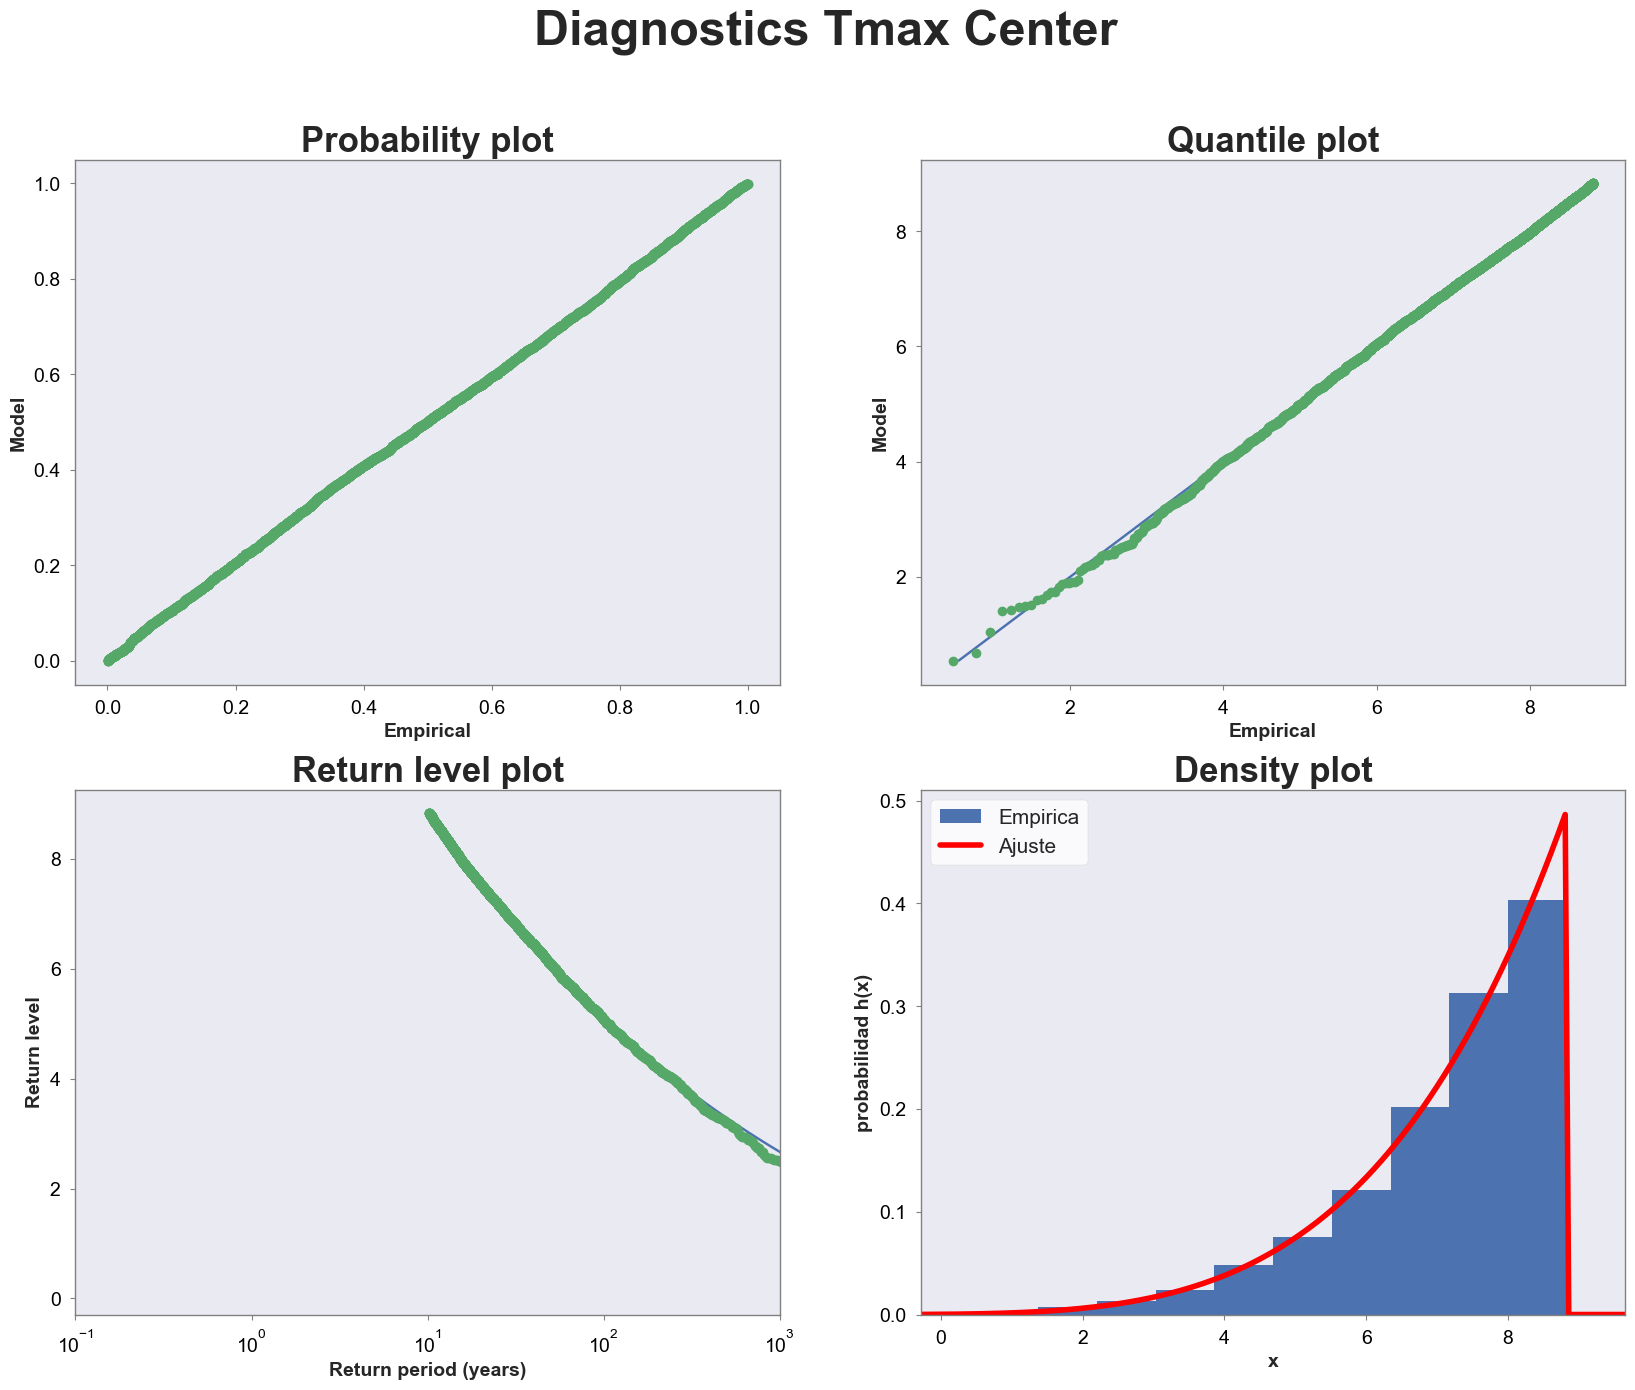

In [495]:
#Seleccion del umbral: cogeremos el percentil 10
x=-tmaxC_mean.copy()
xSort = np.sort(x)
pExp = np.arange(1,xSort.size+1,1)/(xSort.size+1)
xLess= xSort[pExp<=.9]
u= xLess[-1] +.05
yExt = x[x>u].copy()  

#Ajuste usando herramienta de scipy:
c, m, s = stats.genpareto.fit(yExt,floc = u)

numYears=x.size
N = 100;
fac = yExt.size/numYears
rv = stats.genpareto(c,m,s)
zp = rv.ppf(1-1/N/fac)

#Diagnóstico:
fig,ax=diagnosticsGPD(yExt,c,m,s,numYears,True)
fig.suptitle('Diagnostics Tmax Center',weight='bold',fontsize=35)
print('c='+'%.3f'%(c))
print('m='+'%.3f'%(m))
print('s='+'%.3f'%(s))
print('u='+'%.3f'%(u))
print('100yr-return value='+'%.3f'%(-zp))

c=-0.144
m=0.222
s=1.650
u=0.222
100yr-return value=-3.419


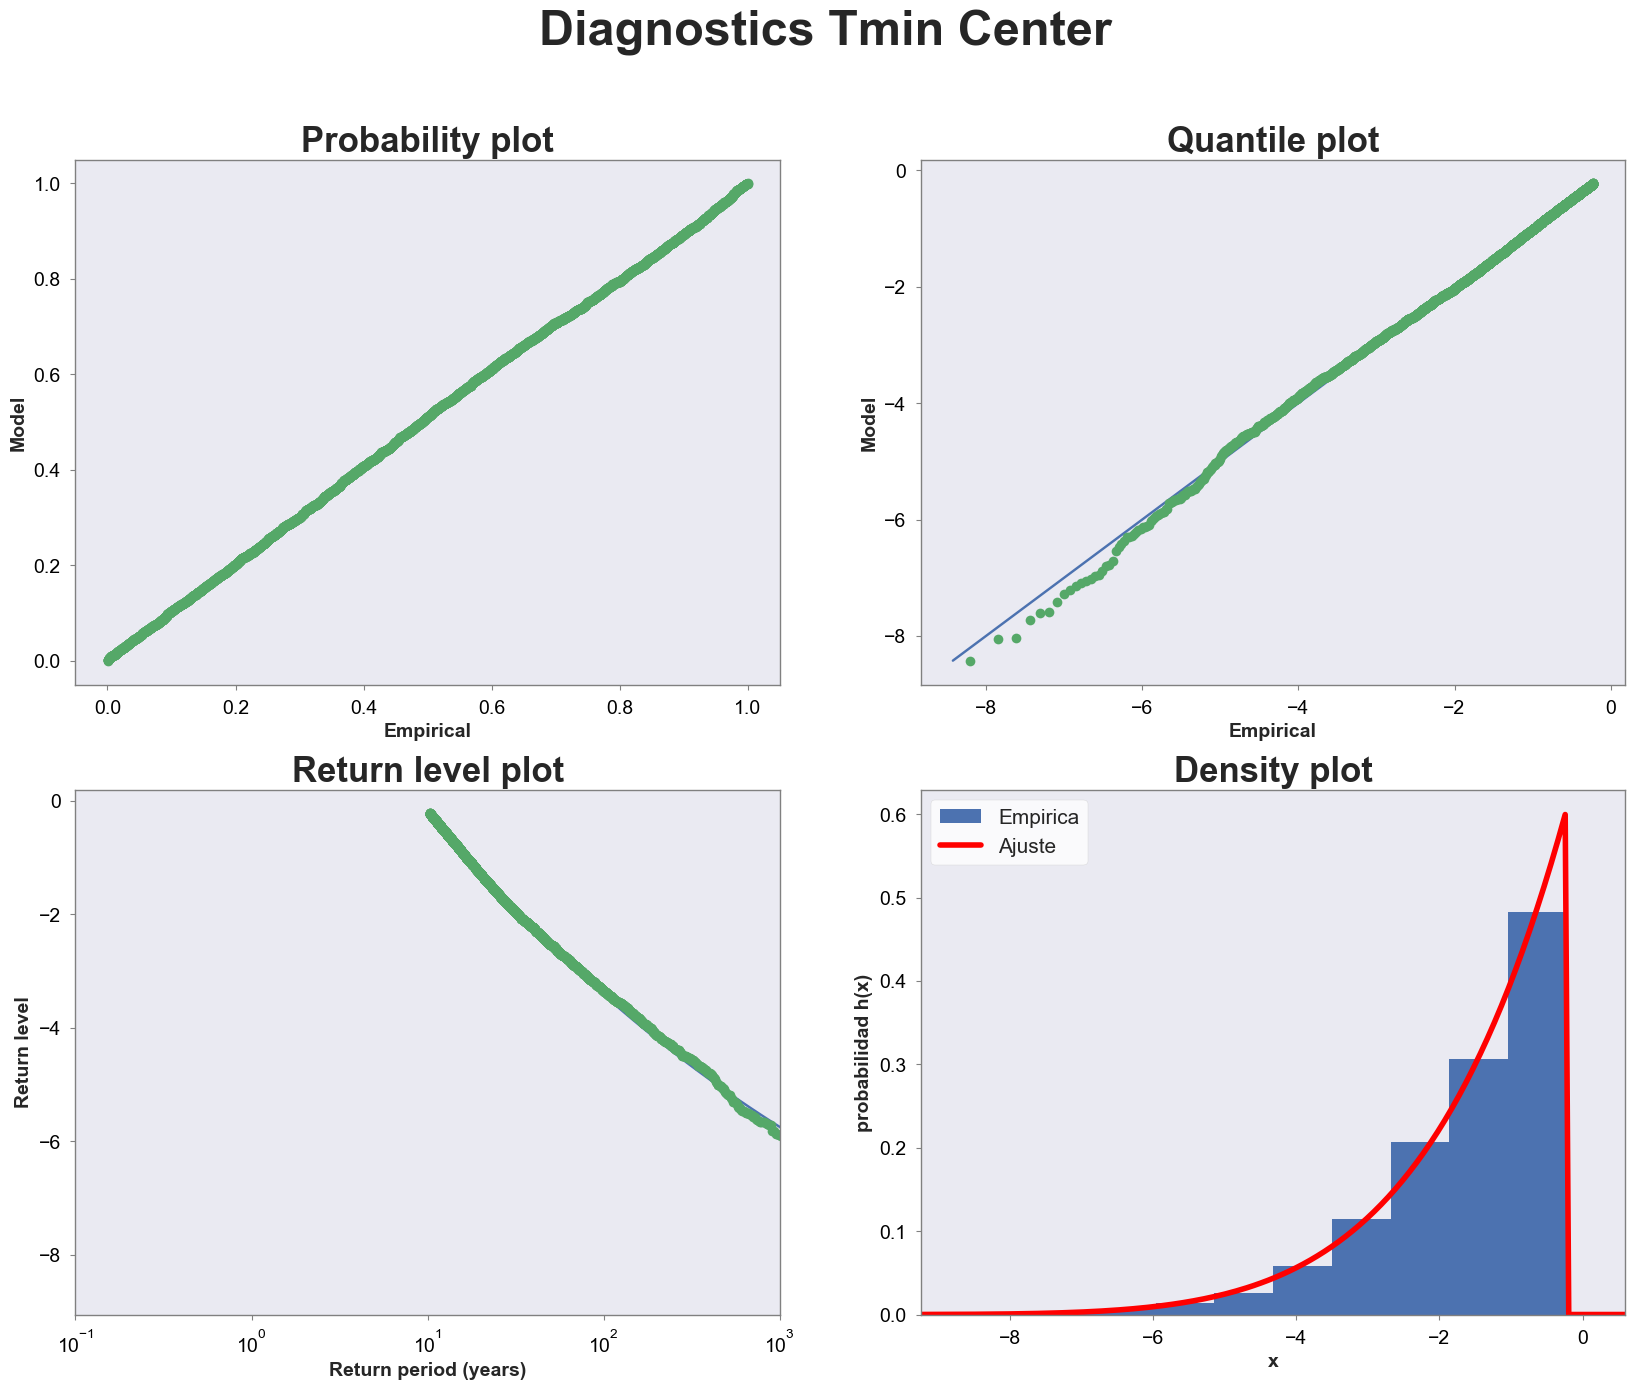

In [496]:
#Seleccion del umbral: cogeremos el percentil 10
x=-tminC_mean.copy()
xSort = np.sort(x)
pExp = np.arange(1,xSort.size+1,1)/(xSort.size+1)
xLess= xSort[pExp<=.9]
u= xLess[-1] +.05
yExt = x[x>u].copy()  

#Ajuste usando herramienta de scipy:
c, m, s = stats.genpareto.fit(yExt,floc = u)

numYears=x.size
N = 100;
fac = yExt.size/numYears
rv = stats.genpareto(c,m,s)
zp = rv.ppf(1-1/N/fac)

#Diagnóstico:
fig,ax=diagnosticsGPD(yExt,c,m,s,numYears,True)
fig.suptitle('Diagnostics Tmin Center',weight='bold',fontsize=35)
print('c='+'%.3f'%(c))
print('m='+'%.3f'%(m))
print('s='+'%.3f'%(s))
print('u='+'%.3f'%(u))
print('100yr-return value='+'%.3f'%(-zp))

---

# FRECUENCIAS FUNDAMENTALES: PERIODOGRAMAS

---

Los periodogramas sirven para identificar las frecuencias clave si las hay de una serie temporal. A partir del periodograma se puede ver si sobresale algún pico de la serie. En el eje de abcisas se encuentra la frecuencia discreta del periodograma y en el eje de ordenadas los valores correspondientes a la potencia o a la amplitud espectral de cada frecuencia discreta. 


El periodograma de una secuencia es simplemente la transformada discreta de Fourier.

In [497]:
def runningMean(x,T):
    y = x.copy() * np.NaN
    N = x.size
    ini = int((T-1)/2)
    fin = int(T/2)
    for i in range(ini,N-fin):
        y[i] = np.mean(x[i-ini:i+fin+1])
    return y


def espectroArmonico(x,At):
    x = np.squeeze(np.array(x))
    N = x.size 
    xm = x.mean()
    Nmax = int(N/2) if (N % 2) == 0 else int((N-1)/2)
    jvec=np.arange(1,N+1)
    a = np.zeros(Nmax)
    b = np.zeros(Nmax)
    xa = x-xm
    fac = 2*np.pi*jvec/N
    for k in range(Nmax):
        a[k] = 2 / N * np.sum( np.matmul(xa,np.cos(fac*(k+1)) ))
        b[k] = 2 / N * np.sum( np.matmul(xa,np.sin(fac*(k+1)) ))
    if (N%2)==0: b[Nmax-1]=0
    kvec = np.arange(1,Nmax+1)
    # Habría que dividir entre 4, pero como sólo damos la parte positiva, para
    # que la suma de G nos aporte la varianza dividimos sólo entre 2
    G = ( a**2+b**2 ) / 2
    f = kvec/(N*At)
    return f,G

def espectroFFT(x,At):
    x = np.squeeze(np.array(x))
    N=x.size
    Nmax = int(N/2) if (N % 2) == 0 else int((N-1)/2)
    y = fft(x)
    ap = 2/N*np.real(y[1:Nmax+1])
    bp =  - 2/N*np.imag(y[1:Nmax+1])
    xm = np.mean(x)
    kvec = np.arange(1,Nmax+1)
    # Habría que dividir entre 4, pero como sólo damos la parte positiva, para
    # que la suma de G nos aporte la varianza dividimos sólo entre 2
    G = ( ap**2+bp**2 ) / 2
    f = kvec/(N*At)
    return f,G

def redSpectra(a,s2):
    f = np.arange(.0,.51,.01)
    N = f.size
    G = (s2*(1-a**2))/(1+a**2-2*a*np.cos(2*np.pi*f))
    #Hay que multiplicar por 2 porque sólo sacamos la parte positiva
    return f,2*G

def ajusteArmonico(x,numArm):
    x = np.squeeze(np.array(x))
    N = x.size 
    xm = x.mean()
    Nmax = int(N/2) if (N % 2) == 0 else int((N-1)/2)
    jvec=np.arange(1,N+1)
    a = np.zeros(Nmax)
    b = np.zeros(Nmax)
    xa = x-xm
    fac = 2*np.pi*jvec/N
    for k in range(Nmax):
        a[k] = 2 / N * np.sum( np.matmul(xa,np.cos(fac*(k+1)) ))
        b[k] = 2 / N * np.sum( np.matmul(xa,np.sin(fac*(k+1)) ))
    if (N%2)==0: b[Nmax-1]=0
    kvec = np.arange(1,Nmax+1)
    xhat = np.zeros(N)
    n = np.min([numArm,Nmax])
    for j in range(N):
        xhat[j] =  xm + np.sum( a[:n] * np.cos (2*np.pi*kvec[:n]*(j+1)/N) + b[:n] *
                               np.sin (2*np.pi*kvec[:n]*(j+1)/N) )
    return xhat,a,b

def ajusteArmonicoFFT(x,numArm):
    x = np.squeeze(np.array(x))
    N=x.size
    Nmax = int(N/2) if (N % 2) == 0 else int((N-1)/2)
    y = fft(x)
    ap = 2/N*np.real(y[1:Nmax+1])
    bp =  - 2/N*np.imag(y[1:Nmax+1])
    xm = np.mean(x)
    kvec = np.arange(1,Nmax+1)
    xhat = np.zeros(N)
    n = np.min([numArm+1,Nmax])
    for j in range(N):
        xhat[j] =  xm + np.sum( ap[:n] * np.cos (2*np.pi*kvec[:n]*(j)/N) + bp[:n] * 
                               np.sin (2*np.pi*kvec[:n]*(j)/N) )
    return xhat,ap,bp

def calculoAR1(x):
    xm = np.mean(x)
    N = x.size
    cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
    a = cor[1]
    sx = np.std(x, ddof=1)
    fac = np.sqrt((N-1)/(N-2)*(1-a**2))*sx
    AR1 = x * np.NaN
    rng = np.random.default_rng()
    Z = rng.normal(0,1,N)
    #También podéis generar el ruido blanco con stats de scipy
    #Z = stats.norm.rvs(size=N)
    AR1[0] = Z[0]
    for i in range(N-1):
        AR1[i+1] =  a * ( AR1[i] ) + fac * Z[i+1]
    return AR1 + xm


def calculoAutocov(x,nlag):
    cov = np.zeros([nlag+1])
    N = x.size
    xm = np.mean(x)
    ax = x-xm
    for t in range(nlag+1):
        cov[t] = np.sum(ax[:N-t]*ax[t:])/(N-1)
    return cov

def region(sst,lonmin, lonmax, latmin, latmax):
    reg = sst[:,:,(lon>lonmin)&(lon<lonmax)][:,(lat>latmin)&(lat<latmax),:].mean(axis=(1,2))
    nt = reg.size
    nm = 12
    ny = int(nt/nm)
    reg = reg.reshape(nm,ny,order='F')
    mreg = np.nanmean(reg,axis=1)
    anom = reg.copy()*np.NaN
    for i in range(ny):
        for j in range(nm):
            anom[j,i] = reg[j,i] - mreg[j]
    return anom

La varianza de la serie es  1.0
La integral del espectro es  1.00028846939409
La varianza de la serie es  0.9999999999999999
La integral del espectro es  1.0001696785059773


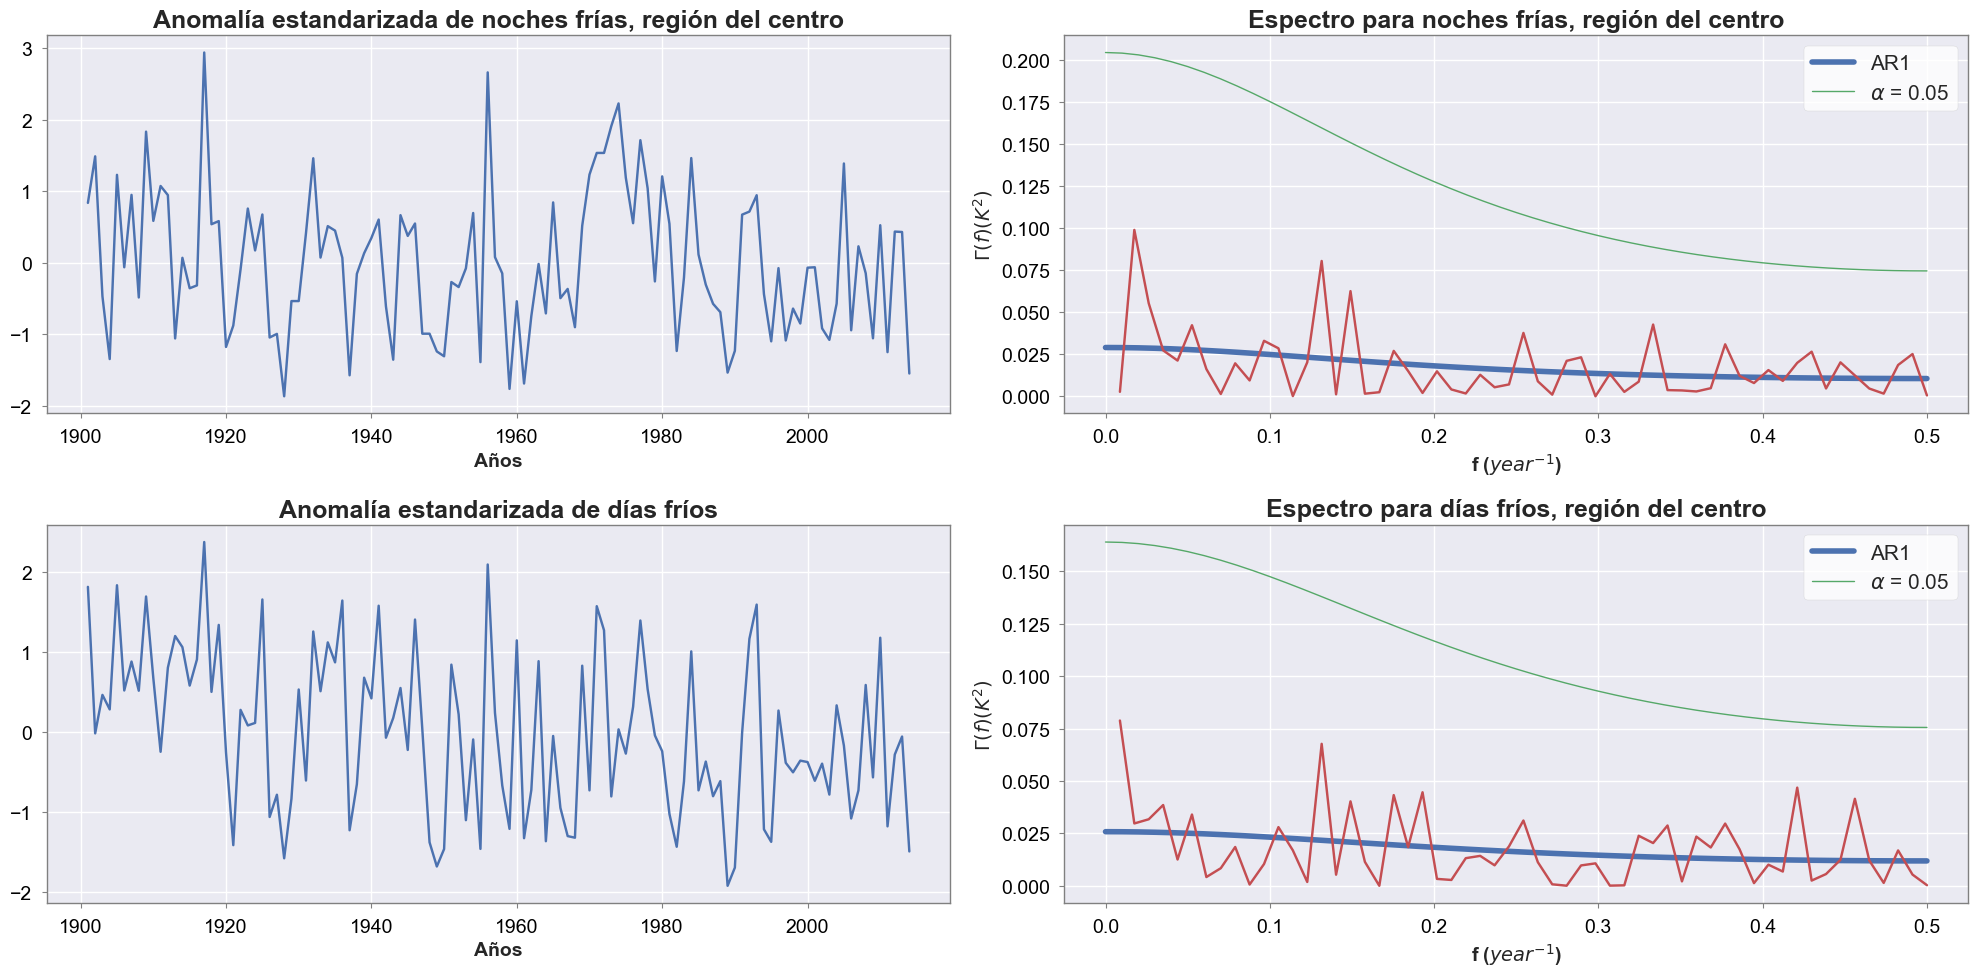

In [498]:
fig,ax=plt.subplots(2,2,figsize=(20,10))
eje_x=np.arange(1901,2014+1)
años=eje_x
################## DIAS FRIOS ##################
anomalia_std_noches_frias=(corr_C-np.mean(corr_C))/np.std(corr_C)

ax[0,0].plot(eje_x,anomalia_std_noches_frias)
ax[0,0].set_title('Anomalía estandarizada de noches frías, región del centro')
ax[0,0].set_xlabel(u'Años')

x = np.squeeze(np.array(anomalia_std_noches_frias))
#Veamos si los picos sobresalen lo suficiente:
alpha = 0.05
alphaS = alpha / Gf.size
nu = 2
chi2 = stats.chi2.ppf(1-alphaS,2)
s2 = np.var(x)
cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
a = cor[1]
f,G = redSpectra(a,s2)
ax[0,1].plot(f,G/x.size,linewidth=4,label='AR1')
Gmax = G/x.size/nu*chi2
ax[0,1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = '+str(alpha))
a,s2,chi2
ax[0,1].legend()
ff,Gf = espectroFFT(x,1)
ax[0,1].plot(ff,Gf,label='fft')
ax[0,1].set_ylabel(r'$\Gamma(f) (K^2)$')
ax[0,1].set_xlabel(r'f ($year^{-1}$)')
ax[0,1].set_title('Espectro para noches frías, región del centro')

print('La varianza de la serie es ',np.var(x))
print('La integral del espectro es ',sum(Gf))


################## NOCHES FRIAS ##################
anomalia_std_dias_frios=(corr_C_d-np.mean(corr_C_d))/np.std(corr_C_d)
ax[1,0].plot(eje_x,anomalia_std_dias_frios)
ax[1,0].set_title('Anomalía estandarizada de días fríos')
ax[1,0].set_xlabel(u'Años')

x = np.squeeze(np.array(anomalia_std_dias_frios))
#Veamos si los picos sobresalen lo suficiente:
alpha = 0.1
alphaS = alpha / Gf.size
nu = 2
chi2 = stats.chi2.ppf(1-alphaS,2)
s2 = np.var(x)
cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
a = cor[1]
f,G = redSpectra(a,s2)
ax[1,1].plot(f,G/x.size,linewidth=4,label='AR1')
Gmax = G/x.size/nu*chi2
ax[1,1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = 0.05')
a,s2,chi2
ax[1,1].legend()
ff,Gf = espectroFFT(x,1)
ax[1,1].plot(ff,Gf,label='fft')
ax[1,1].set_ylabel(r'$\Gamma(f) (K^2)$')
ax[1,1].set_xlabel(r'f ($year^{-1}$)')
ax[1,1].set_title('Espectro para días fríos, región del centro')

print('La varianza de la serie es ',np.var(x))
print('La integral del espectro es ',sum(Gf))



fig.tight_layout()

Vamos a hacerlo mensual

In [499]:
tmax_C = tmax.sel(lon=slice(-7,-1),lat=slice(42,38))
tmax2_C = tmax_C.rename({'Time': 'time'})
tmax2_C.attrs['units'] = 'degC'
try: 
    num_cold_days_C_m = xr.open_dataarray('./Codigos/Diego/outs/tmax_p10_C_m_full.nc')
except: 
    num_cold_days_C_m = tx10p(tmax2_C.sel(time=slice('1901','2014')),tmax_p10_C,freq='MS') #.mean(dim=['lon','lat'])
    num_cold_days_C_m.to_netcdf('./Codigos/Diego/outs/tmax_p10_C_m_full.nc')

In [500]:
tmin_C = tmin.sel(lon=slice(-7,-1),lat=slice(42,38))
tmin_C = tmin_C.rename({'Time': 'time'})
tmin_C.attrs['units'] = 'degC'
try: 
    num_cold_nights_C_m = xr.open_dataarray('./Codigos/Diego/outs/percent_cold_nights_C_m_FULL.nc')
except: 
    num_cold_nights_C_m = tx10p(tmin_C.sel(time=slice('1901','2014')),tmin_p10_C,freq='MS') #.mean(dim=['lon','lat'])
    num_cold_nights_C_m.to_netcdf('./Codigos/Diego/outs/percent_cold_nights_C_m_FULL.nc')

In [501]:
percent_cold_nights_C_m = num_cold_nights_C_m/num_cold_nights_C_m.time.dt.days_in_month*100
percent_cold_days_C_m = num_cold_days_C_m/num_cold_days_C_m.time.dt.days_in_month*100


In [502]:
corr_C_monthly = correct_series(percent_cold_days_C_m,freq='MS')
corrN_C_monthly = correct_series(percent_cold_nights_C_m,freq='MS')

In [503]:
anom_C = (corr_C_monthly.groupby('time.month')-corr_C_monthly.groupby('time.month').mean('time'))#/(corr_O_monthly.groupby('time.month').std('time'))
anom_C_std = anom_C.groupby('time.month')/corr_C_monthly.groupby('time.month').std('time')


In [504]:
anom_CN_std = (corrN_C_monthly.groupby('time.month')-corrN_C_monthly.groupby('time.month').mean('time')).groupby('time.month')/corrN_C_monthly.groupby('time.month').std('time')
anom_CN_std

<xarray.DataArray (time: 1368)>
array([-0.40459822,  2.79423559,  0.40139821, ..., -0.93356712,
       -0.8094134 , -0.43543246])
Coordinates:
  * time     (time) datetime64[ns] 1901-01-01 1901-02-01 ... 2014-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

La varianza de la serie es  1.0
La integral del espectro es  0.9999999999999989
La varianza de la serie es  0.9999999999999997
La integral del espectro es  1.0000000000000002


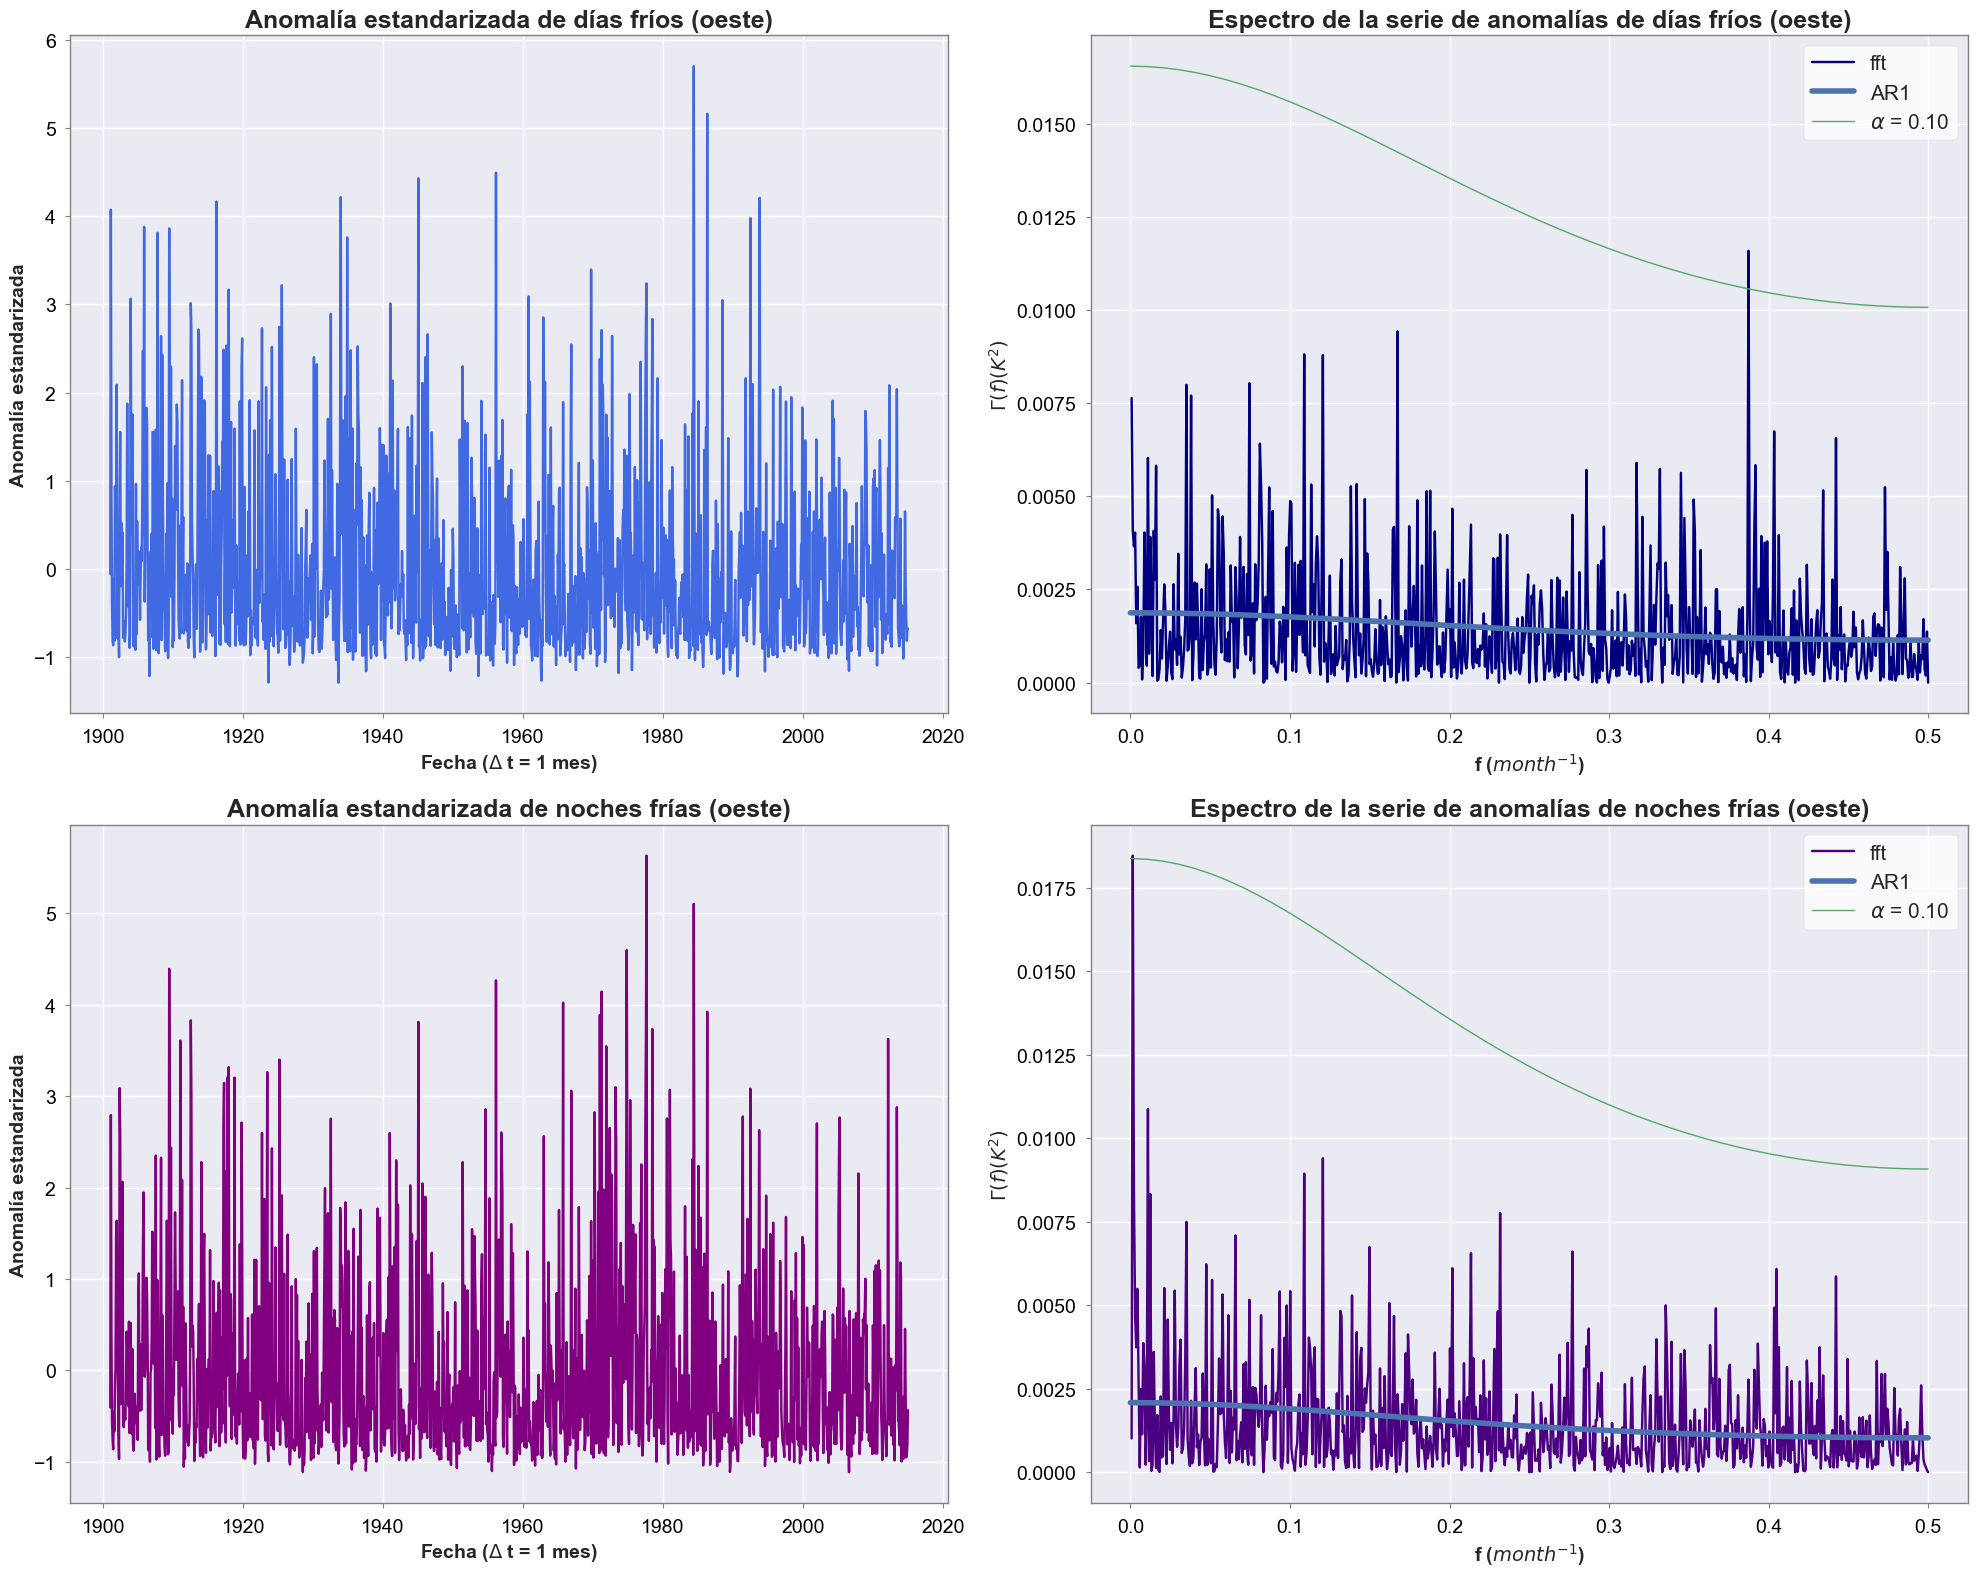

In [505]:
# VAMOS A HACERLO POR MESES
fig,(ax,axd)=plt.subplots(2,2,figsize=(20,16))
años = np.linspace(1901,2015,1368)
x = anom_C_std
ax[0].plot(años,x,color='royalblue')
ax[0].set_ylabel(u'Anomalía estandarizada')
ax[0].set_xlabel(r'Fecha ($\Delta$ t = 1 mes)')
ax[0].set_title(u'Anomalía estandarizada de días fríos (oeste)')


#fa,Ga = espectroArmonico(x,1)
ff,Gf = espectroFFT(x,1)
#ax[1].plot(fa,Ga,linewidth=1)
ax[1].plot(ff,Gf,label='fft',color='navy')
ax[1].set_ylabel(r'$\Gamma(f) (K^2)$')
ax[1].set_xlabel(r'f ($month^{-1}$)')
ax[1].set_title('Espectro de la serie de anomalías de días fríos (oeste)')

print('La varianza de la serie es ',float(np.var(x)))
print('La integral del espectro es ',sum(Gf))


#Veamos si los picos sobresalen lo suficiente:
alpha = 0.1
alphaS = alpha / Gf.size
nu = 2
chi2 = stats.chi2.ppf(1-alphaS,2)
N = x.size
s2 = float(np.var(x))
cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
a = cor[1]
# a = 0 #Para ruido blanco
f,G = redSpectra(a,s2)
ax[1].plot(f,G/x.size,linewidth=4,label='AR1')
Gmax = G/x.size/nu*chi2
ax[1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))
a,s2,chi2
ax[1].legend()


x = anom_CN_std
axd[0].plot(años,x,color='purple')
axd[0].set_ylabel(u'Anomalía estandarizada')
axd[0].set_xlabel(r'Fecha ($\Delta$ t = 1 mes)')
axd[0].set_title(u'Anomalía estandarizada de noches frías (oeste)')


#fa,Ga = espectroArmonico(x,1)
ff,Gf = espectroFFT(x,1)
#ax[1].plot(fa,Ga,linewidth=1)
axd[1].plot(ff,Gf,label='fft',color='indigo')
axd[1].set_ylabel(r'$\Gamma(f) (K^2)$')
axd[1].set_xlabel(r'f ($month^{-1}$)')
axd[1].set_title('Espectro de la serie de anomalías de noches frías (oeste)')

print('La varianza de la serie es ',float(np.var(x)))
print('La integral del espectro es ',sum(Gf))


#Veamos si los picos sobresalen lo suficiente:
alpha = 0.1
alphaS = alpha / Gf.size
nu = 2
chi2 = stats.chi2.ppf(1-alphaS,2)
N = x.size
s2 = float(np.var(x))
cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
a = cor[1]
# a = 0 #Para ruido blanco
f,G = redSpectra(a,s2)
axd[1].plot(f,G/x.size,linewidth=4,label='AR1')
Gmax = G/x.size/nu*chi2
axd[1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))
a,s2,chi2
axd[1].legend()


#ax[1].set_xlim(0,0.02)
#axd[1].set_xlim(0,0.02)



plt.tight_layout()

In [506]:
# VAMOS A HACERLO POR MESES
# fig,(ax,axd)=plt.subplots(2,2,figsize=(20,16))
# x = anom_C_std.sel(time=slice('1938','1955'))
# ax[0].plot(x.time,x,color='royalblue')
# ax[0].set_ylabel(u'Anomalía estandarizada')
# ax[0].set_xlabel(r'Fecha ($\Delta$ t = 1 mes)')
# ax[0].set_title(u'Anomalía estandarizada de días fríos (oeste)')


# #fa,Ga = espectroArmonico(x,1)
# ff,Gf = espectroFFT(x,1)
# #ax[1].plot(fa,Ga,linewidth=1)
# ax[1].plot(ff,Gf,label='fft',color='navy')
# ax[1].set_ylabel(r'$\Gamma(f) (K^2)$')
# ax[1].set_xlabel(r'f ($month^{-1}$)')
# ax[1].set_title('Espectro de la serie de anomalías de días fríos (oeste)')

# print('La varianza de la serie es ',float(np.var(x)))
# print('La integral del espectro es ',sum(Gf))


# #Veamos si los picos sobresalen lo suficiente:
# alpha = 0.1
# alphaS = alpha / Gf.size
# nu = 2
# chi2 = stats.chi2.ppf(1-alphaS,2)
# N = x.size
# s2 = float(np.var(x))
# cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
# a = cor[1]
# # a = 0 #Para ruido blanco
# f,G = redSpectra(a,s2)
# ax[1].plot(f,G/x.size,linewidth=4,label='AR1')
# Gmax = G/x.size/nu*chi2
# ax[1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))
# a,s2,chi2
# ax[1].legend()


# x = anom_CN_std
# axd[0].plot(años,x,color='purple')
# axd[0].set_ylabel(u'Anomalía estandarizada')
# axd[0].set_xlabel(r'Fecha ($\Delta$ t = 1 mes)')
# axd[0].set_title(u'Anomalía estandarizada de noches frías (oeste)')


# #fa,Ga = espectroArmonico(x,1)
# ff,Gf = espectroFFT(x,1)
# #ax[1].plot(fa,Ga,linewidth=1)
# axd[1].plot(ff,Gf,label='fft',color='indigo')
# axd[1].set_ylabel(r'$\Gamma(f) (K^2)$')
# axd[1].set_xlabel(r'f ($month^{-1}$)')
# axd[1].set_title('Espectro de la serie de anomalías de noches frías (oeste)')

# print('La varianza de la serie es ',float(np.var(x)))
# print('La integral del espectro es ',sum(Gf))


# #Veamos si los picos sobresalen lo suficiente:
# alpha = 0.1
# alphaS = alpha / Gf.size
# nu = 2
# chi2 = stats.chi2.ppf(1-alphaS,2)
# N = x.size
# s2 = float(np.var(x))
# cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
# a = cor[1]
# # a = 0 #Para ruido blanco
# f,G = redSpectra(a,s2)
# axd[1].plot(f,G/x.size,linewidth=4,label='AR1')
# Gmax = G/x.size/nu*chi2
# axd[1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))
# a,s2,chi2
# axd[1].legend()


# #ax[1].set_xlim(0,0.02)
# #axd[1].set_xlim(0,0.02)



# plt.tight_layout()

Voy a hacerlo por estaciones

In [507]:
# Algunas funciones de https://docs.xarray.dev/en/v0.9.2/examples/monthly-means.html
dpm = {'noleap': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '365_day': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'standard': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'proleptic_gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'all_leap': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '366_day': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '360_day': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]}

def leap_year(year, calendar='standard'):
    """Determine if year is a leap year"""
    leap = False
    if ((calendar in ['standard', 'gregorian',
        'proleptic_gregorian', 'julian']) and
        (year % 4 == 0)):
        leap = True
        if ((calendar == 'proleptic_gregorian') and
            (year % 100 == 0) and
            (year % 400 != 0)):
            leap = False
        elif ((calendar in ['standard', 'gregorian']) and
                 (year % 100 == 0) and (year % 400 != 0) and
                 (year < 1583)):
            leap = False
    return leap

def get_dpm(time, calendar='standard'):
    """
    return a array of days per month corresponding to the months provided in `months`
    """
    month_length = np.zeros(len(time), dtype=int)

    cal_days = dpm[calendar]

    for i, (month, year) in enumerate(zip(time.month, time.year)):
        month_length[i] = cal_days[month]
        if leap_year(year, calendar=calendar):
            month_length[i] += 1
    return month_length

In [508]:
def resample_month_to_season(ds):
    month_length = xr.DataArray(get_dpm(ds.time.to_index(), calendar='standard'),
        coords=[ds.time],name='month_length')

    result = ((ds * month_length/100).resample(time='QS-DEC').sum() / 
            month_length.resample(time='QS-DEC').sum())*100
    return result
corrN_C_seasons = resample_month_to_season(corrN_C_monthly)
corr_C_seasons = resample_month_to_season(corr_C_monthly)

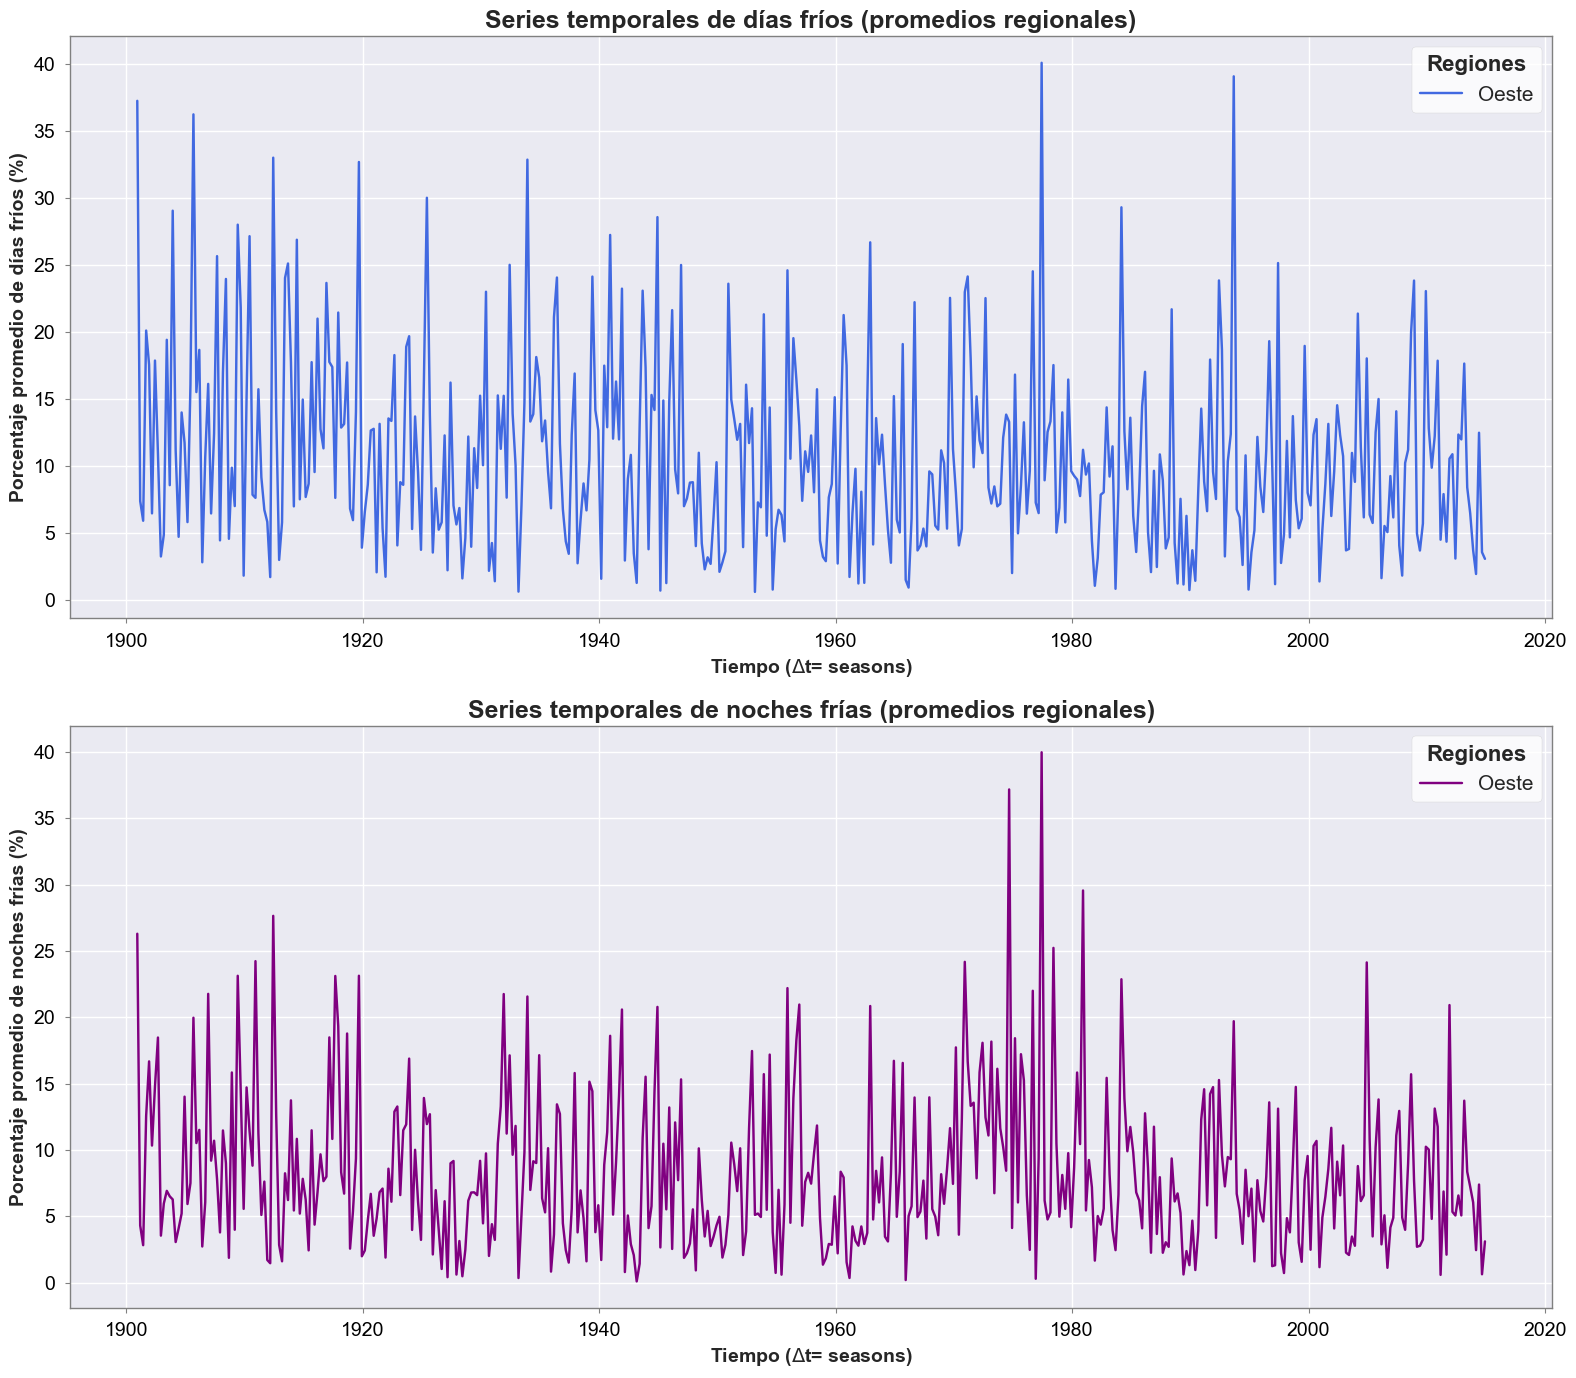

In [509]:
series_style()
fig, (ax,ax2) = plt.subplots(2,1,figsize = (16,14))

var = corr_C_seasons
ax.plot(var.time,var ,color='royalblue',label='Oeste')
ax.legend(title='Regiones',title_fontproperties={'weight':'bold'}) # Leyenda con título
ax.set_xlabel(r'Tiempo ($\Delta$t= seasons)')
ax.set_ylabel(u'Porcentaje promedio de días fríos (%)')
ax.set_title('Series temporales de días fríos (promedios regionales)')

var = corrN_C_seasons
ax2.plot(var.time,var ,color='purple',label='Oeste')
ax2.legend(title='Regiones',title_fontproperties={'weight':'bold'}) # Leyenda con título
ax2.set_xlabel(r'Tiempo ($\Delta$t= seasons)')
ax2.set_ylabel(u'Porcentaje promedio de noches frías (%)')
ax2.set_title('Series temporales de noches frías (promedios regionales)')
plt.tight_layout()

In [510]:
# Seleccionaré las primaveras, representadas por su primer mes: marzo
corrN_C_spring = corrN_C_seasons.sel(time=(corrN_C_seasons.time.dt.month==3))
corr_C_spring = corr_C_seasons.sel(time=(corr_C_seasons.time.dt.month==3))

In [511]:
def armonics_plot(days,nights,season):

    fig,(ax,axd)=plt.subplots(2,2,figsize=(20,16))


    # Fila de arriba
    var = days
    x = (var-var.mean())/var.std() # Calculo la anomalía
    ax[0].plot(x.time,x,color='royalblue')
    ax[0].set_ylabel(u'Anomalía estandarizada')
    ax[0].set_xlabel(r'%s de cada año'%(season))
    ax[0].set_title(u'Anomalía estandarizada de días fríos (centro)')


    #fa,Ga = espectroArmonico(x,1)
    ff,Gf = espectroFFT(x,1)
    #ax[1].plot(fa,Ga,linewidth=1)
    ax[1].plot(ff,Gf,label='fft',color='navy')
    ax[1].set_ylabel(r'$\Gamma(f) (K^2)$')
    ax[1].set_xlabel(r'f ($año^{-1}$)')
    ax[1].set_title('Espectro de la serie de anomalías de días fríos (centro)')

    print('La varianza de la serie es ',float(np.var(x)))
    print('La integral del espectro es ',sum(Gf))


    #Veamos si los picos sobresalen lo suficiente:
    alpha = 0.1
    alphaS = alpha / Gf.size
    nu = 2
    chi2 = stats.chi2.ppf(1-alphaS,2)
    N = x.size
    s2 = float(np.var(x))
    cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
    a = cor[1]
    #a = 0 #Para ruido blanco
    f,G = redSpectra(a,s2)
    ax[1].plot(f,G/x.size,linewidth=4,label='AR1')
    Gmax = G/x.size/nu*chi2
    ax[1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))
    a,s2,chi2
    ax[1].legend()



    # Fila de abajo
    var = nights
    x = (var-var.mean())/var.std() # Calculo la anomalía
    axd[0].plot(x.time,x,color='purple')
    axd[0].set_ylabel(u'Anomalía estandarizada')
    axd[0].set_xlabel(r'%s de cada año'%(season))
    axd[0].set_title(u'Anomalía estandarizada de noches frías (centro)')


    #fa,Ga = espectroArmonico(x,1)
    ff,Gf = espectroFFT(x,1)
    #ax[1].plot(fa,Ga,linewidth=1)
    axd[1].plot(ff,Gf,label='fft',color='indigo')
    axd[1].set_ylabel(r'$\Gamma(f) (K^2)$')
    axd[1].set_xlabel(r'f ($año^{-1}$)')
    axd[1].set_title('Espectro de la serie de anomalías de noches frías (centro)')

    print('La varianza de la serie es ',float(np.var(x)))
    print('La integral del espectro es ',sum(Gf))


    #Veamos si los picos sobresalen lo suficiente:
    alpha = 0.1
    alphaS = alpha / Gf.size
    nu = 2
    chi2 = stats.chi2.ppf(1-alphaS,2)
    N = x.size
    s2 = float(np.var(x))
    cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
    a = cor[1]
    # a = 0 #Para ruido blanco
    f,G = redSpectra(a,s2)
    axd[1].plot(f,G/x.size,linewidth=4,label='AR1')
    Gmax = G/x.size/nu*chi2
    axd[1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))
    a,s2,chi2
    axd[1].legend()

    fig.suptitle(r'%s'%(season),size=26,weight='bold')

    #ax[1].set_xlim(0,0.02)
    #axd[1].set_xlim(0,0.02)



    plt.tight_layout()
    return fig, (ax,axd)

La varianza de la serie es  0.9999999999999999
La integral del espectro es  1.0321908223692078
La varianza de la serie es  0.9999999999999997
La integral del espectro es  1.0014434125833223


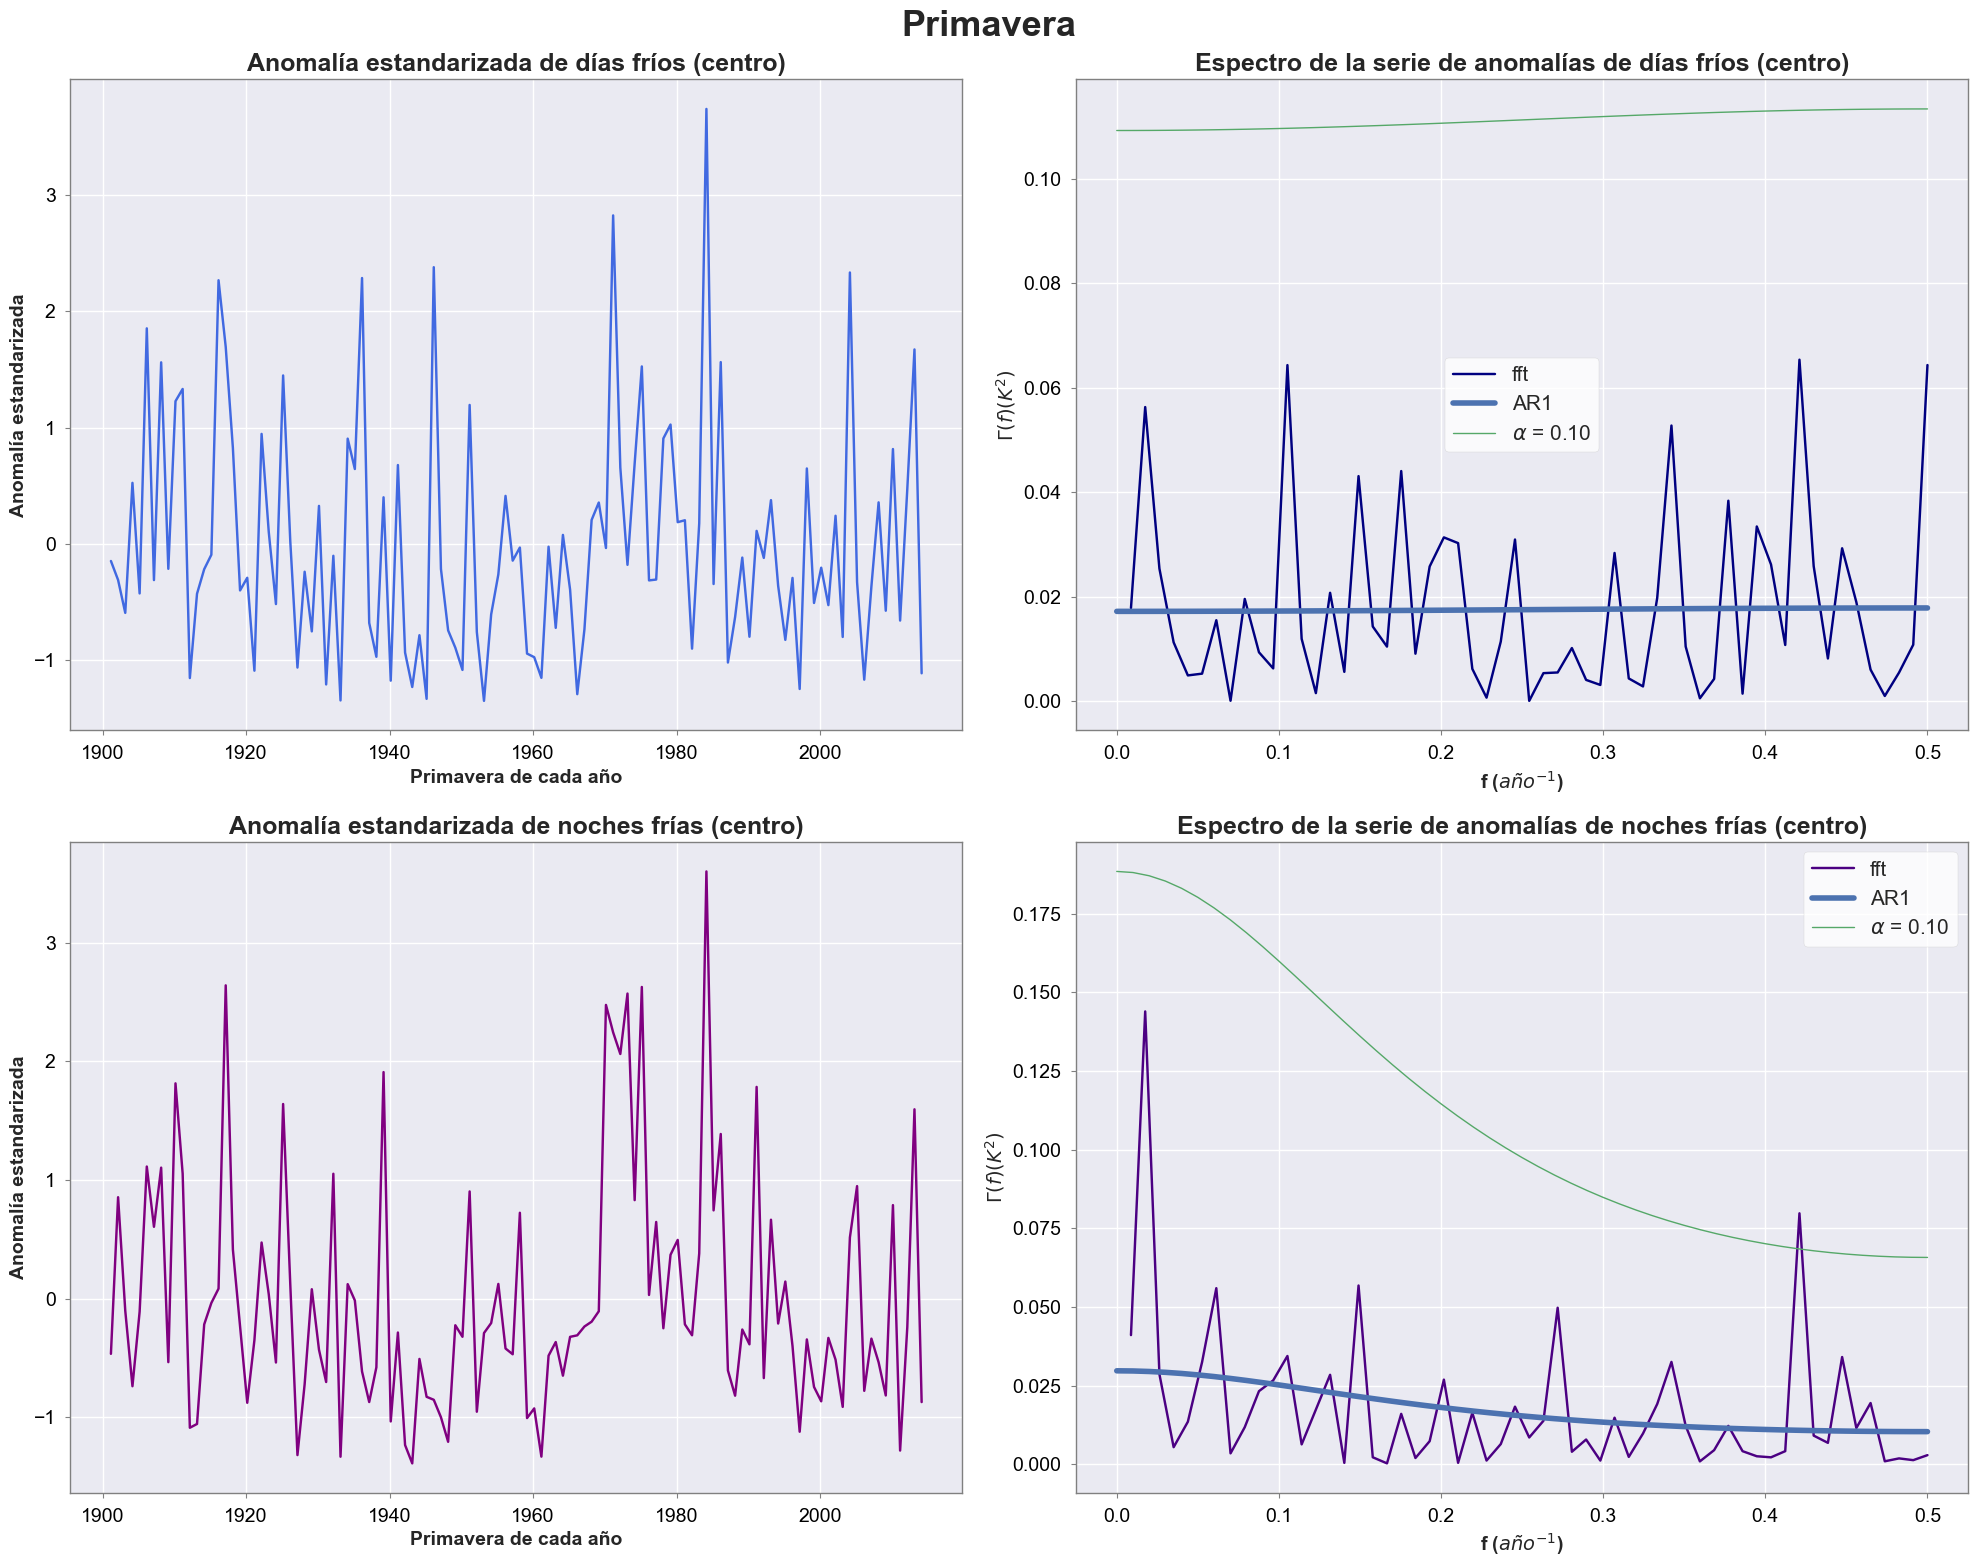

In [512]:
fig, (ax,axd) = armonics_plot(corr_C_spring,corrN_C_spring,'Primavera')

In [513]:
# Seleccionaré los demás, representadas por su primer mes: marzo
corrN_O_summer = corrN_C_seasons.sel(time=(corrN_C_seasons.time.dt.month==6))
corr_O_summer = corr_C_seasons.sel(time=(corr_C_seasons.time.dt.month==6))

corrN_O_fall = corrN_C_seasons.sel(time=(corrN_C_seasons.time.dt.month==9))
corr_O_fall = corr_C_seasons.sel(time=(corr_C_seasons.time.dt.month==9))

corrN_O_winter = corrN_C_seasons.sel(time=(corrN_C_seasons.time.dt.month==12))
corrN_O_winter = corrN_O_winter.sel(time=slice('1901','2014')) # Hay que quitar el primero y último, no están completos
corr_O_winter = corr_C_seasons.sel(time=(corr_C_seasons.time.dt.month==12))
corrN_O_winter = corr_O_winter.sel(time=slice('1901','2014')) # Hay que quitar el primero y último, no están completos

La varianza de la serie es  1.0000000000000002
La integral del espectro es  1.0020857012632416
La varianza de la serie es  1.0000000000000004
La integral del espectro es  1.0086660095162108


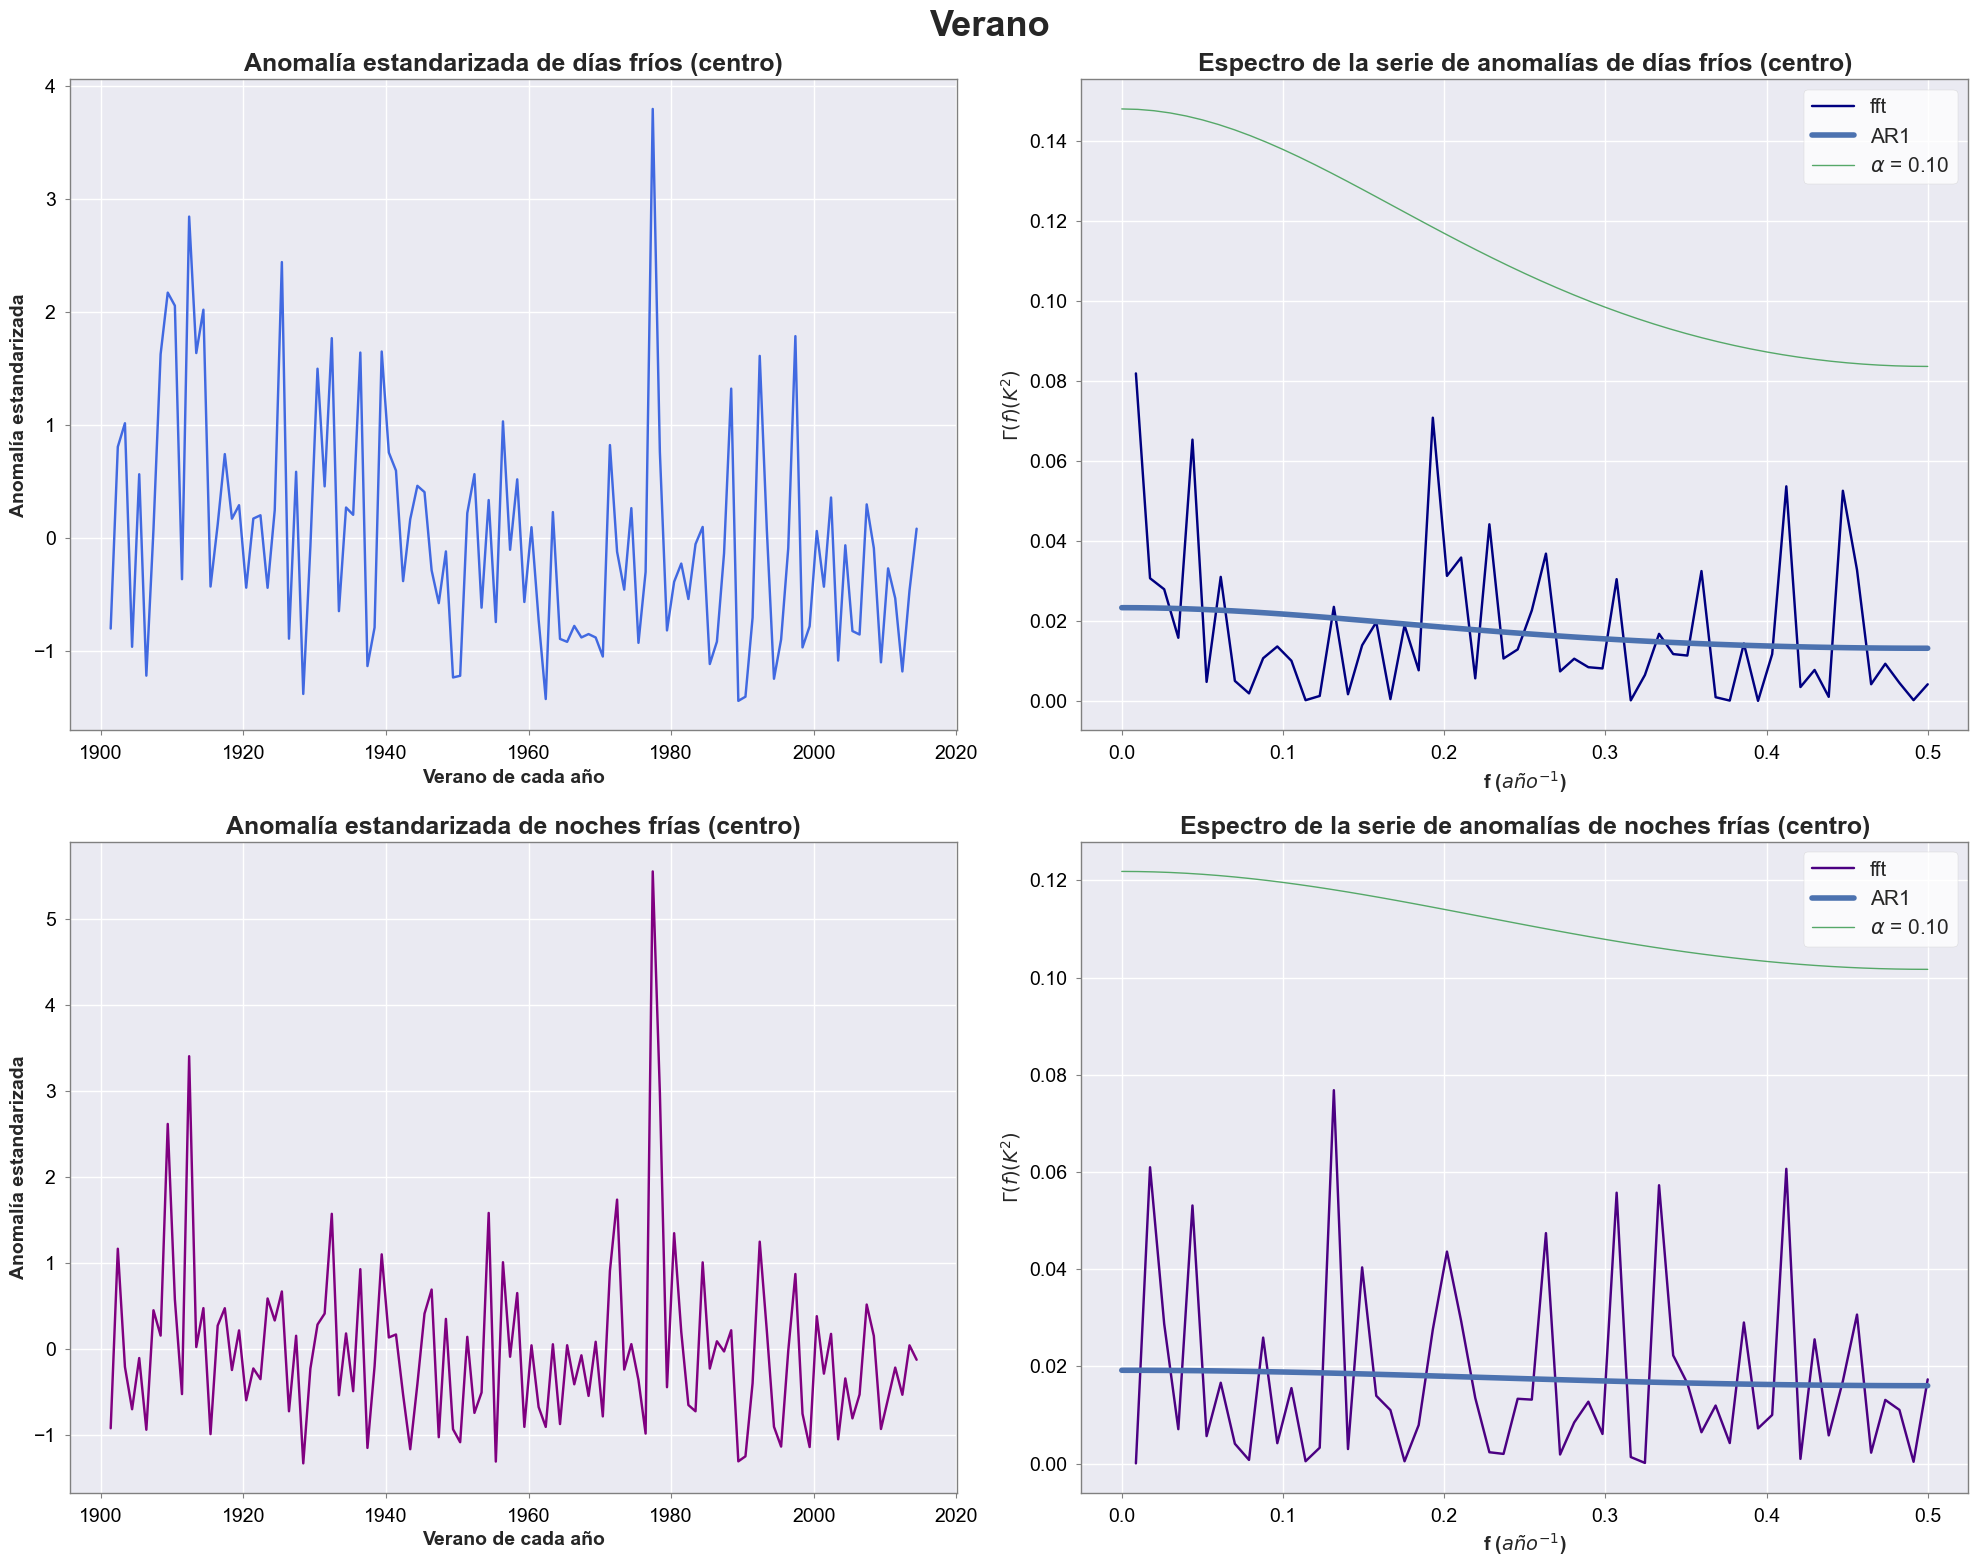

In [514]:
fig, (ax,axd) = armonics_plot(corr_O_summer,corrN_O_summer,'Verano')

La varianza de la serie es  1.0000000000000002
La integral del espectro es  1.01210616489471
La varianza de la serie es  0.9999999999999998
La integral del espectro es  1.0000425507547825


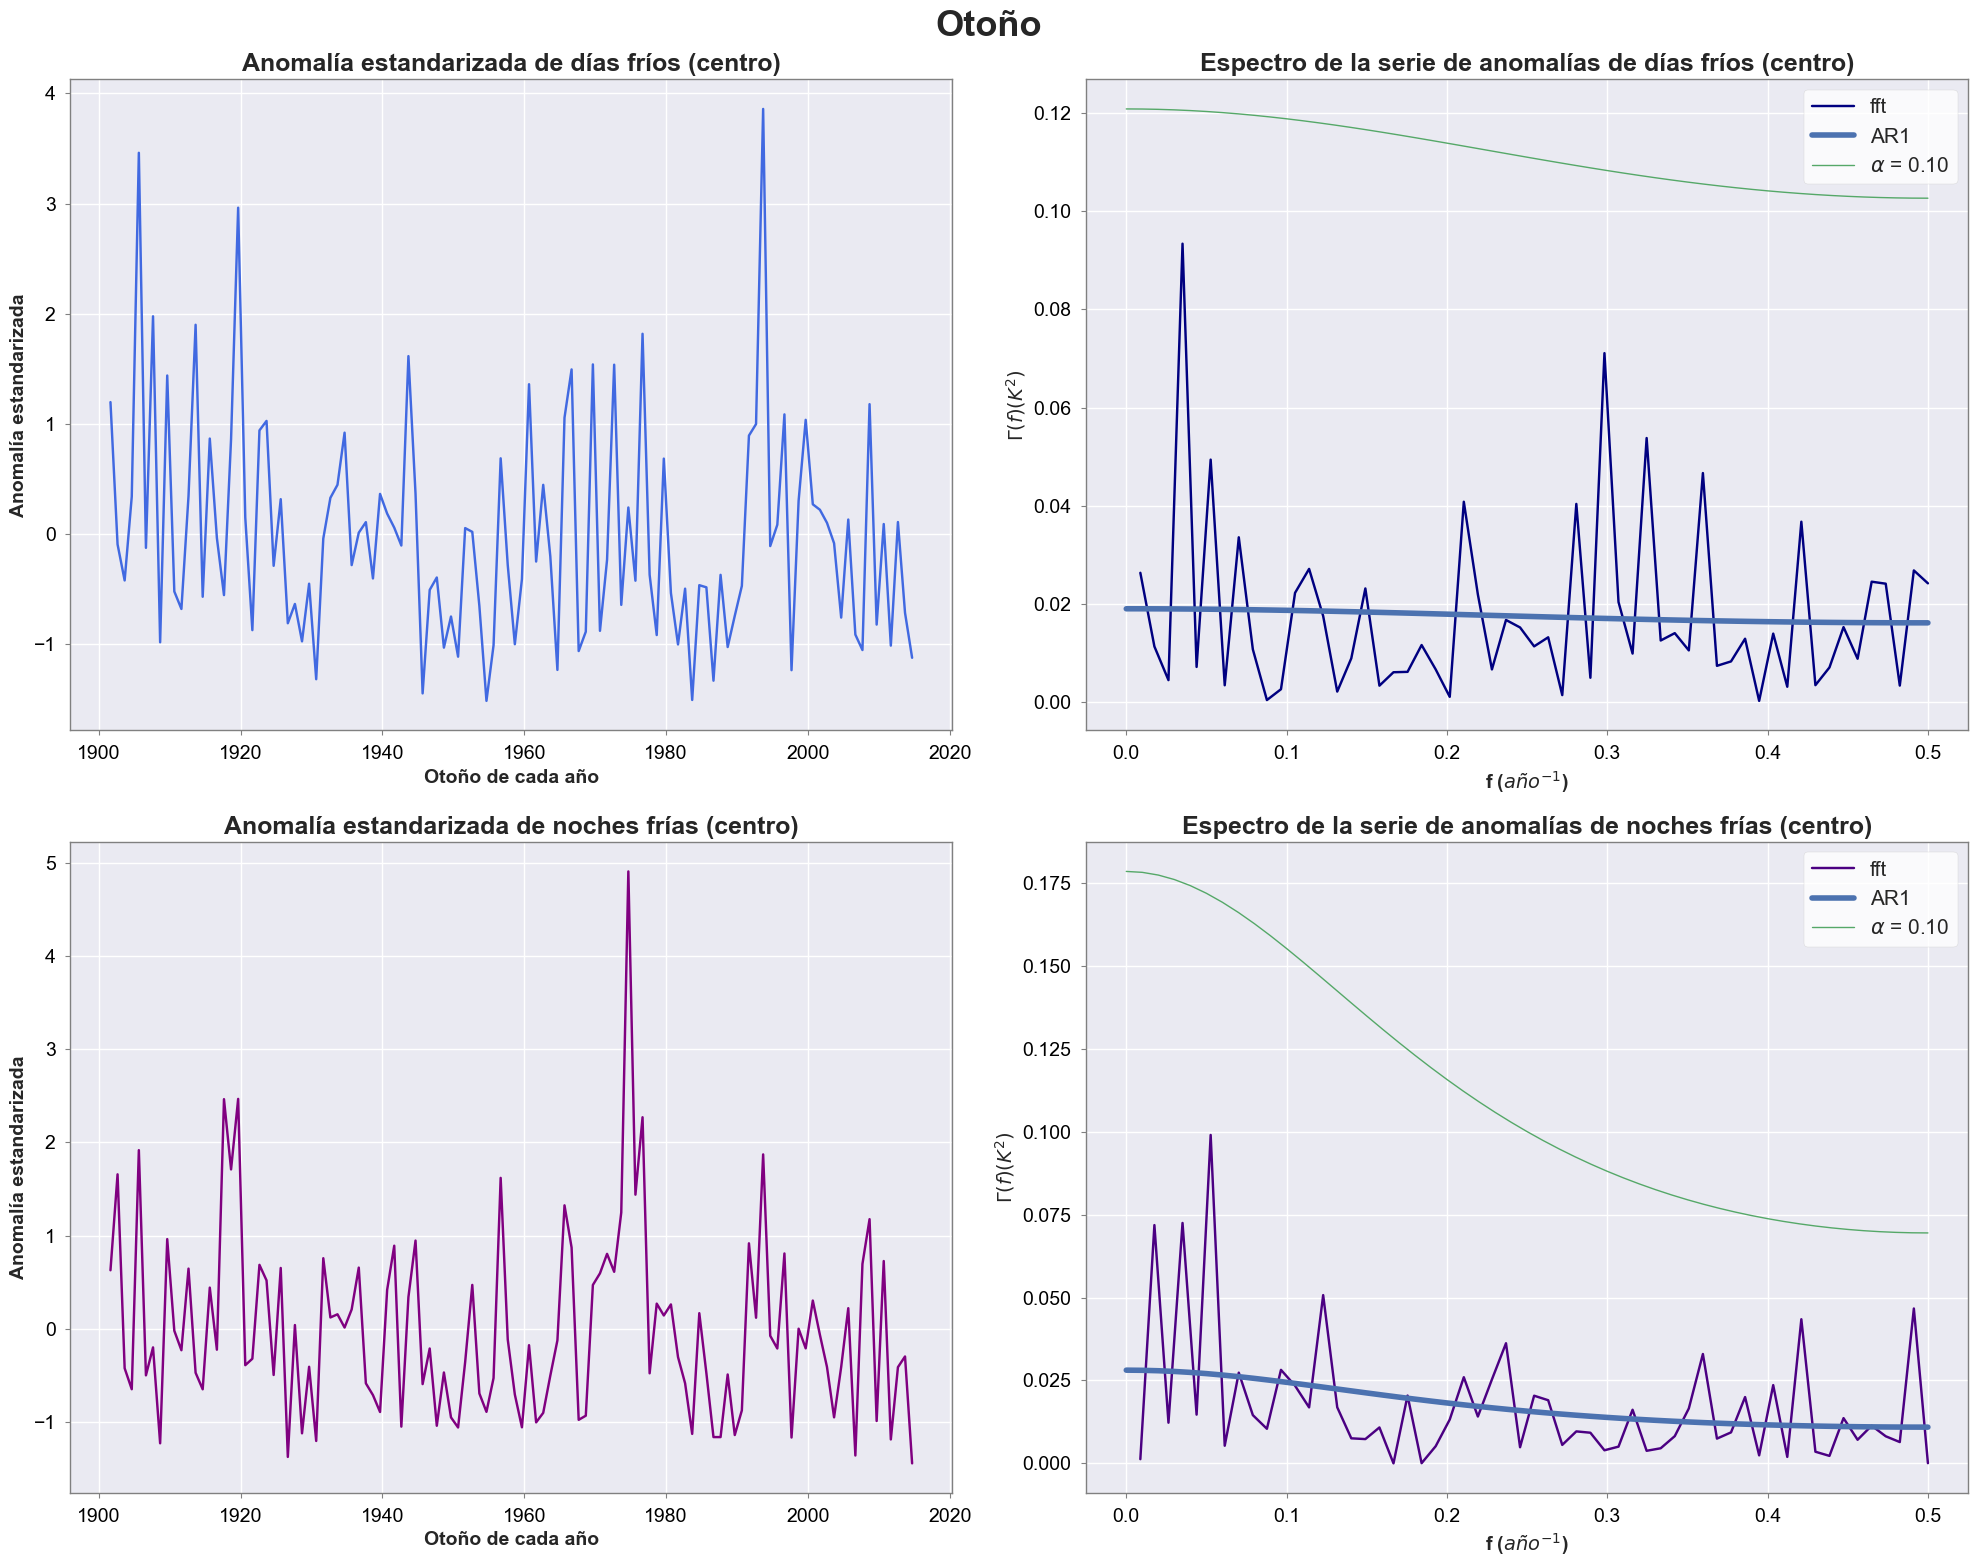

In [515]:
fig, (ax,axd) = armonics_plot(corr_O_fall,corrN_O_fall,'Otoño')

La varianza de la serie es  1.0000000000000002
La integral del espectro es  1.01210616489471
La varianza de la serie es  0.9999999999999998
La integral del espectro es  1.0000425507547825


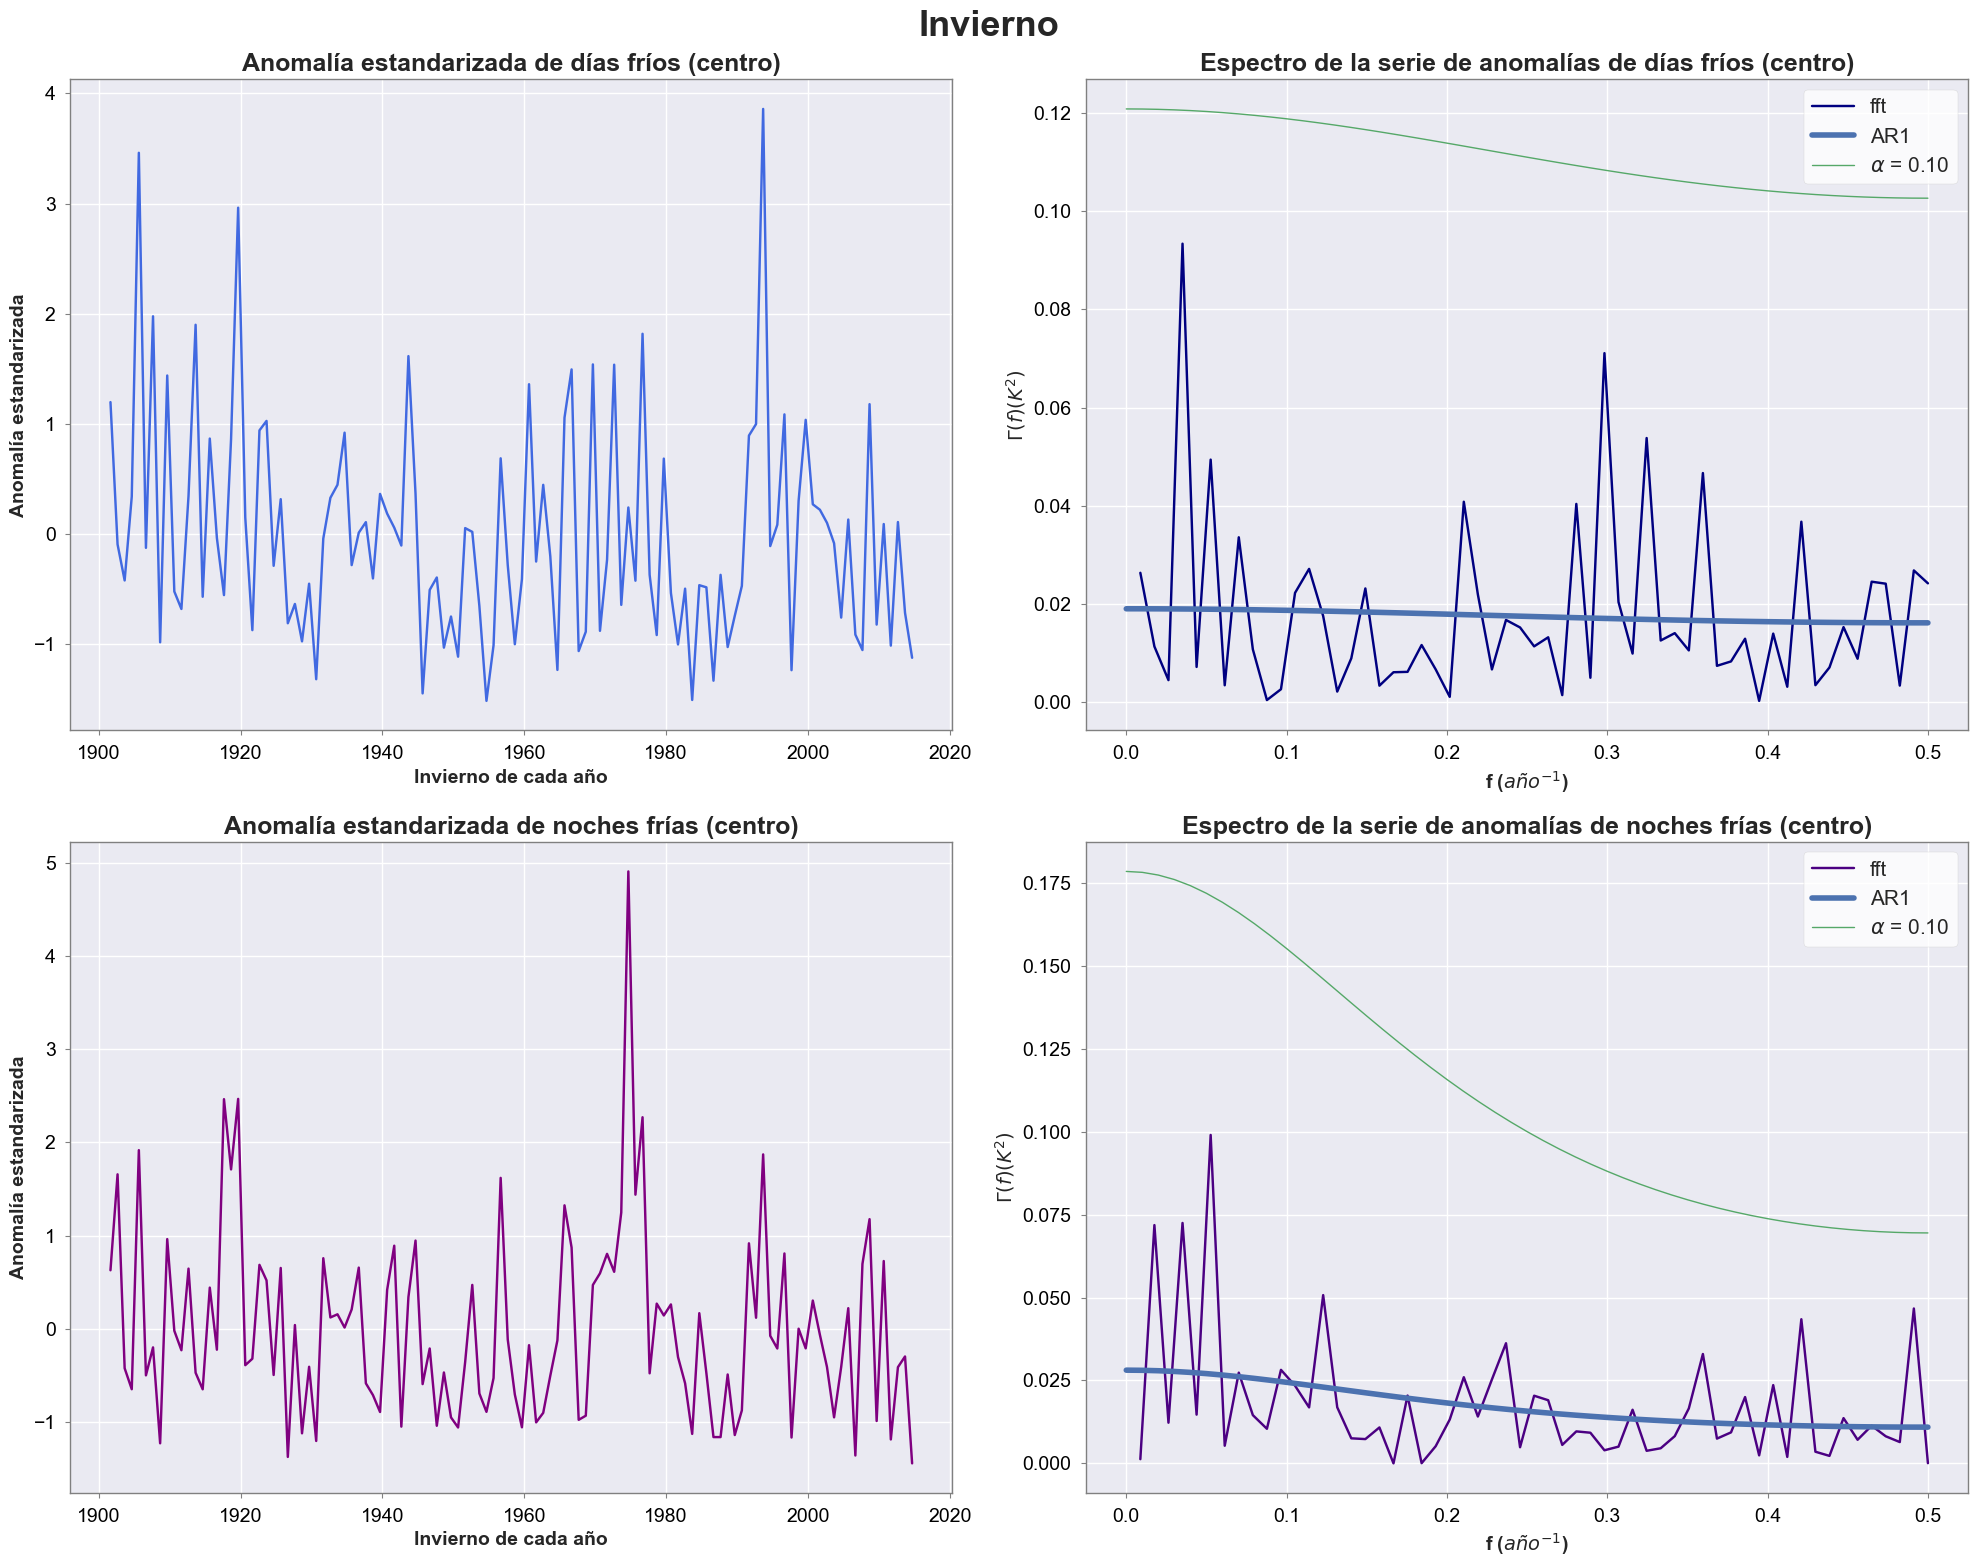

In [516]:
fig, (ax,axd) = armonics_plot(corr_O_fall,corrN_O_fall,'Invierno')

# MENSUAL

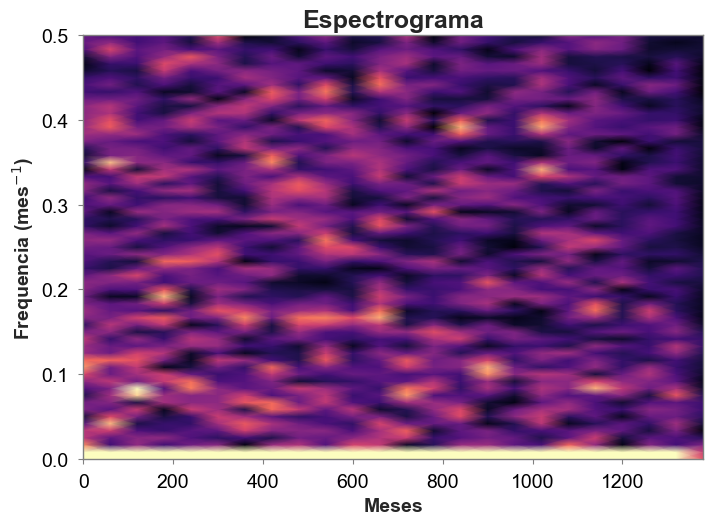

In [517]:
# Lo hago a partir del ejemplo de scipy
x=corr_C_monthly
f, t, Zxx = signal.stft(x, 1, nperseg=10*12)
Zabs = np.abs(Zxx)
plt.pcolormesh(t, f, Zabs, vmin=0, vmax=Zabs.max()/4,cmap='magma', shading='gouraud')
plt.title('Espectrograma')
plt.ylabel(r'Frequencia (mes$^{-1}$)')
plt.xlabel('Meses')
plt.show()

---

# FILTROS: Filtra la señal en las diferentes frecuencias

---

In [547]:
anom_spring = (corr_C_spring-corr_C_spring.mean())/corr_C_spring.std() # Calculo la anomalía
ff,Gf = espectroFFT(x,1)

In [667]:
x0=np.where(ff>0.43)
x1=x0[0][0]
frec_noches_primavera=ff[x1]
pico_noches_primavera=Gf[x1]
frec_noches_primavera

0.4305555555555556

0.43055555555555564
fc 0.43055555555555564


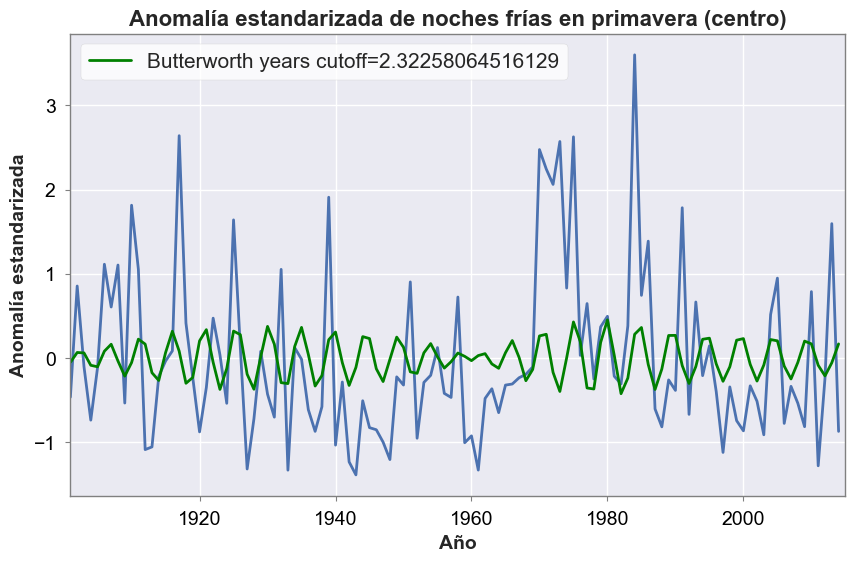

In [705]:
fig,ax = plt.subplots(1,1,figsize=(10,6))

# La señal inicial
var = corrN_C_spring
x = (var-var.mean())/var.std() # Calculo la anomalía
t = np.arange(1901,2015)
N = x.size

#Voy a usar la condición mínima derivada en ambos extremos:
xtot = np.append(np.flip(x),[x,np.flip(x)])

# frecuencia de corte (en años) (pico en 0.43859649122807015 años^-1):
nyc = 1/frec_noches_primavera
Tc = nyc  
fc =  1 / Tc
print(fc)
print('fc',fc)
#Media móvil: necesito una ventana de aprox. Tc/0.443
Window = int(0.443/fc)
#Window = Tc

#Filtro la señal ampliada y luego me quedo con el trozo central
ytot = runningMean(xtot,Window)
yRunningMean = ytot[N:2*N]


#Filtro de Butterworth, escogemos orden nominal 4
#Cuidado que el filtro de Butter tiene la frecuencia normalizada con 1 correspondiendo a fmax=FNyquist
n = 4
# b,a = signal.butter(n,fc*2,,output='ba',btype='bandpass')
b,a = signal.butter(n,2*[frec_noches_primavera-frec_noches_primavera/10,frec_noches_primavera+frec_noches_primavera/10],output='ba',btype='bandpass')
#Filtro la señal ampliada y me quedo con la parte central:
ytot = signal.filtfilt(b,a,xtot)
yButter = ytot[N:2*N]
ax.plot(t,x,linewidth=2)
ax.set_title('Anomalía estandarizada de noches frías en primavera (centro)',fontsize=16,weight='bold')
ax.set_xlabel('Año')
ax.set_ylabel(u'Anomalía estandarizada')
# ax.plot(t,yRunningMean,linewidth= 2,color='orange',label='Running Mean T='+str(Window/12)+' years',alpha=0.5)
ax.plot(t,yButter,linewidth= 2,color='green',label='Butterworth years cutoff='+str(nyc))
ax.set_xlim([1901,2015])
ax.legend()


La varianza de la serie es  0.9999999999999997
La integral del espectro es  1.0014434125833223
La varianza de la serie es  <xarray.DataArray ()>
array(1.)
La integral del espectro es  1.0014434125833223


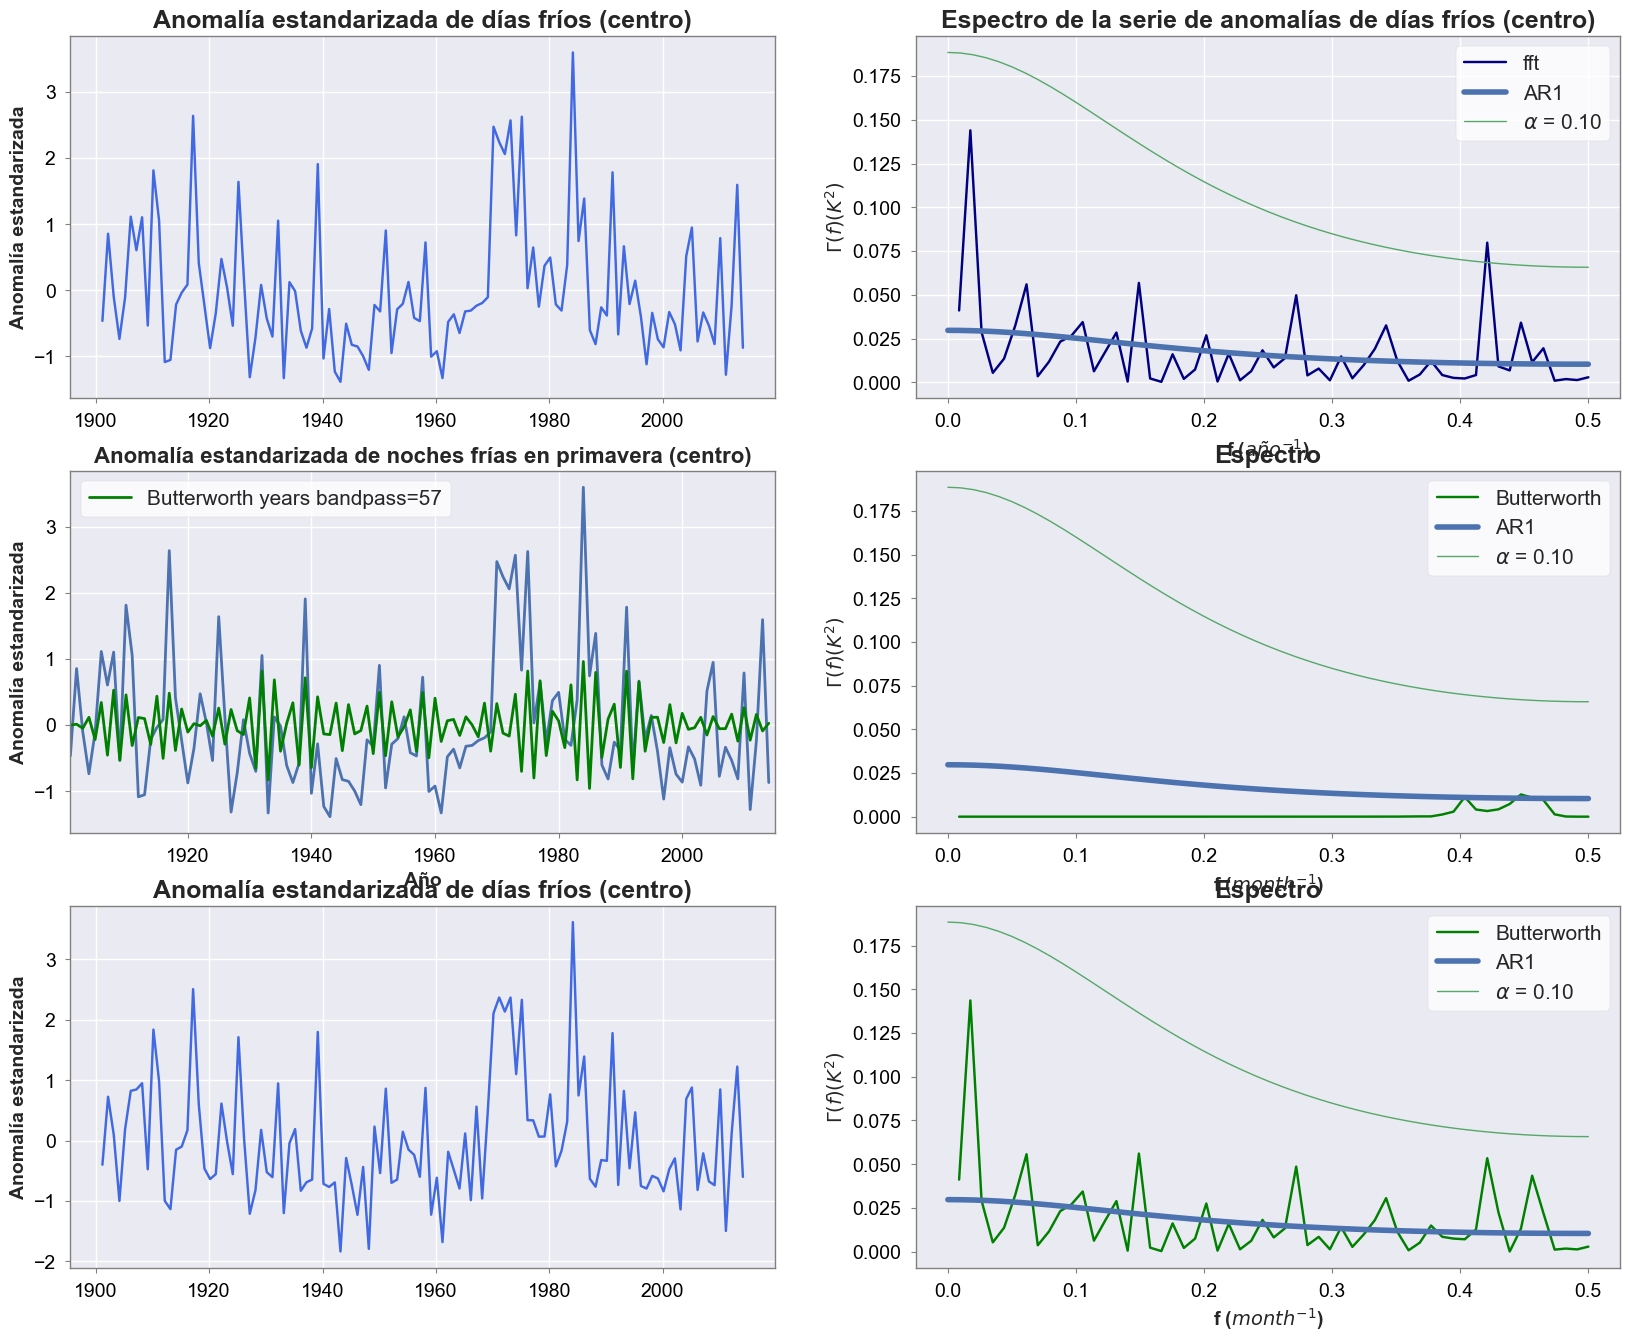

In [771]:

fig,(ax,axd,ax3)=plt.subplots(3,2,figsize=(20,16))

t=np.arange(1901,2015)
# Fila de arriba
var = corrN_C_spring
x_N = (var-var.mean())/var.std() # Calculo la anomalía
ax[0].plot(x_N.time,x_N,color='royalblue')
ax[0].set_ylabel(u'Anomalía estandarizada')
# ax[0].set_xlabel(r'%s de cada año'%(season))
ax[0].set_title(u'Anomalía estandarizada de días fríos (centro)')


#fa,Ga = espectroArmonico(x,1)
ff,Gf = espectroFFT(x_N,1)
#ax[1].plot(fa,Ga,linewidth=1)
ax[1].plot(ff,Gf,label='fft',color='navy')
ax[1].set_ylabel(r'$\Gamma(f) (K^2)$')
ax[1].set_xlabel(r'f ($año^{-1}$)')
ax[1].set_title('Espectro de la serie de anomalías de días fríos (centro)')

print('La varianza de la serie es ',float(np.var(x_N)))
print('La integral del espectro es ',sum(Gf))


#Veamos si los picos sobresalen lo suficiente:
alpha = 0.1
alphaS = alpha / Gf.size
nu = 2
chi2 = stats.chi2.ppf(1-alphaS,2)
N = x.size
s2 = float(np.var(x))
cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
a = cor[1]
#a = 0 #Para ruido blanco
f_tot,G_tot = redSpectra(a,s2)
ax[1].plot(f_tot,G_tot/x.size,linewidth=4,label='AR1')
Gmax_tot = G_tot/x.size/nu*chi2
ax[1].plot(f_tot,Gmax_tot,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))
a,s2,chi2
ax[1].legend()


n = 4
# b,a = signal.butter(n,fc*2,,output='ba',btype='bandpass')
b,a = signal.butter(n,[2*frec_noches_primavera-2*frec_noches_primavera/10,2*frec_noches_primavera+2*frec_noches_primavera/10],output='ba',btype='bandpass')
#Filtro la señal ampliada y me quedo con la parte central:
xtot = np.append(np.flip(x_N),[x,np.flip(x_N)])
ytotx_n = signal.filtfilt(b,a,xtot)
yButter_N = ytotx_n[N:2*N]
axd[0].plot(t,x,linewidth=2)
axd[0].set_title('Anomalía estandarizada de noches frías en primavera (centro)',fontsize=16,weight='bold')
axd[0].set_xlabel('Año')
axd[0].set_ylabel(u'Anomalía estandarizada')
# ax.plot(t,yRunningMean,linewidth= 2,color='orange',label='Running Mean T='+str(Window/12)+' years',alpha=0.5)
axd[0].plot(t,yButter_N,linewidth= 2,color='green',label='Butterworth years bandpass='+str(nyc))
axd[0].set_xlim([1901,2015])
axd[0].legend()

x_butter = np.squeeze(np.array(yButter))

ff_but,Gf_but = espectroFFT(x_butter,1)
axd[1].plot(ff_but,Gf_but,label='Butterworth',color='g')
axd[1].grid()
axd[1].set_ylabel(r'$\Gamma(f) (K^2)$')
axd[1].set_xlabel(r'f ($month^{-1}$)')
axd[1].set_title('Espectro')

print('La varianza de la serie es ',np.var(x))
print('La integral del espectro es ',sum(Gf))

#Veamos si los picos sobresalen lo suficiente:
alpha = 0.1
alphaS = alpha / Gf.size
nu = 2
chi2 = stats.chi2.ppf(1-alphaS,2)
N = x.size
s2 = float(np.var(x))
cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
a = cor[1]
#a = 0 #Para ruido blanco
f_tot,G_tot = redSpectra(a,s2)
axd[1].plot(f_tot,G_tot/x.size,linewidth=4,label='AR1')
Gmax_tot = G_tot/x.size/nu*chi2
axd[1].plot(f_tot,Gmax_tot,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))
a,s2,chi2
axd[1].legend()

xresta=x-yButter
ax3[0].plot(xresta.time,xresta,color='royalblue')
ax3[0].set_ylabel(u'Anomalía estandarizada')
# ax[0].set_xlabel(r'%s de cada año'%(season))
ax3[0].set_title(u'Anomalía estandarizada de días fríos (centro)')

ff_rest,Gf_rest = espectroFFT(xresta,1)
ax3[1].plot(ff_rest,Gf_rest,label='Butterworth',color='g')
ax3[1].grid()
ax3[1].set_ylabel(r'$\Gamma(f) (K^2)$')
ax3[1].set_xlabel(r'f ($month^{-1}$)')
ax3[1].set_title('Espectro')

#Veamos si los picos sobresalen lo suficiente:
alpha = 0.1
alphaS = alpha / Gf.size
nu = 2
chi2 = stats.chi2.ppf(1-alphaS,2)
N = x.size
s2 = float(np.var(x))
cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
a = cor[1]
#a = 0 #Para ruido blanco
f_tot,G_tot = redSpectra(a,s2)
ax3[1].plot(f_tot,G_tot/x.size,linewidth=4,label='AR1')
Gmax_tot = G_tot/x.size/nu*chi2
ax3[1].plot(f_tot,Gmax_tot,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))
a,s2,chi2
ax3[1].legend()

---

# FILTRAMOS LAS SERIES MENSUALES

---


In [714]:
años = np.linspace(1901,2015,1368)
x = anom_C_std
ff,Gf = espectroFFT(x,1)

x0=np.where(Gf>0.01)
frec=ff[x0]
Gf_pico=Gf[x0]
1/frec/12
frec_mens_diasf=0.3874269

La varianza de la serie es  1.0
La integral del espectro es  0.9999999999999989
La varianza de la serie es  <xarray.DataArray ()>
array(1.)
La integral del espectro es  0.9999999999999989


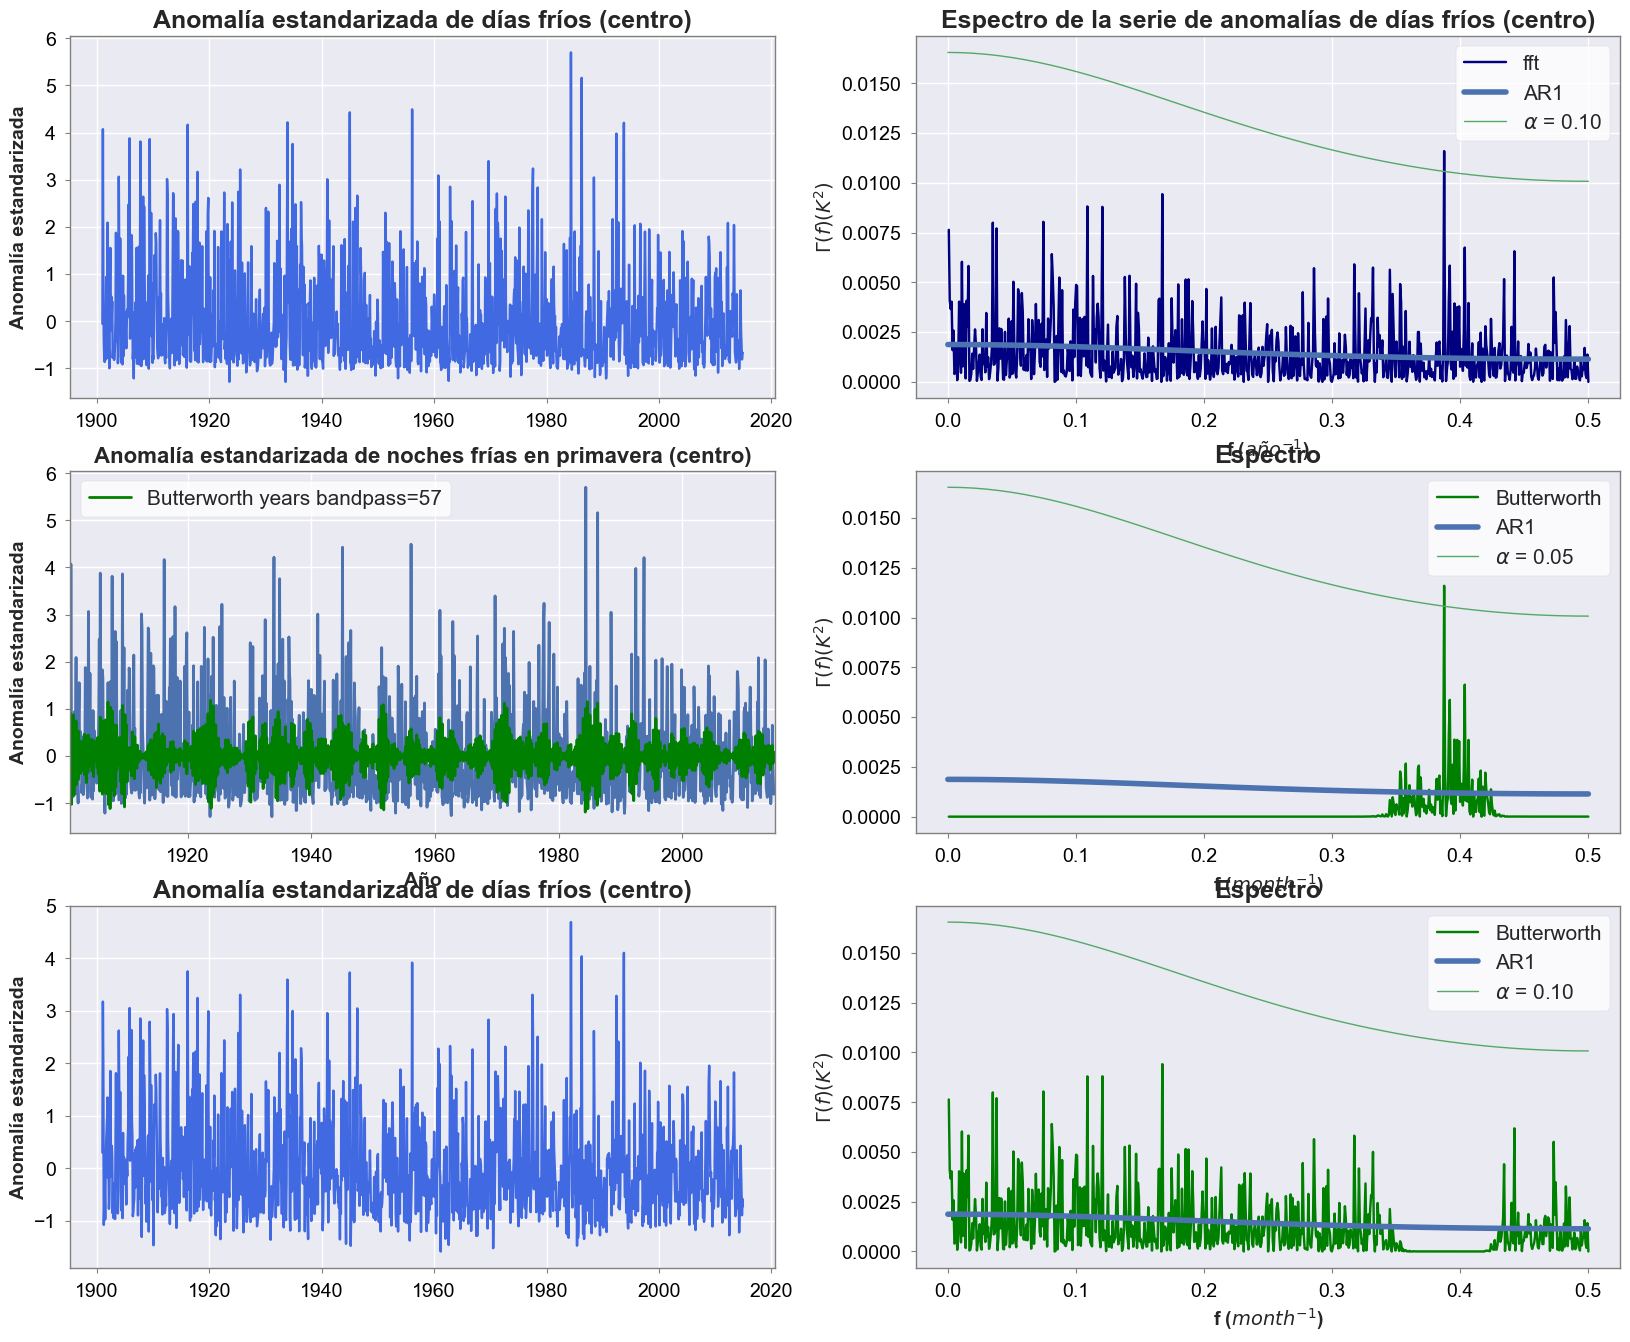

In [725]:
fig,(ax,axd,ax3)=plt.subplots(3,2,figsize=(20,16))


# Fila de arriba
x = anom_C_std
ax[0].plot(x.time,x,color='royalblue')
ax[0].set_ylabel(u'Anomalía estandarizada')
# ax[0].set_xlabel(r'%s de cada año'%(season))
ax[0].set_title(u'Anomalía estandarizada de días fríos (centro)')


#fa,Ga = espectroArmonico(x,1)
ff,Gf = espectroFFT(x,1)
#ax[1].plot(fa,Ga,linewidth=1)
ax[1].plot(ff,Gf,label='fft',color='navy')
ax[1].set_ylabel(r'$\Gamma(f) (K^2)$')
ax[1].set_xlabel(r'f ($año^{-1}$)')
ax[1].set_title('Espectro de la serie de anomalías de días fríos (centro)')

print('La varianza de la serie es ',float(np.var(x)))
print('La integral del espectro es ',sum(Gf))


#Veamos si los picos sobresalen lo suficiente:
alpha = 0.1
alphaS = alpha / Gf.size
nu = 2
chi2 = stats.chi2.ppf(1-alphaS,2)
N = x.size
s2 = float(np.var(x))
cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
a = cor[1]
#a = 0 #Para ruido blanco
f_tot,G_tot = redSpectra(a,s2)
ax[1].plot(f_tot,G_tot/x.size,linewidth=4,label='AR1')
Gmax_tot = G_tot/x.size/nu*chi2
ax[1].plot(f_tot,Gmax_tot,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))
a,s2,chi2
ax[1].legend()


n = 4
# b,a = signal.butter(n,fc*2,,output='ba',btype='bandpass')
b,a = signal.butter(n,[2*frec_mens_diasf-2*frec_mens_diasf/10,2*frec_mens_diasf+2*frec_mens_diasf/10],output='ba',btype='bandpass')
#Filtro la señal ampliada y me quedo con la parte central:
ytot = signal.filtfilt(b,a,xtot)
yButter = ytot[N:2*N]
axd[0].plot(t,x,linewidth=2)
axd[0].set_title('Anomalía estandarizada de noches frías en primavera (centro)',fontsize=16,weight='bold')
axd[0].set_xlabel('Año')
axd[0].set_ylabel(u'Anomalía estandarizada')
# ax.plot(t,yRunningMean,linewidth= 2,color='orange',label='Running Mean T='+str(Window/12)+' years',alpha=0.5)
axd[0].plot(t,yButter,linewidth= 2,color='green',label='Butterworth years bandpass='+str(nyc))
axd[0].set_xlim([1901,2015])
axd[0].legexqnd()

x_butter = np.squeeze(np.array(yButter))

ff_but,Gf_but = espectroFFT(x_butter,1)
axd[1].plot(ff_but,Gf_but,label='Butterworth',color='g')
axd[1].grid()
axd[1].set_ylabel(r'$\Gamma(f) (K^2)$')
axd[1].set_xlabel(r'f ($month^{-1}$)')
axd[1].set_title('Espectro')

print('La varianza de la serie es ',np.var(x))
print('La integral del espectro es ',sum(Gf))

#Veamos si los picos sobresalen lo suficiente:
alpha = 0.1
alphaS = alpha / Gf.size
nu = 2
chi2 = stats.chi2.ppf(1-alphaS,2)
s2 = np.var(x_butter)
cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
a = cor[1]
f,G = redSpectra(a,s2)
axd[1].plot(f_tot,G_tot/x.size,linewidth=4,label='AR1')
Gmax = G/x.size/nu*chi2
axd[1].plot(f_tot,Gmax_tot,linewidth=1,label=r'$\alpha$ = 0.05')
a,s2,chi2
axd[1].set_xlim()
axd[1].legend()

xresta=x-yButter
ax3[0].plot(xresta.time,xresta,color='royalblue')
ax3[0].set_ylabel(u'Anomalía estandarizada')
# ax[0].set_xlabel(r'%s de cada año'%(season))
ax3[0].set_title(u'Anomalía estandarizada de días fríos (centro)')

ff_rest,Gf_rest = espectroFFT(xresta,1)
ax3[1].plot(ff_rest,Gf_rest,label='Butterworth',color='g')
ax3[1].grid()
ax3[1].set_ylabel(r'$\Gamma(f) (K^2)$')
ax3[1].set_xlabel(r'f ($month^{-1}$)')
ax3[1].set_title('Espectro')

#Veamos si los picos sobresalen lo suficiente:
alpha = 0.1
alphaS = alpha / Gf.size
nu = 2
chi2 = stats.chi2.ppf(1-alphaS,2)
N = x.size
s2 = float(np.var(x))
cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
a = cor[1]
#a = 0 #Para ruido blanco
f_tot,G_tot = redSpectra(a,s2)
ax3[1].plot(f_tot,G_tot/x.size,linewidth=4,label='AR1')
Gmax_tot = G_tot/x.size/nu*chi2
ax3[1].plot(f_tot,Gmax_tot,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))
a,s2,chi2
ax3[1].legend()

In [761]:
años = np.linspace(1901,2015,1368)
x = anom_CN_std
ff,Gf = espectroFFT(x,1)

x0=np.where(Gf>0.017)
frec=ff[x0]
Gf_pico2=Gf[x0]
1/frec/12
frec_mens_nochesf=0.00146199

La varianza de la serie es  0.9999999999999997
La integral del espectro es  1.0000000000000002


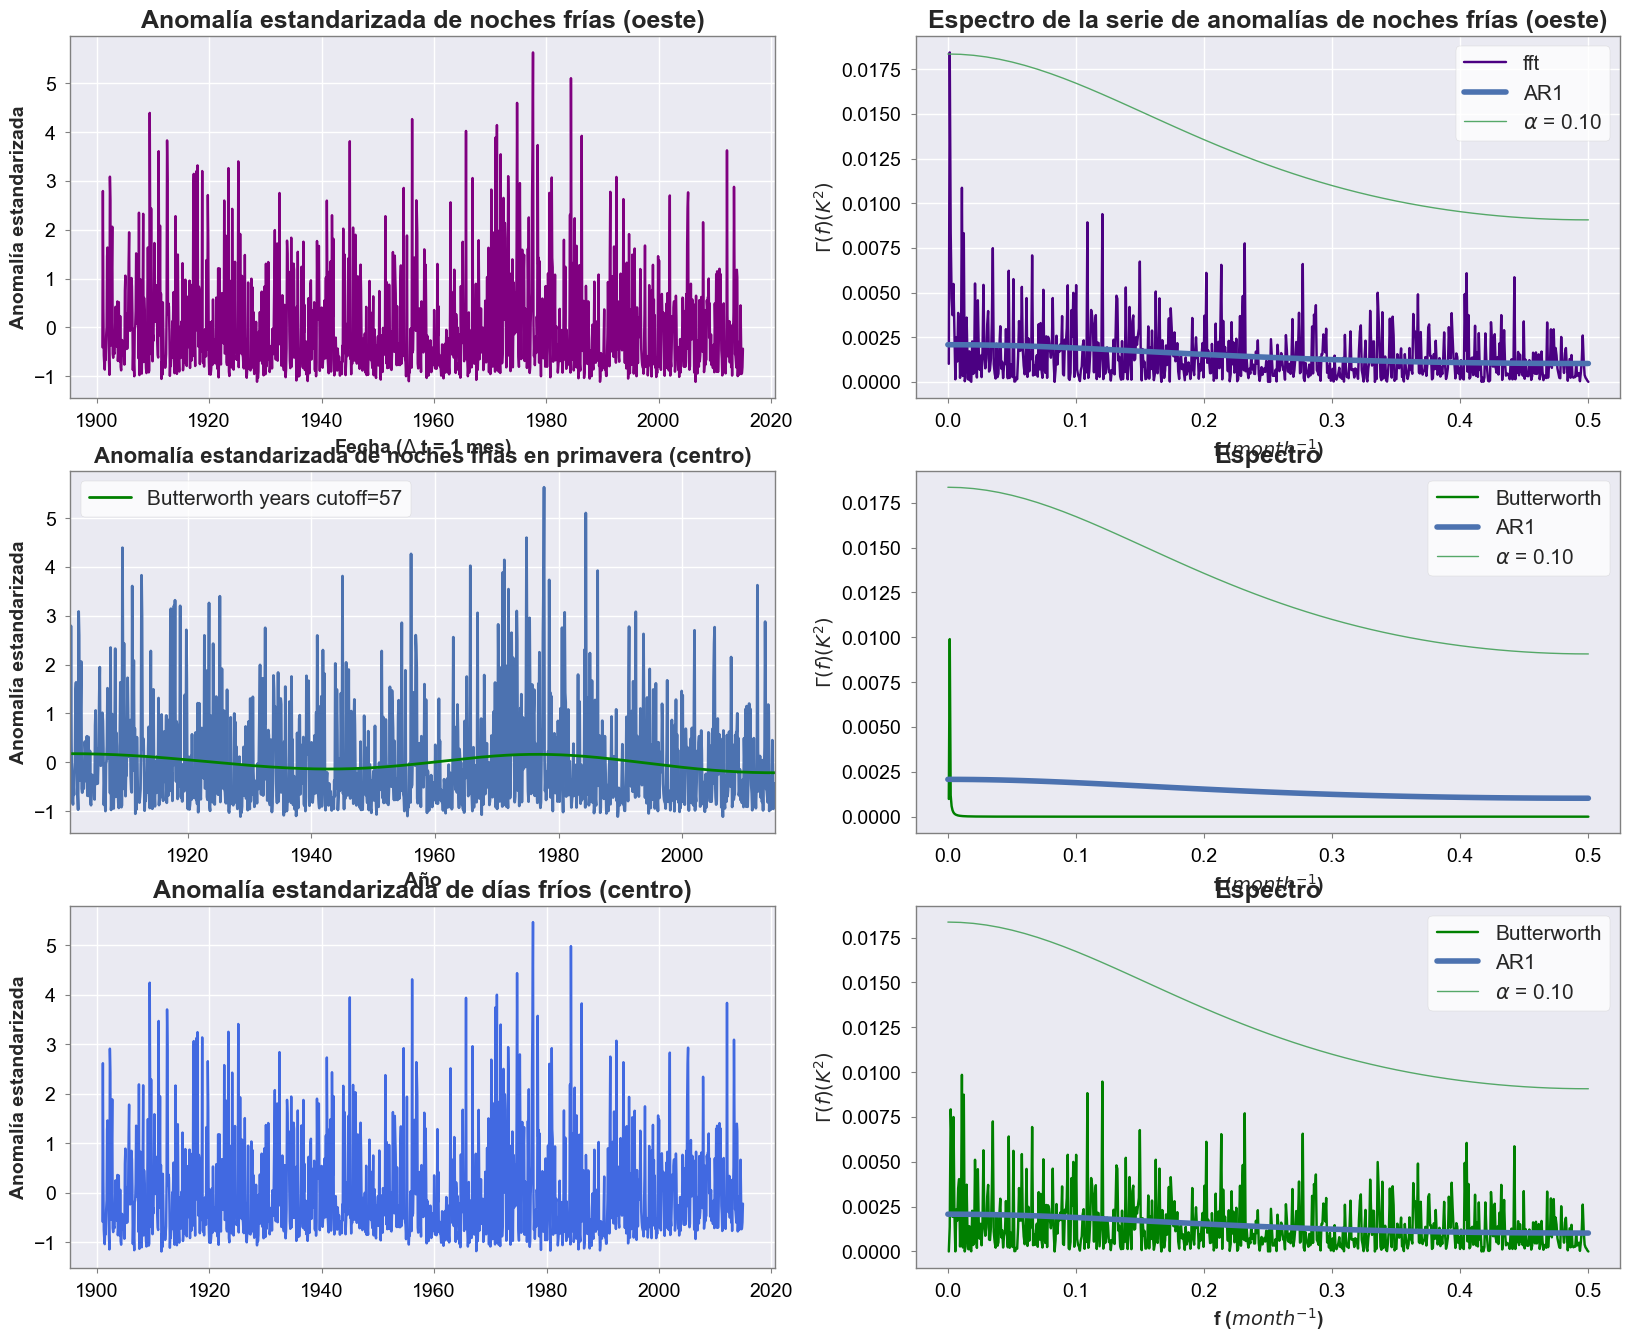

In [765]:
fig,(ax,axd,ax3)=plt.subplots(3,2,figsize=(20,16))
# Fila de arriba
x_cn = anom_CN_std
ax[0].plot(años,x_cn,color='purple')
ax[0].set_ylabel(u'Anomalía estandarizada')
ax[0].set_xlabel(r'Fecha ($\Delta$ t = 1 mes)')
ax[0].set_title(u'Anomalía estandarizada de noches frías (oeste)')


#fa,Ga = espectroArmonico(x,1)
ff,Gf = espectroFFT(x_cn,1)
#ax[1].plot(fa,Ga,linewidth=1)
ax[1].plot(ff,Gf,label='fft',color='indigo')
ax[1].set_ylabel(r'$\Gamma(f) (K^2)$')
ax[1].set_xlabel(r'f ($month^{-1}$)')
ax[1].set_title('Espectro de la serie de anomalías de noches frías (oeste)')

print('La varianza de la serie es ',float(np.var(x_cn)))
print('La integral del espectro es ',sum(Gf))
#Veamos si los picos sobresalen lo suficiente:
alpha = 0.1
alphaS = alpha / Gf.size
nu = 2
chi2 = stats.chi2.ppf(1-alphaS,2)
N = x_cn.size
s2 = float(np.var(x_cn))
cor = stattools.acf(x_cn, fft=False, nlags = 1) * N/(N-1)
a = cor[1]
# a = 0 #Para ruido blanco
f_t,G_t = redSpectra(a,s2)
ax[1].plot(f_t,G_t/x_cn.size,linewidth=4,label='AR1')
GmaxG_t = G_t/x_cn.size/nu*chi2
ax[1].plot(f_t,GmaxG_t,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))
a,s2,chi2
ax[1].legend()


n = 4
# b,a = signal.butter(n,fc*2,,output='ba',btype='bandpass')
b,a = signal.butter(n,frec_mens_nochesf*2,output='ba')
#Filtro la señal ampliada y me quedo con la parte central:
xtot = np.append(np.flip(x_cn),[x,np.flip(x_cn)])
ytotx_cn = signal.filtfilt(b,a,xtot)
yButter = ytotx_cn[N:2*N]
axd[0].plot(t,x_cn,linewidth=2)
axd[0].set_title('Anomalía estandarizada de noches frías en primavera (centro)',fontsize=16,weight='bold')
axd[0].set_xlabel('Año')
axd[0].set_ylabel(u'Anomalía estandarizada')
axd[0].plot(t,yButter,linewidth= 2,color='green',label='Butterworth years cutoff='+str(nyc))
axd[0].set_xlim([1901,2015])
axd[0].legend()

x_butter = np.squeeze(np.array(yButter))

ff_but,Gf_but = espectroFFT(x_butter,1)
axd[1].plot(ff_but,Gf_but,label='Butterworth',color='g')
axd[1].grid()
axd[1].set_ylabel(r'$\Gamma(f) (K^2)$')
axd[1].set_xlabel(r'f ($month^{-1}$)')
axd[1].set_title('Espectro')
#Veamos si los picos sobresalen lo suficiente:
alpha = 0.1
alphaS = alpha / Gf.size
nu = 2
chi2 = stats.chi2.ppf(1-alphaS,2)
N = x_cn.size
s2 = float(np.var(x_cn))
cor = stattools.acf(x_cn, fft=False, nlags = 1) * N/(N-1)
a = cor[1]
# a = 0 #Para ruido blanco
f,G = redSpectra(a,s2)
axd[1].plot(f,G/x_cn.size,linewidth=4,label='AR1')
Gmax = G/x_cn.size/nu*chi2
axd[1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))
a,s2,chi2
axd[1].legend()


xresta=x_cn-yButter
ax3[0].plot(xresta.time,xresta,color='royalblue')
ax3[0].set_ylabel(u'Anomalía estandarizada')
# ax[0].set_xlabel(r'%s de cada año'%(season))
ax3[0].set_title(u'Anomalía estandarizada de días fríos (centro)')

ff_rest,Gf_rest = espectroFFT(xresta,1)
ax3[1].plot(ff_rest,Gf_rest,label='Butterworth',color='g')
ax3[1].grid()
ax3[1].set_ylabel(r'$\Gamma(f) (K^2)$')
ax3[1].set_xlabel(r'f ($month^{-1}$)')
ax3[1].set_title('Espectro')

#Veamos si los picos sobresalen lo suficiente:
alpha = 0.1
alphaS = alpha / Gf.size
nu = 2
chi2 = stats.chi2.ppf(1-alphaS,2)
N = x.size
s2 = float(np.var(x))
cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
a = cor[1]
#a = 0 #Para ruido blanco
f_tot,G_tot = redSpectra(a,s2)
ax3[1].plot(f_tot,G_tot/x.size,linewidth=4,label='AR1')
Gmax_tot = G_tot/x.size/nu*chi2
ax3[1].plot(f_tot,Gmax_tot,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))
a,s2,chi2
ax3[1].legend()
